# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import itertools
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')
from scipy.stats import wilcoxon

In [2]:
zips = pd.read_csv('zillow_data.csv')

In [3]:
zips.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [4]:
zips_focused = zips.loc[zips['Metro'] == 'Fayetteville']
zips_focused = zips_focused.loc[zips_focused['State'] == 'AR']
zips_focused

RegionID  RegionName            City State         Metro  CountyName  \
373       89712       72712     Bentonville    AR  Fayetteville      Benton   
799       89707       72701    Fayetteville    AR  Fayetteville  Washington   
868       89749       72764      Springdale    AR  Fayetteville  Washington   
1535      89743       72756          Rogers    AR  Fayetteville      Benton   
1596      89709       72703    Fayetteville    AR  Fayetteville  Washington   
1704      89745       72758          Rogers    AR  Fayetteville      Benton   
2282      89748       72762      Springdale    AR  Fayetteville  Washington   
3413      89710       72704    Fayetteville    AR  Fayetteville  Washington   
5116      89747       72761  Siloam Springs    AR  Fayetteville      Benton   
5772      89714       72715     Bella Vista    AR  Fayetteville      Benton   
7239      89713       72714     Bella Vista    AR  Fayetteville      Benton   
7650      89718       72719       Centerton    AR  Fayetteville      Benton   
7674      89737       72745          Lowell    AR  Fayetteville      Benton   
8643      89724       72730      Farmington    AR  Fayetteville  Washington   
9429      89727       72734          Gentry    AR  Fayetteville      Benton   
9524      89740       72751       Pea Ridge    AR  Fayetteville      Benton   
9824      89756       72774       West Fork    AR  Fayetteville  Washington   
10070     89721       72727          Elkins    AR  Fayetteville  Washington   
10679     89725       72732        Garfield    AR  Fayetteville      Benton   
11969     89717       72718    Cave Springs    AR  Fayetteville      Benton   
12602     89720       72722         Decatur    AR  Fayetteville      Benton   

       SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  \
373         374   96200.0   96300.0   96400.0   ...      220700   220100   
799         800   83100.0   83500.0   83700.0   ...      194200   195400   
868         869       NaN       NaN       NaN   ...      143200   143700   
1535       1536   75600.0   75800.0   76100.0   ...      148500   149500   
1596       1597  104900.0  105300.0  105600.0   ...      219600   220300   
1704       1705  103600.0  103500.0  103200.0   ...      209400   208700   
2282       2283   84600.0   84900.0   85100.0   ...      170800   171800   
3413       3414   92800.0   92600.0   92000.0   ...      178800   180400   
5116       5117   67900.0   67900.0   68000.0   ...      135800   136200   
5772       5773   97600.0   97200.0   96900.0   ...      161400   161800   
7239       7240   90300.0   90600.0   91000.0   ...      155400   156200   
7650       7651   79200.0   79600.0   80100.0   ...      164900   165200   
7674       7675   79500.0   79700.0   79900.0   ...      155900   157100   
8643       8644   84000.0   83900.0   83600.0   ...      163600   164800   
9429       9430   62300.0   62400.0   62500.0   ...      126100   125600   
9524       9525   77400.0   77800.0   78100.0   ...      137600   137900   
9824       9825   60600.0   61100.0   61500.0   ...      136700   138100   
10070     10071   59800.0   59900.0   59900.0   ...      121000   122200   
10679     10680   72800.0   73300.0   73700.0   ...      156200   159500   
11969     11970       NaN       NaN       NaN   ...      251700   251300   
12602     12603   54900.0   55100.0   55300.0   ...      117100   116700   

       2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
373     219400   219200   218900   219100   220200   222200   225700   228400  
799     196600   198500   201100   203800   206100   208700   211700   214000  
868     144300   144900   145800   146600   147100   148300   150300   152000  
1535    149800   149500   149200   149200   149400   150400   152300   153700  
1596    220900   222400   223900   225100   225500   226300   227600   228500  
1704    208300   208200   207400   207200   208100   209600   211700   213500  
2282    172500   172900   173400   

# Step 2: Data Preprocessing

In [5]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [6]:
get_datetimes(zips_focused)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [7]:
zips_focused.head()

RegionID  RegionName          City State         Metro  CountyName  \
373      89712       72712   Bentonville    AR  Fayetteville      Benton   
799      89707       72701  Fayetteville    AR  Fayetteville  Washington   
868      89749       72764    Springdale    AR  Fayetteville  Washington   
1535     89743       72756        Rogers    AR  Fayetteville      Benton   
1596     89709       72703  Fayetteville    AR  Fayetteville  Washington   

      SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  \
373        374   96200.0   96300.0   96400.0   ...      220700   220100   
799        800   83100.0   83500.0   83700.0   ...      194200   195400   
868        869       NaN       NaN       NaN   ...      143200   143700   
1535      1536   75600.0   75800.0   76100.0   ...      148500   149500   
1596      1597  104900.0  105300.0  105600.0   ...      219600   220300   

      2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
373    219400   219200   218900   219100   220200   222200   225700   228400  
799    196600   198500   201100   203800   206100   208700   211700   214000  
868    144300   144900   145800   146600   147100   148300   150300   152000  
1535   149800   149500   149200   149200   149400   150400   152300   153700  
1596   220900   222400   223900   225100   225500   226300   227600   228500  

[5 rows x 272 columns]

In [8]:
def data_inspector(df):
    duplicates = df[df.duplicated()]
    display('----Missing Values----',df.isna().sum())
    display('----Duplicate Values----')
    display(str(len(duplicates))  + ' duplicates')
    for col in df.columns:
        print(col, '\n', df[col].value_counts(normalize=True), '\n\n')

This study will only include data after 2008 to help control for the Great Recession

In [9]:
zips_focused.drop(zips_focused.columns.values[5:158], axis=1, inplace=True)

In [10]:
data_inspector(zips_focused)

'----Missing Values----'

RegionID      0
RegionName    0
City          0
State         0
Metro         0
2008-11       1
2008-12       1
2009-01       1
2009-02       1
2009-03       1
2009-04       1
2009-05       1
2009-06       1
2009-07       1
2009-08       1
2009-09       1
2009-10       1
2009-11       1
2009-12       1
2010-01       1
2010-02       1
2010-03       1
2010-04       1
2010-05       1
2010-06       1
2010-07       1
2010-08       1
2010-09       1
2010-10       1
2010-11       1
             ..
2015-11       0
2015-12       0
2016-01       0
2016-02       0
2016-03       0
2016-04       0
2016-05       0
2016-06       0
2016-07       0
2016-08       0
2016-09       0
2016-10       0
2016-11       0
2016-12       0
2017-01       0
2017-02       0
2017-03       0
2017-04       0
2017-05       0
2017-06       0
2017-07       0
2017-08       0
2017-09       0
2017-10       0
2017-11       0
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 119, dtype: int6

'----Duplicate Values----'

'0 duplicates'

RegionID 
 89727    0.047619
89712    0.047619
89717    0.047619
89720    0.047619
89737    0.047619
89707    0.047619
89740    0.047619
89709    0.047619
89710    0.047619
89743    0.047619
89745    0.047619
89725    0.047619
89714    0.047619
89747    0.047619
89748    0.047619
89749    0.047619
89718    0.047619
89713    0.047619
89721    0.047619
89724    0.047619
89756    0.047619
Name: RegionID, dtype: float64 


RegionName 
 72703    0.047619
72718    0.047619
72732    0.047619
72774    0.047619
72712    0.047619
72745    0.047619
72714    0.047619
72715    0.047619
72751    0.047619
72730    0.047619
72719    0.047619
72734    0.047619
72722    0.047619
72756    0.047619
72758    0.047619
72727    0.047619
72761    0.047619
72762    0.047619
72764    0.047619
72701    0.047619
72704    0.047619
Name: RegionName, dtype: float64 


City 
 Fayetteville      0.142857
Springdale        0.095238
Bella Vista       0.095238
Rogers            0.095238
Gentry            0.047619
Pea Ridg

Name: 2013-12, dtype: float64 


2014-01 
 140700.0    0.05
113000.0    0.05
169600.0    0.05
80800.0     0.05
161700.0    0.05
111300.0    0.05
130600.0    0.05
134600.0    0.05
111500.0    0.05
144700.0    0.05
122500.0    0.05
167300.0    0.05
114000.0    0.05
99400.0     0.05
135300.0    0.05
92900.0     0.05
154600.0    0.05
184100.0    0.05
143300.0    0.05
112500.0    0.05
Name: 2014-01, dtype: float64 


2014-02 
 183800.0    0.05
135000.0    0.05
111600.0    0.05
134500.0    0.05
110200.0    0.05
141300.0    0.05
113100.0    0.05
82600.0     0.05
100500.0    0.05
130200.0    0.05
168600.0    0.05
92600.0     0.05
154300.0    0.05
114000.0    0.05
111800.0    0.05
122800.0    0.05
141800.0    0.05
144100.0    0.05
161200.0    0.05
167200.0    0.05
Name: 2014-02, dtype: float64 


2014-03 
 123700.0    0.05
134700.0    0.05
131200.0    0.05
112100.0    0.05
142700.0    0.05
112500.0    0.05
134600.0    0.05
160500.0    0.05
136300.0    0.05
113900.0    0.05
142600.0    0.05
1685

There are some missing values. Will examine measures of centrality closely to decide how they will be addressed. <br/>
The are no duplicated values.

In [11]:
zips_na = zips_focused[zips_focused.isna().any(axis=1)]
zips_na.isna()

RegionID  RegionName   City  State  Metro  2008-11  2008-12  2009-01  \
11969     False       False  False  False  False     True     True     True   

       2009-02  2009-03   ...     2017-07  2017-08  2017-09  2017-10  2017-11  \
11969     True     True   ...       False    False    False    False    False   

       2017-12  2018-01  2018-02  2018-03  2018-04  
11969    False    False    False    False    False  

[1 rows x 119 columns]

In [12]:
#Viewing measure of centrality to replace NA values
zips_focused.describe()

RegionID    RegionName        2008-11        2008-12  \
count     21.000000     21.000000      20.000000      20.000000   
mean   89727.714286  72733.428571  133750.000000  132795.000000   
std       15.630556     22.765262   25815.489027   26105.806472   
min    89707.000000  72701.000000   86800.000000   84100.000000   
25%    89714.000000  72715.000000  113500.000000  112725.000000   
50%    89724.000000  72730.000000  133750.000000  132550.000000   
75%    89743.000000  72756.000000  153175.000000  152425.000000   
max    89756.000000  72774.000000  179100.000000  178300.000000   

             2009-01        2009-02      2009-03        2009-04  \
count      20.000000      20.000000      20.0000      20.000000   
mean   131990.000000  131195.000000  130485.0000  129725.000000   
std     26414.188771   26785.138751   27180.3775   27499.662677   
min     81500.000000   79000.000000   76700.0000   74400.000000   
25%    111850.000000  110725.000000  109850.0000  109125.000000   
50%    131450.000000  130350.000000  129400.0000  128400.000000   
75%    151975.000000  151550.000000  151275.0000  150850.000000   
max    177600.000000  176900.000000  176400.0000  176200.000000   

             2009-05        2009-06      ...              2017-07  \
count      20.000000      20.000000      ...            21.000000   
mean   128785.000000  127660.000000      ...        165171.428571   
std     27758.872929   28093.704108      ...         35924.046861   
min     72000.000000   69400.000000      ...        117100.000000   
25%    108275.000000  107225.000000      ...        137600.000000   
50%    127300.000000  126050.000000      ...        156200.000000   
75%    150025.000000  149075.000000      ...        178800.000000   
max    175800.000000  175300.000000      ...        251700.000000   

             2017-08        2017-09        2017-10        2017-11  \
count      21.000000      21.000000      21.000000      21.000000   
mean   165833.333333  166604.761905  167280.952381  167614.285714   
std     35723.498336   35283.274737   35091.118806   35302.865120   
min    116700.000000  117200.000000  117600.000000  114800.000000   
25%    138100.000000  140600.000000  142200.000000  142600.000000   
50%    159500.000000  161800.000000  162000.000000  161800.000000   
75%    180400.000000  182100.000000  183400.000000  184600.000000   
max    251300.000000  250200.000000  249200.000000  248500.000000   

             2017-12        2018-01        2018-02        2018-03  \
count      21.000000      21.000000      21.000000      21.000000   
mean   168047.619048  168809.523810  170314.285714  172852.380952   
std     35945.662034   36623.583997   36817.133046   36331.097135   
min    110600.000000  108600.000000  110600.000000  117700.000000   
25%    143000.000000  143500.000000  143700.000000  144800.000000   
50%    161800.000000  162500.000000  163100.000000  163800.000000   
75%    185500.000000  186300.000000  187500.000000  189100.000000   
max    249800.000000  252600.000000  254600.000000  255300.000000   

             2018-04  
count      21.000000  
mean   174904.761905  
std     35912.010194  
min    123800.000000  
25%    146100.000000  
50%    166000.000000  
75%    193900.000000  
max    255900.000000  

[8 rows x 116 columns]

In [13]:
#Creating a list of zipcodes that need NAs filled.
zips_to_fill = zips_focused.columns[zips_focused.isna().any()].tolist()

In [14]:
#for loop to fill NAs
for i in zips_to_fill:
    zips_focused[i].fillna(zips_focused[i].mean(), inplace=True)

In [15]:
display(zips_focused.head())
print('There are', len(zips_focused), 'zipcodes in this dataset.')

RegionID  RegionName          City State         Metro   2008-11  \
373      89712       72712   Bentonville    AR  Fayetteville  168000.0   
799      89707       72701  Fayetteville    AR  Fayetteville  162900.0   
868      89749       72764    Springdale    AR  Fayetteville  132700.0   
1535     89743       72756        Rogers    AR  Fayetteville  118200.0   
1596     89709       72703  Fayetteville    AR  Fayetteville  179100.0   

       2008-12   2009-01   2009-02   2009-03   ...     2017-07  2017-08  \
373   167200.0  166700.0  166400.0  166300.0   ...      220700   220100   
799   162400.0  162000.0  161400.0  160900.0   ...      194200   195400   
868   131400.0  130200.0  128800.0  127700.0   ...      143200   143700   
1535  116600.0  115100.0  113700.0  112500.0   ...      148500   149500   
1596  178300.0  177600.0  176900.0  176400.0   ...      219600   220300   

      2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
373    219400   219200   218900   219100   220200   222200   225700   228400  
799    196600   198500   201100   203800   206100   208700   211700   214000  
868    144300   144900   145800   146600   147100   148300   150300   152000  
1535   149800   149500   149200   149200   149400   150400   152300   153700  
1596   220900   222400   223900   225100   225500   226300   227600   228500  

[5 rows x 119 columns]

There are 21 zipcodes in this dataset.


# EDA and Visualization

#### Average Home Price for Fayetteville Metro

In [16]:
zips_focused_indicies = list(zips_focused.index)
zips_focused = zips.loc[zips['Metro'] == 'Fayetteville']
zips_focused = zips_focused.loc[zips_focused['State'] == 'AR']

In [17]:
zips_focused_zips = list(zips_focused.RegionName)

In [18]:
#for loop to fill NAs
for i in zips_to_fill:
    zips_focused[i].fillna(zips_focused[i].mean(), inplace=True)

In [19]:
zips_focused.drop(zips_focused.columns.values[7:160], axis=1, inplace=True)

In [20]:
zips_focused = zips_focused.drop('SizeRank', axis=1)

In [21]:
zips_focused = zips_focused.drop('RegionID', axis=1)

In [22]:
#Using melt function early to make visualization cleaner
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [23]:
zips_plot = melt_data(zips_focused)

In [24]:
zips_plot.head()

value
time                
2009-01-01  131990.0
2009-02-01  131195.0
2009-03-01  130485.0
2009-04-01  129725.0
2009-05-01  128785.0

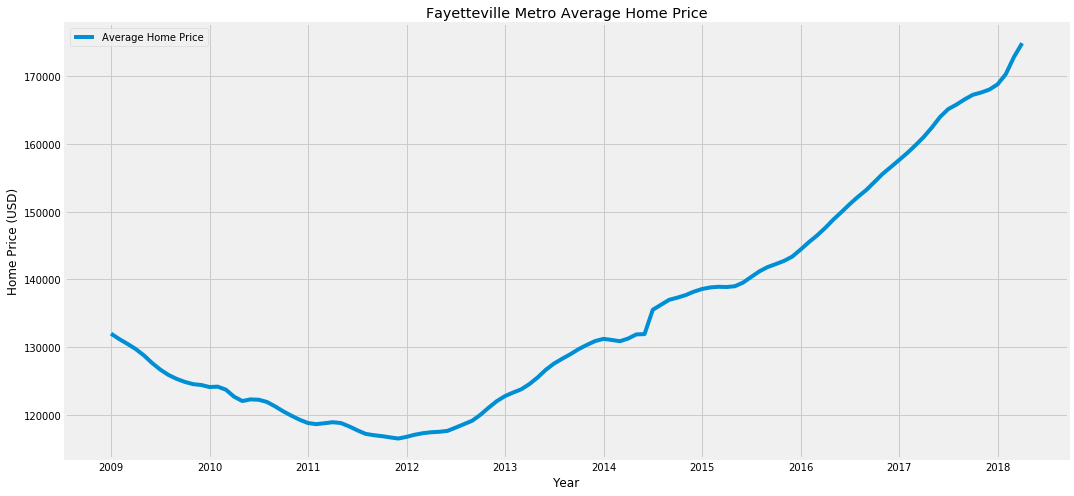

In [25]:
#READY TO PLOT >:D
zips_plot.plot(figsize=(16,8));
plt.title('Fayetteville Metro Average Home Price');
plt.xlabel('Year');
plt.ylabel('Home Price (USD)');
plt.legend(['Average Home Price']);

#### Average Home Price by Zipcode  

In [26]:
zips_avgs = zips_focused.groupby('RegionName').mean()

In [27]:
zipcode = []
significance = []

In [28]:
#Melt function displays mean for melted values. zips_plot represents means across entire metro
for i in zips_focused_zips:
    result = wilcoxon(np.concatenate(zips_plot.values, axis=None), np.concatenate(zips_avgs.loc[i].values, axis=None))
    zipcode.append(i)
    if result[1] < .05:
        significance.append('Yes')
    else: 
        significance.append('No')

In [29]:
home_price_sig = pd.DataFrame({'Zipcode': zipcode, 'Significant Difference?': significance})
home_price_sig.set_index('Zipcode')

Significant Difference?
Zipcode                        
72712                       Yes
72701                       Yes
72764                       Yes
72756                       Yes
72703                       Yes
72758                       Yes
72762                       Yes
72704                       Yes
72761                       Yes
72715                       Yes
72714                        No
72719                       Yes
72745                       Yes
72730                       Yes
72734                       Yes
72751                       Yes
72774                       Yes
72727                       Yes
72732                       Yes
72718                       Yes
72722                       Yes

72712


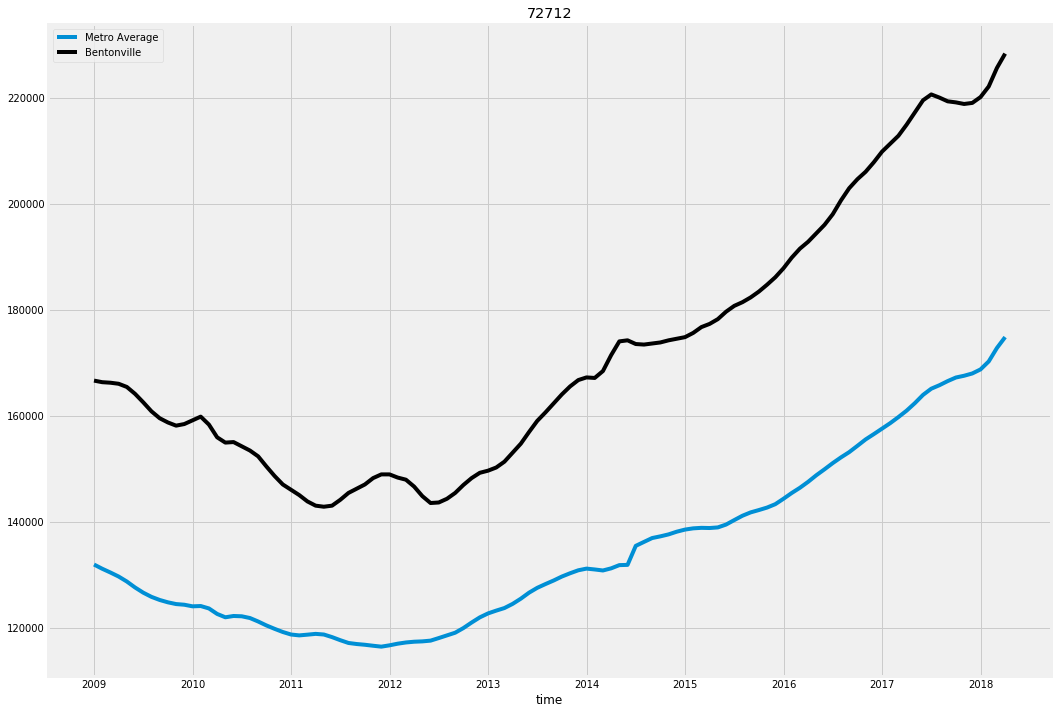

72701


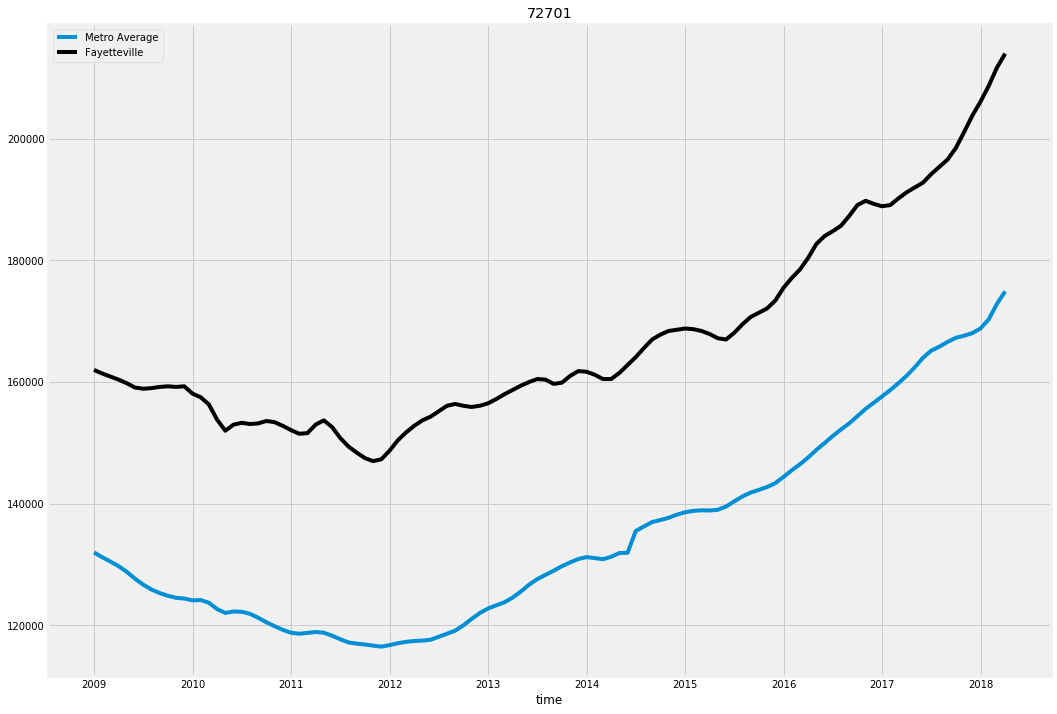

72764


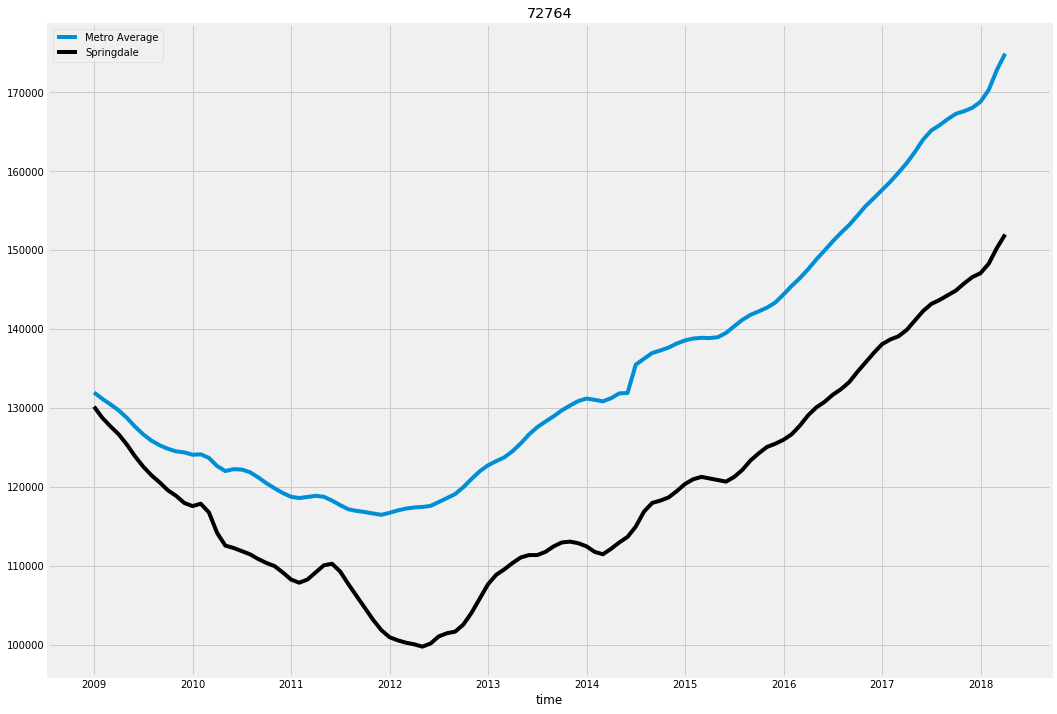

72756


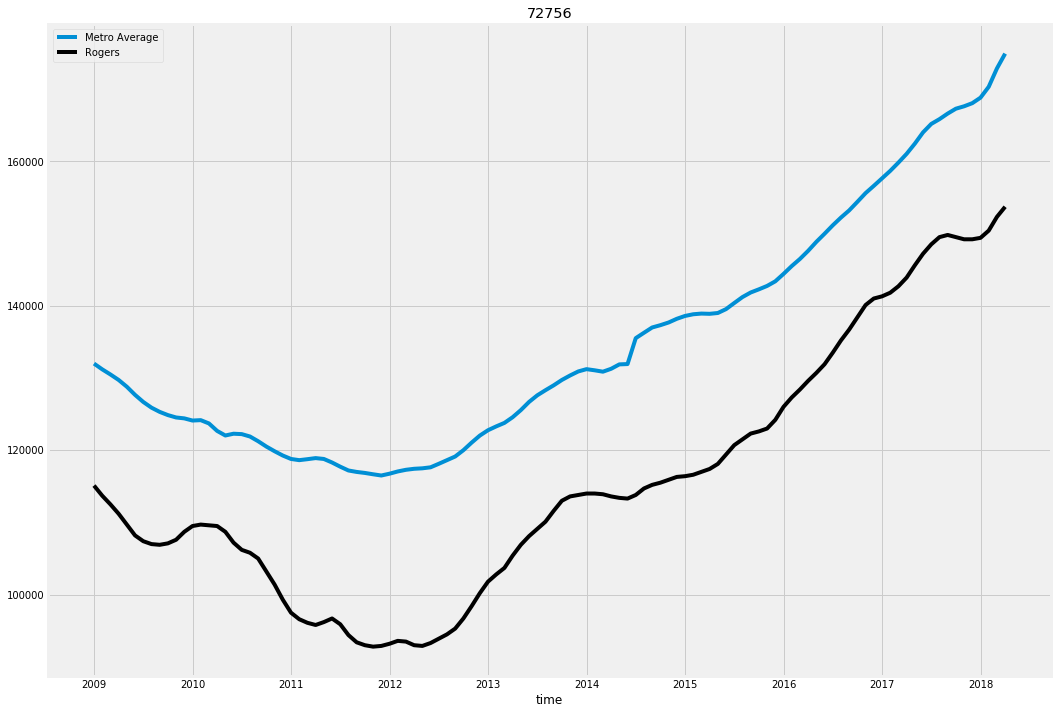

72703


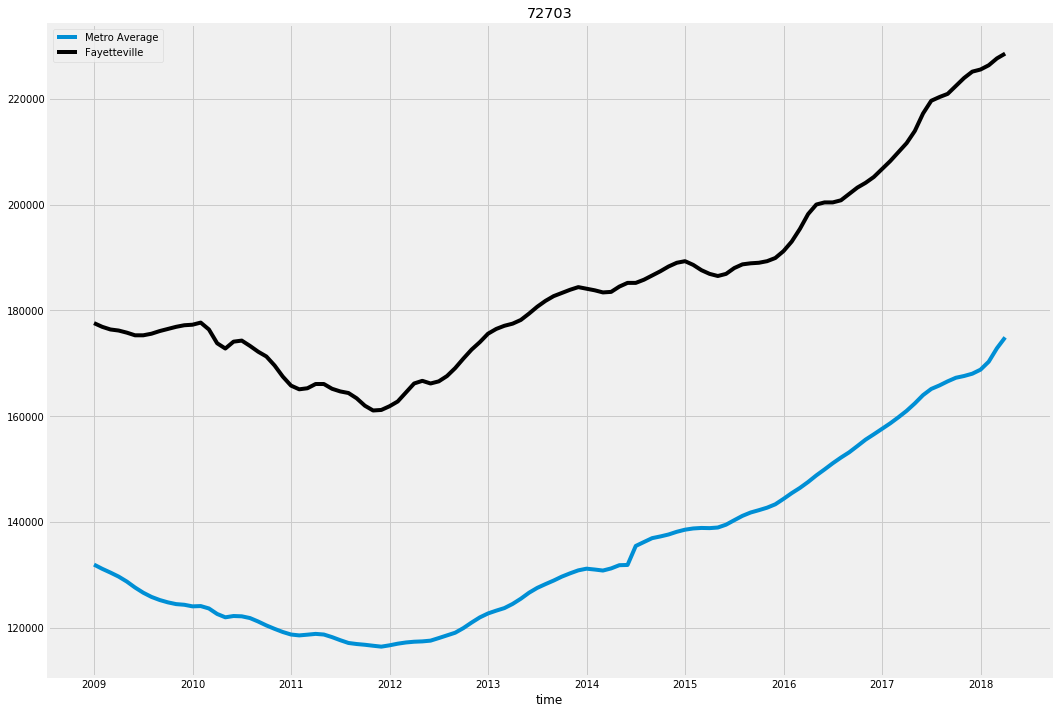

72758


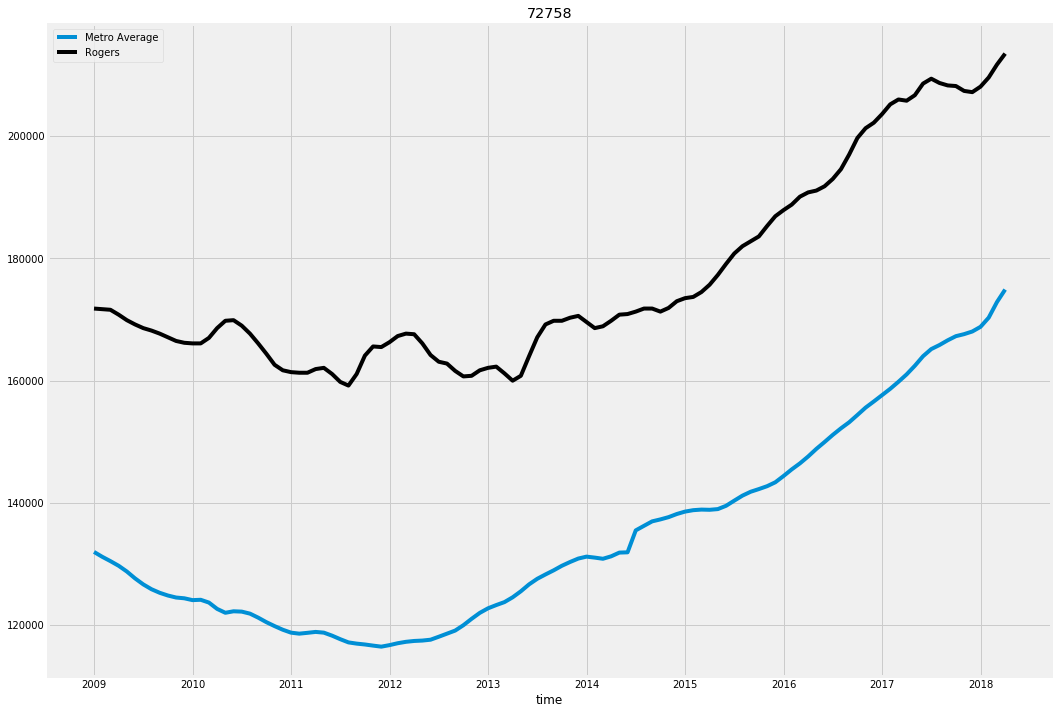

72762


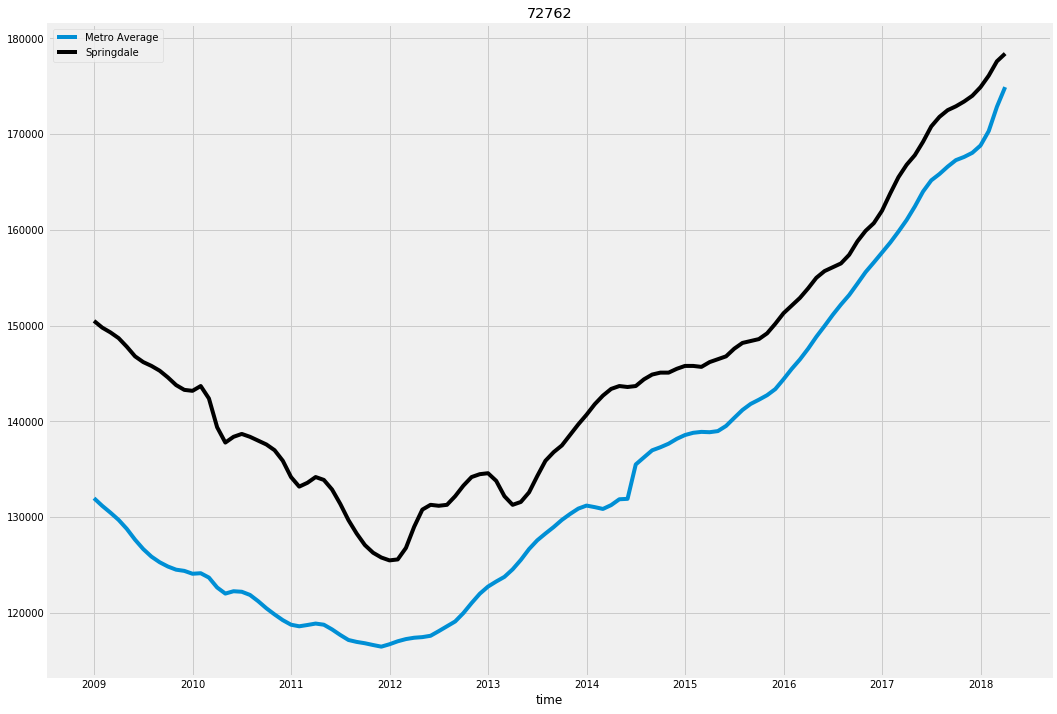

72704


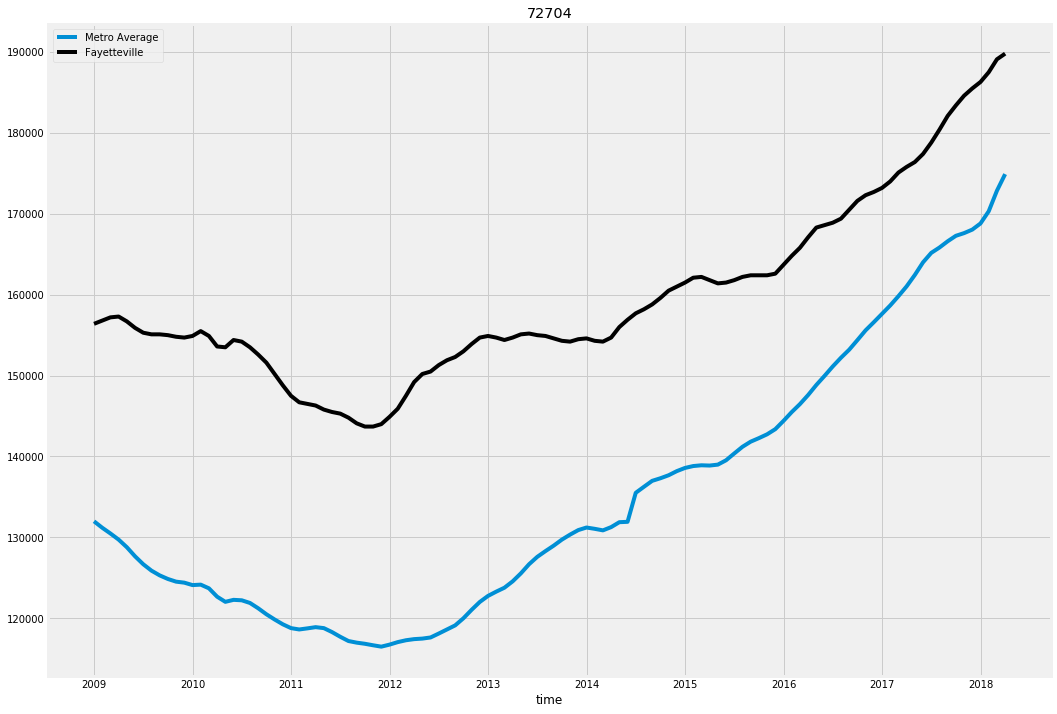

72761


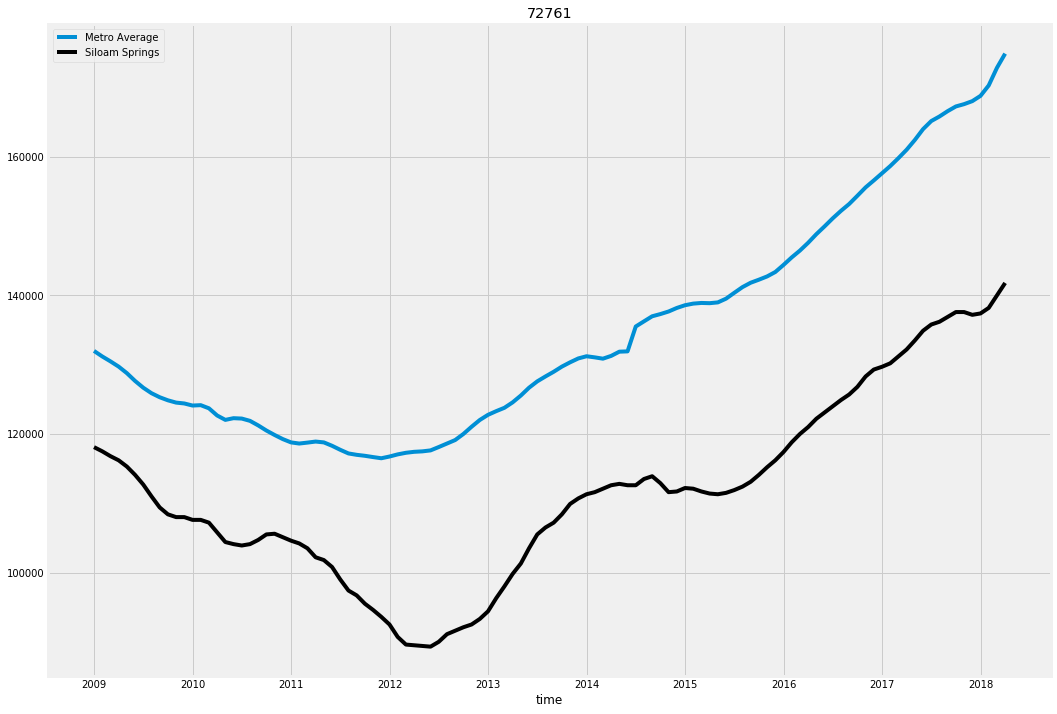

72715


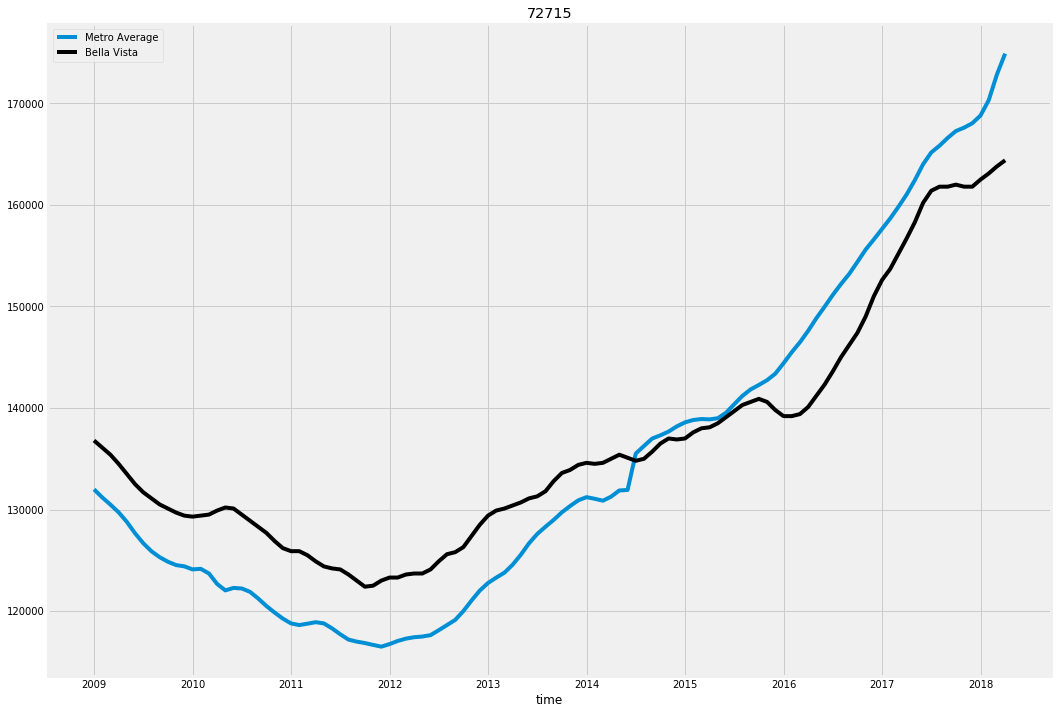

72714


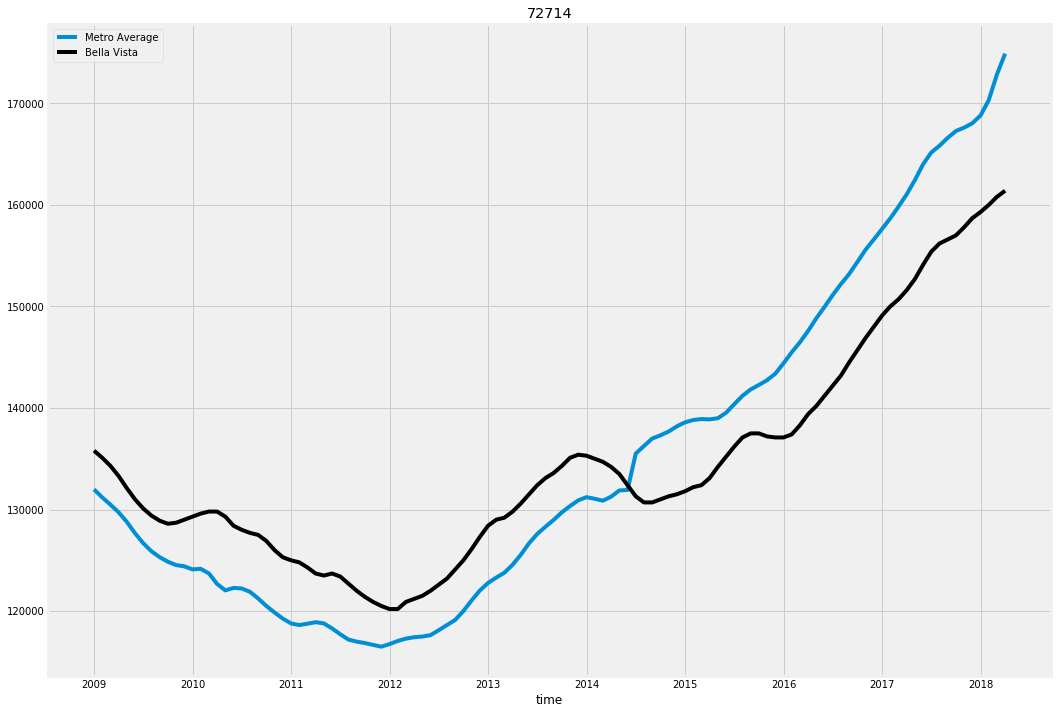

72719


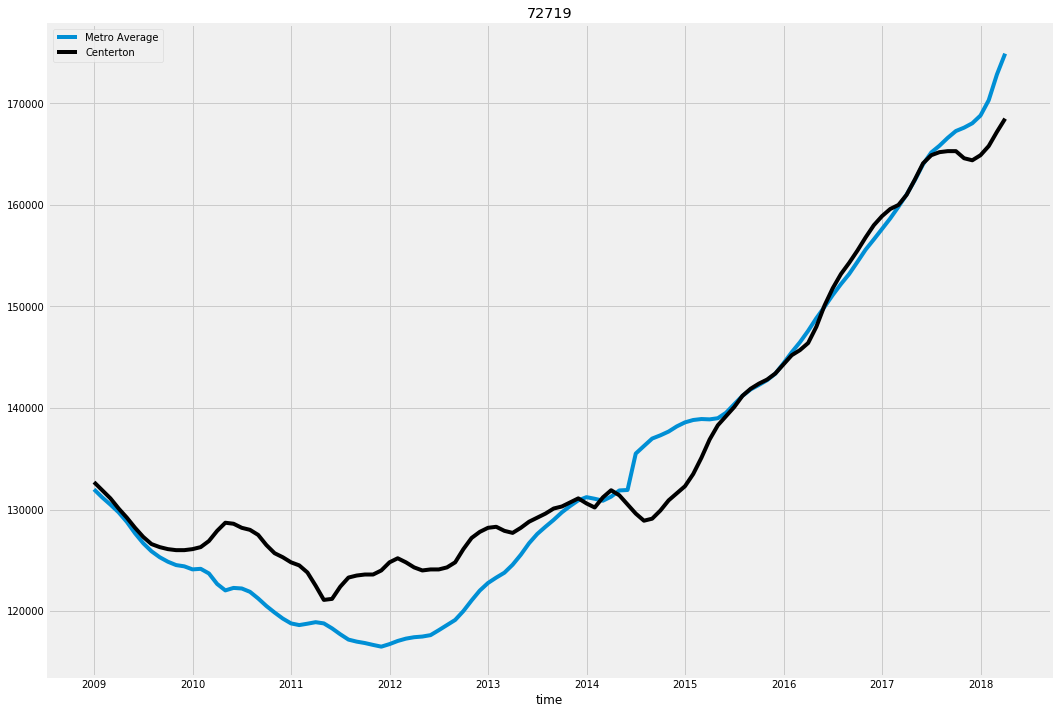

72745


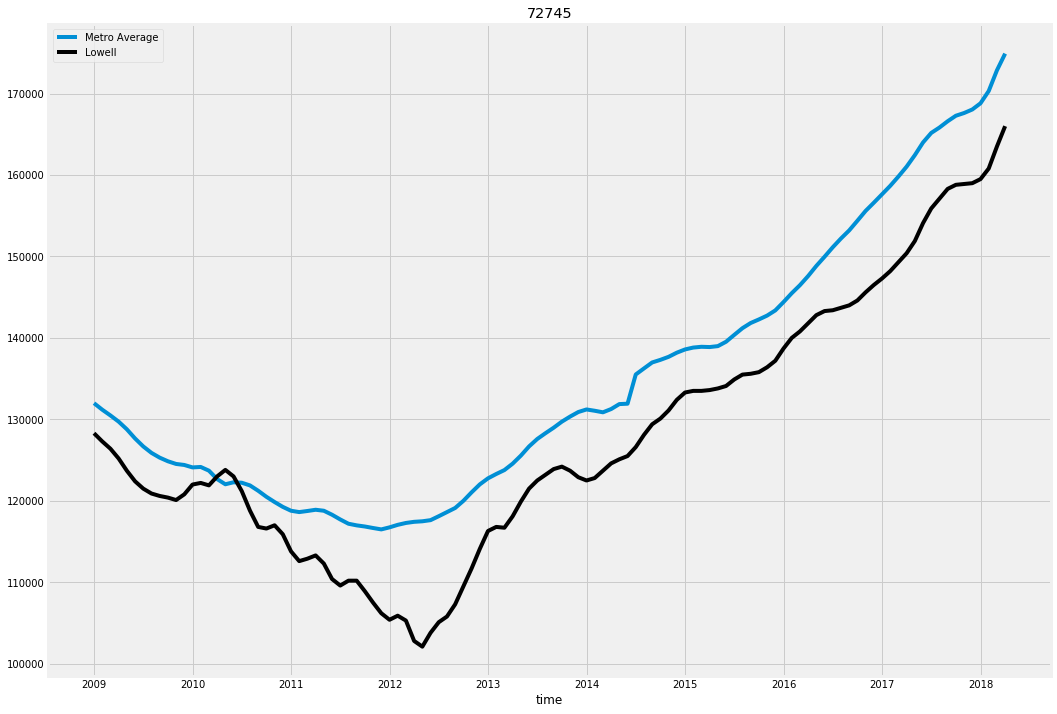

72730


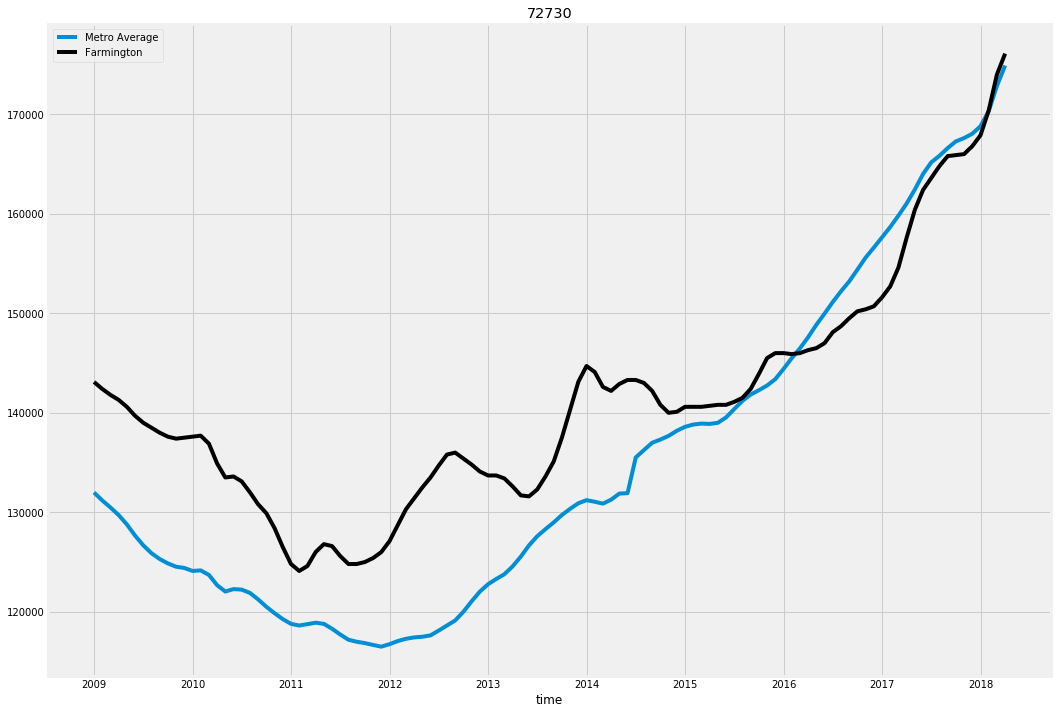

72734


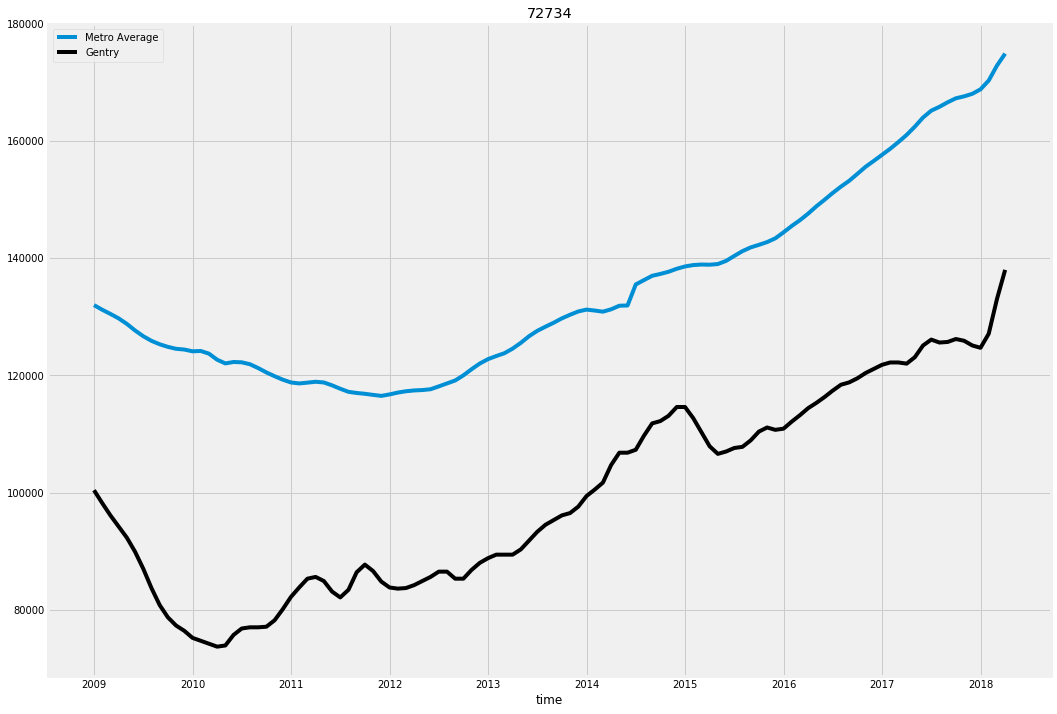

72751


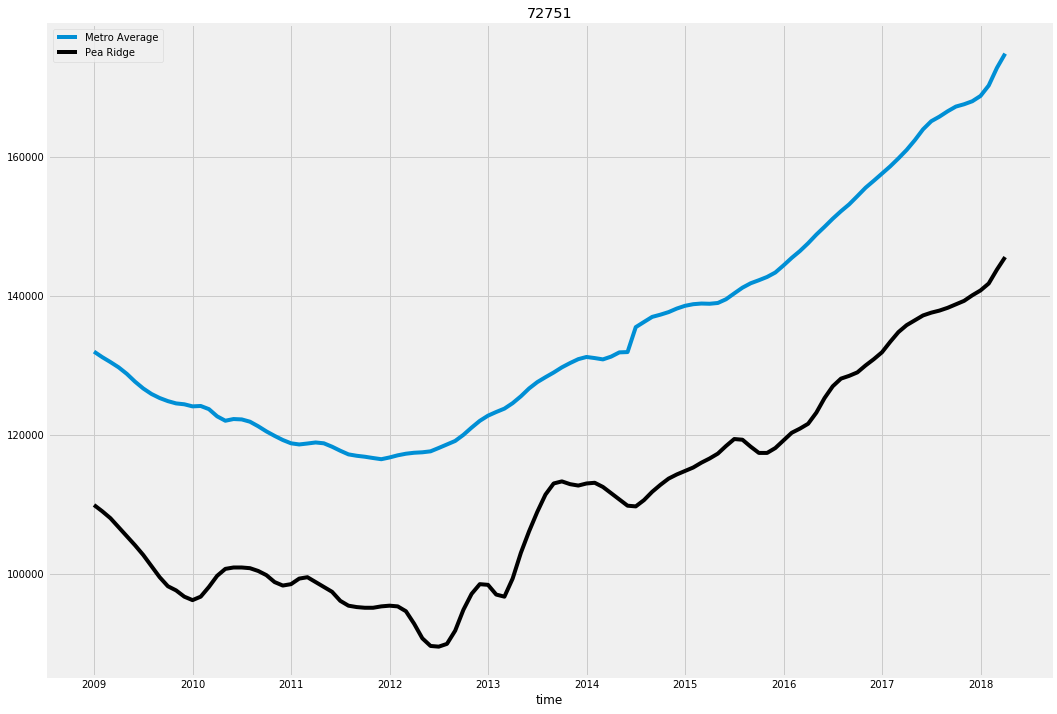

72774


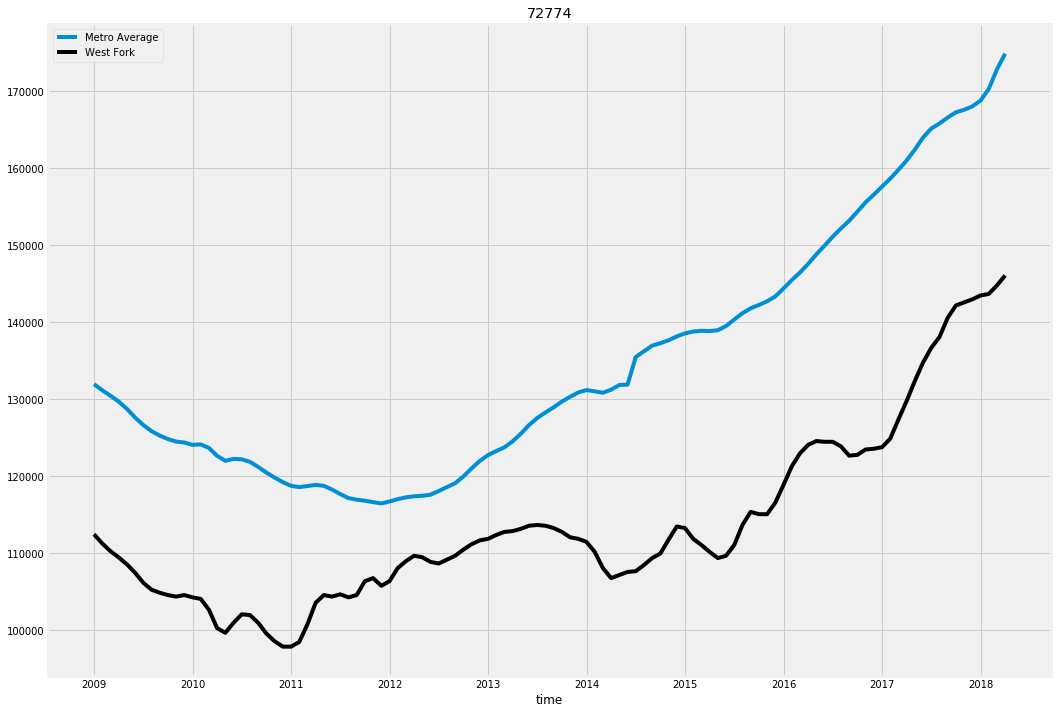

72727


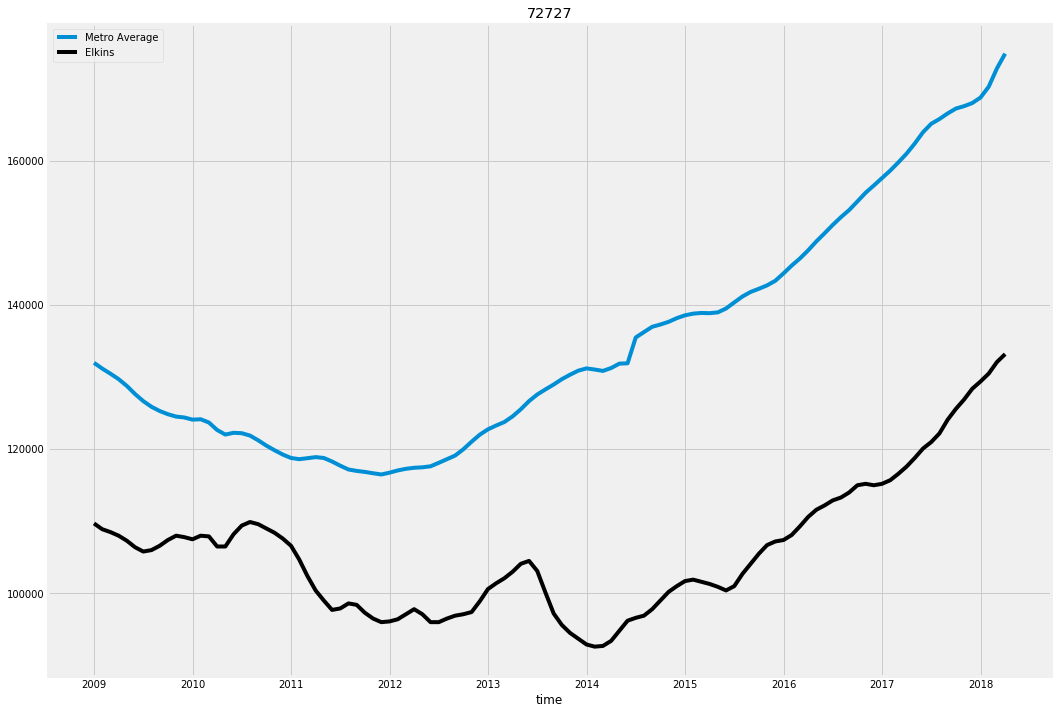

72732


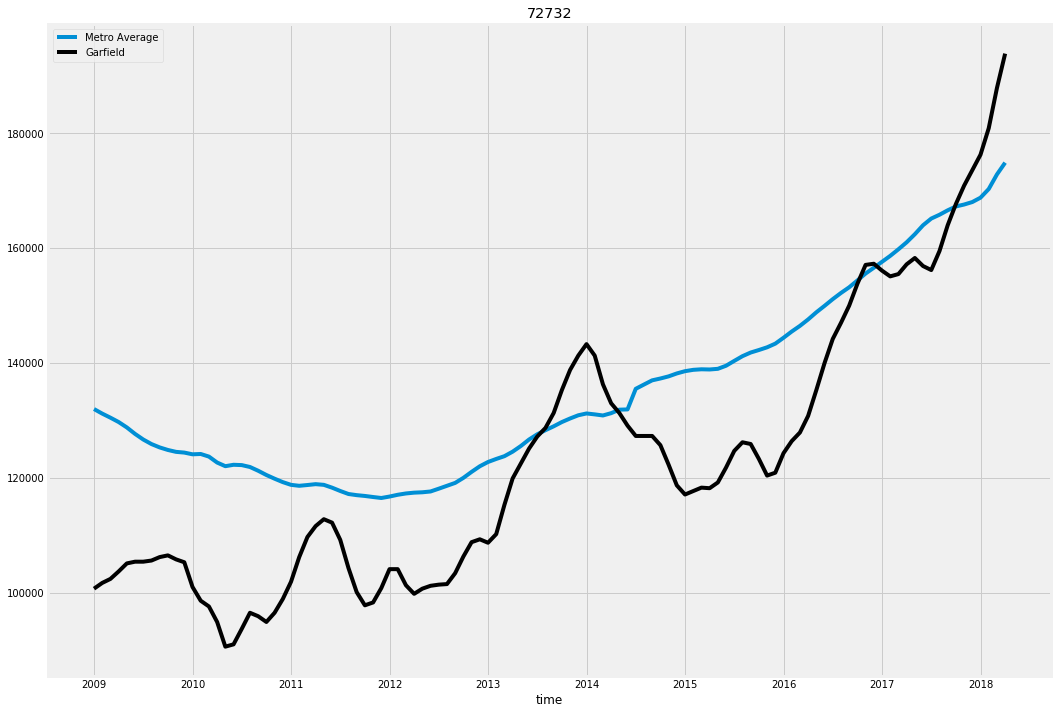

72718


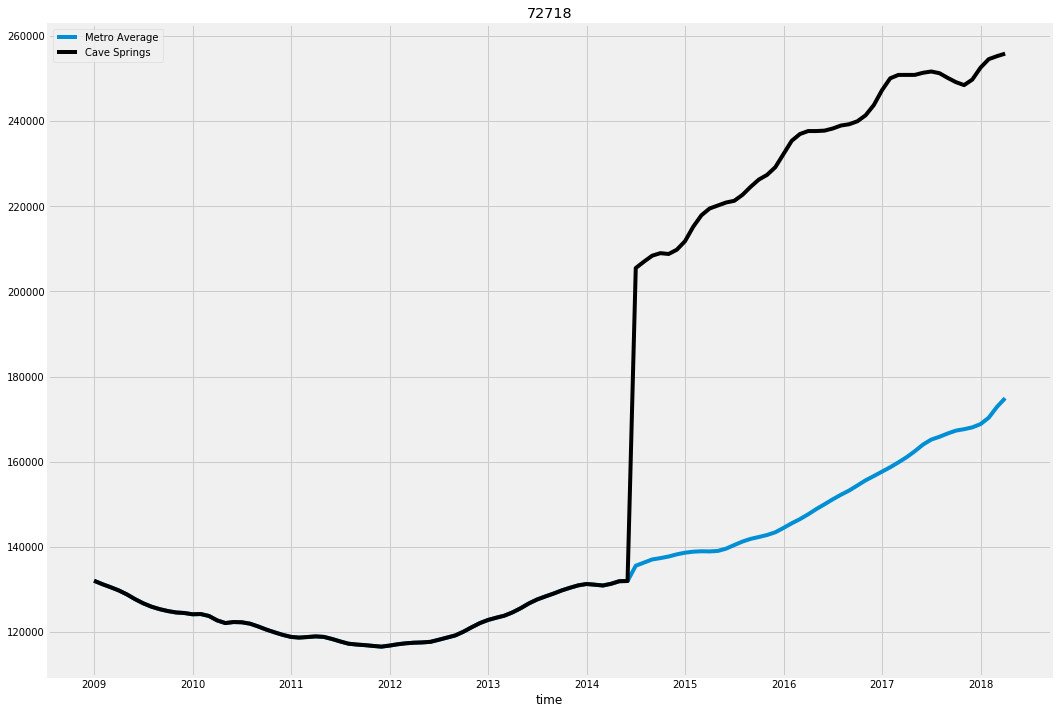

72722


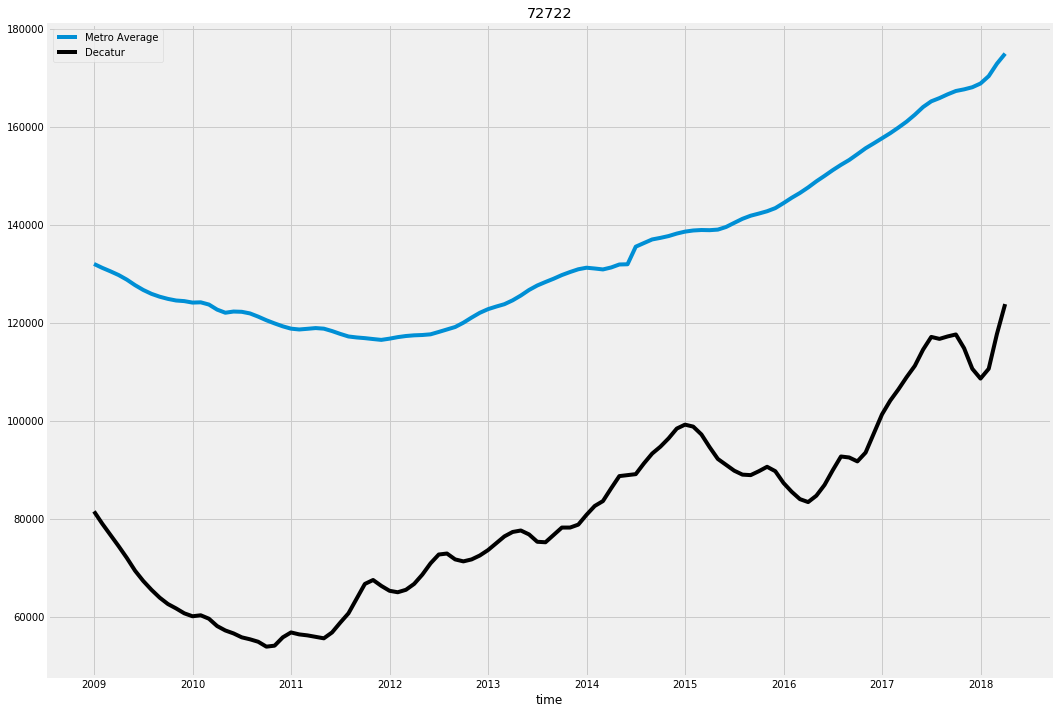

In [40]:
#Wanted to visualize the differences between average prices for the metro vs. each zipcode
for i in zips_focused_indicies:
    print('================================================================')
    print(zips_focused['RegionName'].loc[i])
    ax = zips_plot.plot(label='Metro Average', figsize=(16,12));
    melt_data(zips_focused.loc[[i]]).plot(ax = ax, label=zips_focused['RegionName'].loc[[i]], color='black')
    ax.legend(['Metro Average', zips_focused['City'].loc[i]]);
    plt.title(zips_focused['RegionName'].loc[i])
    plt.show()

# Reshape from Wide to Long Format

In [31]:
#Data will exclude 2008 recession

In [32]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# SARIMA Modeling

Checking for stationarity in database.

======================== Zipcode: 72712 ========================


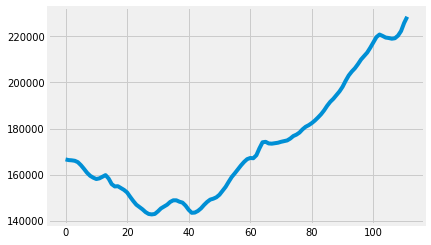

Results of Dickey-Fuller Test:
Test Statistic                   1.195814
p-value                          0.995957
#Lags Used                       4.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64
======================== Zipcode: 72701 ========================


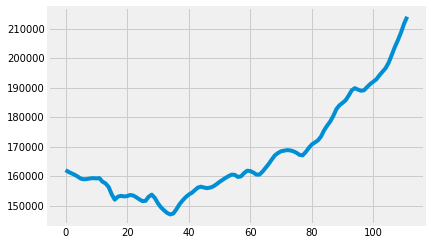

Results of Dickey-Fuller Test:
Test Statistic                  1.703844
p-value                         0.998138
#Lags Used                     13.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64
======================== Zipcode: 72764 ========================


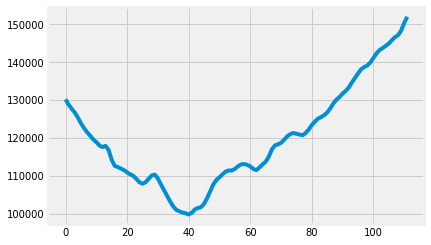

Results of Dickey-Fuller Test:
Test Statistic                   0.571469
p-value                          0.986891
#Lags Used                       5.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
======================== Zipcode: 72756 ========================


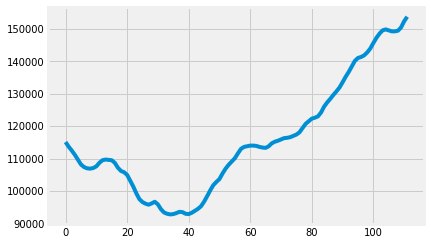

Results of Dickey-Fuller Test:
Test Statistic                   0.179603
p-value                          0.971094
#Lags Used                      10.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64
======================== Zipcode: 72703 ========================


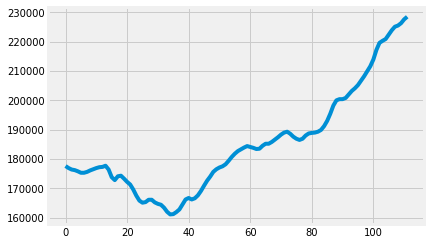

Results of Dickey-Fuller Test:
Test Statistic                 -0.177245
p-value                         0.941180
#Lags Used                     13.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64
======================== Zipcode: 72758 ========================


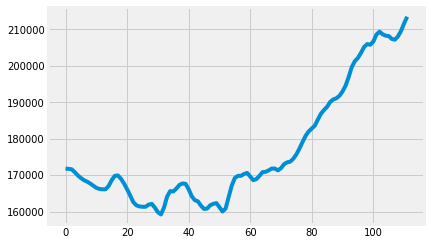

Results of Dickey-Fuller Test:
Test Statistic                  1.788460
p-value                         0.998326
#Lags Used                     12.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64
======================== Zipcode: 72762 ========================


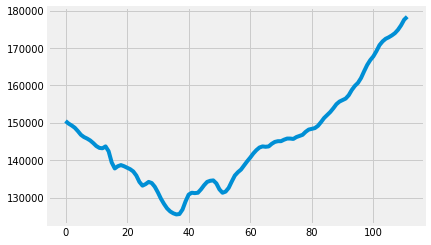

Results of Dickey-Fuller Test:
Test Statistic                   0.275443
p-value                          0.976189
#Lags Used                       9.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64
======================== Zipcode: 72704 ========================


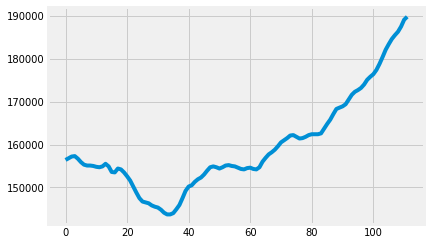

Results of Dickey-Fuller Test:
Test Statistic                   0.643607
p-value                          0.988643
#Lags Used                       3.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
======================== Zipcode: 72761 ========================


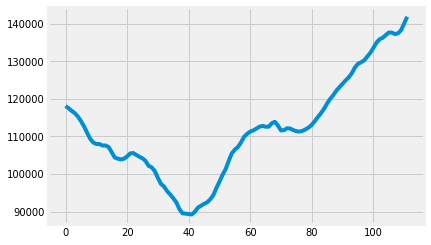

Results of Dickey-Fuller Test:
Test Statistic                  0.390611
p-value                         0.981140
#Lags Used                     13.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64
======================== Zipcode: 72715 ========================


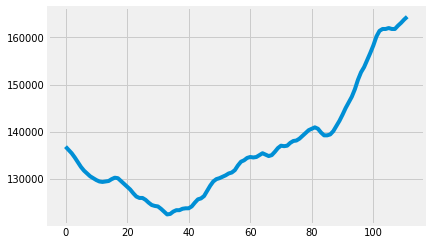

Results of Dickey-Fuller Test:
Test Statistic                   0.275696
p-value                          0.976202
#Lags Used                       3.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
======================== Zipcode: 72714 ========================


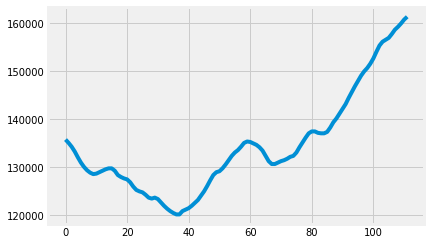

Results of Dickey-Fuller Test:
Test Statistic                   0.181380
p-value                          0.971198
#Lags Used                       3.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
======================== Zipcode: 72719 ========================


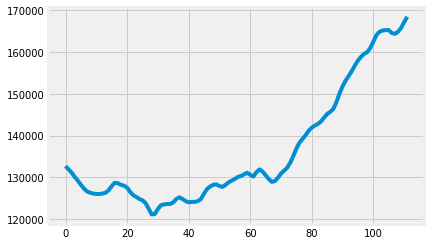

Results of Dickey-Fuller Test:
Test Statistic                   0.975068
p-value                          0.993996
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64
======================== Zipcode: 72745 ========================


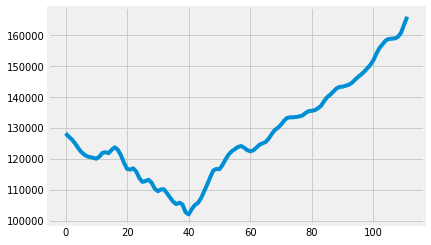

Results of Dickey-Fuller Test:
Test Statistic                   0.881777
p-value                          0.992848
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64
======================== Zipcode: 72730 ========================


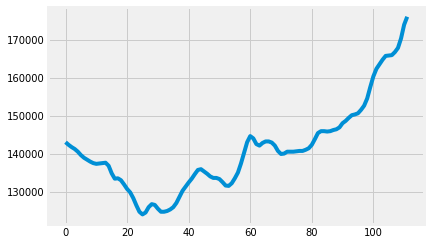

Results of Dickey-Fuller Test:
Test Statistic                  0.711921
p-value                         0.990073
#Lags Used                     13.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64
======================== Zipcode: 72734 ========================


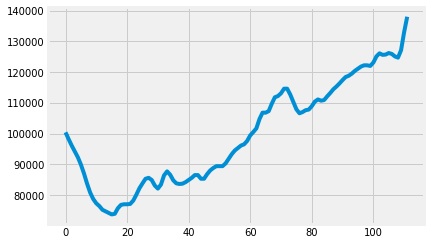

Results of Dickey-Fuller Test:
Test Statistic                  0.635847
p-value                         0.988467
#Lags Used                     13.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64
======================== Zipcode: 72751 ========================


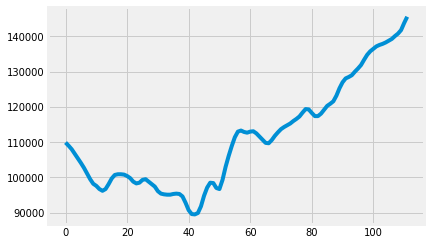

Results of Dickey-Fuller Test:
Test Statistic                   0.554498
p-value                          0.986439
#Lags Used                       5.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
======================== Zipcode: 72774 ========================


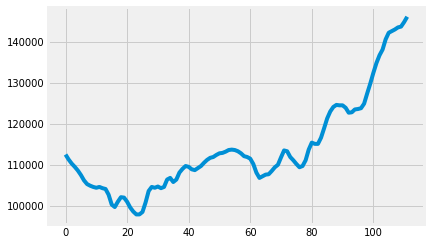

Results of Dickey-Fuller Test:
Test Statistic                   0.819484
p-value                          0.991944
#Lags Used                       5.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
======================== Zipcode: 72727 ========================


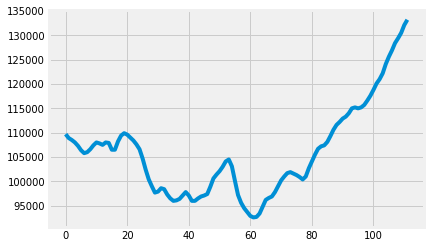

Results of Dickey-Fuller Test:
Test Statistic                   0.656710
p-value                          0.988933
#Lags Used                       6.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64
======================== Zipcode: 72732 ========================


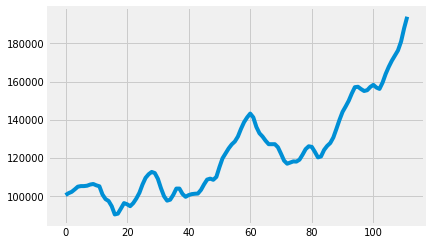

Results of Dickey-Fuller Test:
Test Statistic                   1.694343
p-value                          0.998115
#Lags Used                      11.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
======================== Zipcode: 72718 ========================


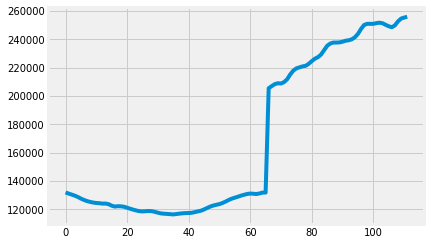

Results of Dickey-Fuller Test:
Test Statistic                   0.100284
p-value                          0.966081
#Lags Used                       0.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64
======================== Zipcode: 72722 ========================


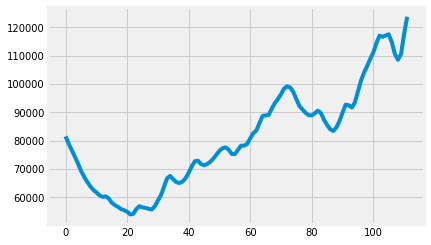

Results of Dickey-Fuller Test:
Test Statistic                 -0.052455
p-value                         0.953973
#Lags Used                     12.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [33]:
for i in zips_focused_indicies:
    print('================================================================')
    print('========================', 'Zipcode:', zips_focused['RegionName'].loc[i], '========================')
    zips_melted = melt_data(zips_focused.loc[[i]])
    data = np.concatenate(zips_melted.values, axis=None)
    dftest = adfuller(data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    data_plot = pd.Series(data)
    data_plot.plot()
    plt.show()
    print ('Results of Dickey-Fuller Test:')
    print(dfoutput)

Every zipcode displays non-staitionarity. Staitionary will be addressed with I in SARIMA model.

In [34]:
#AR/MA/I parameter for modeling

In [35]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

=================================== 72712 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1358.74
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

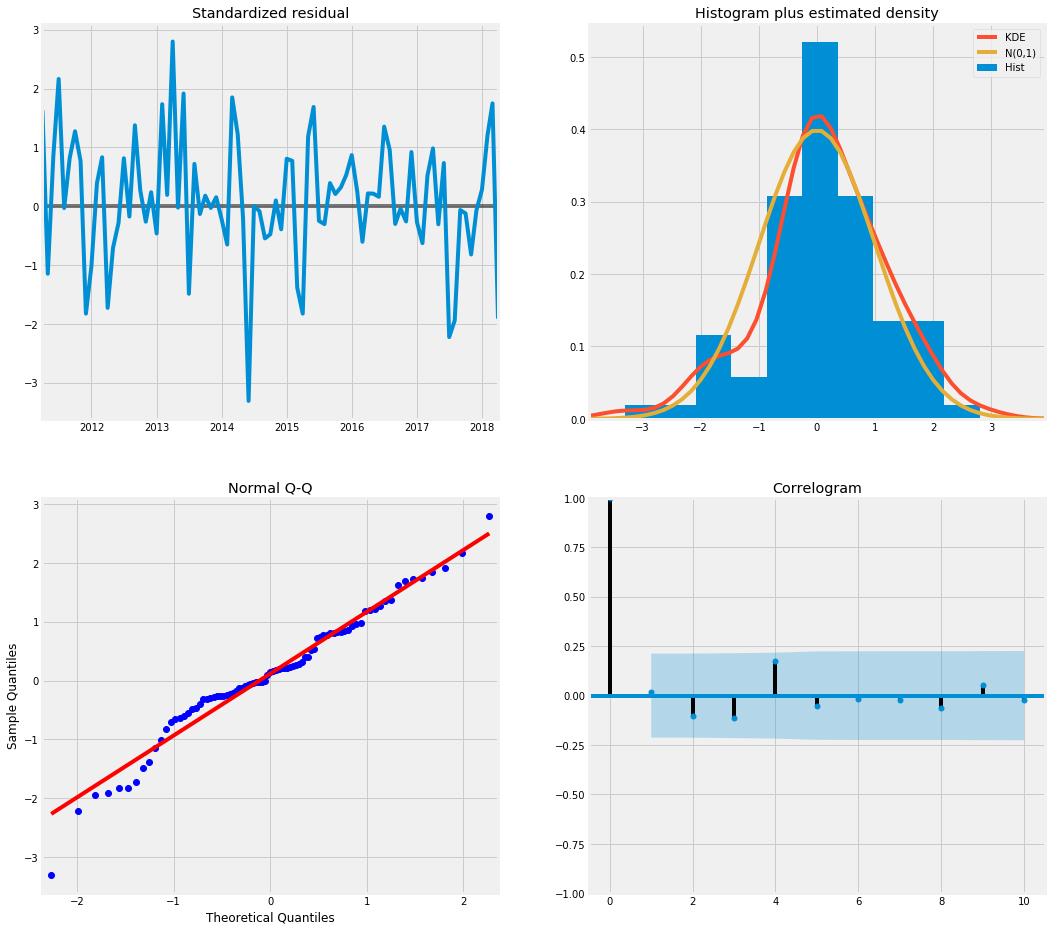

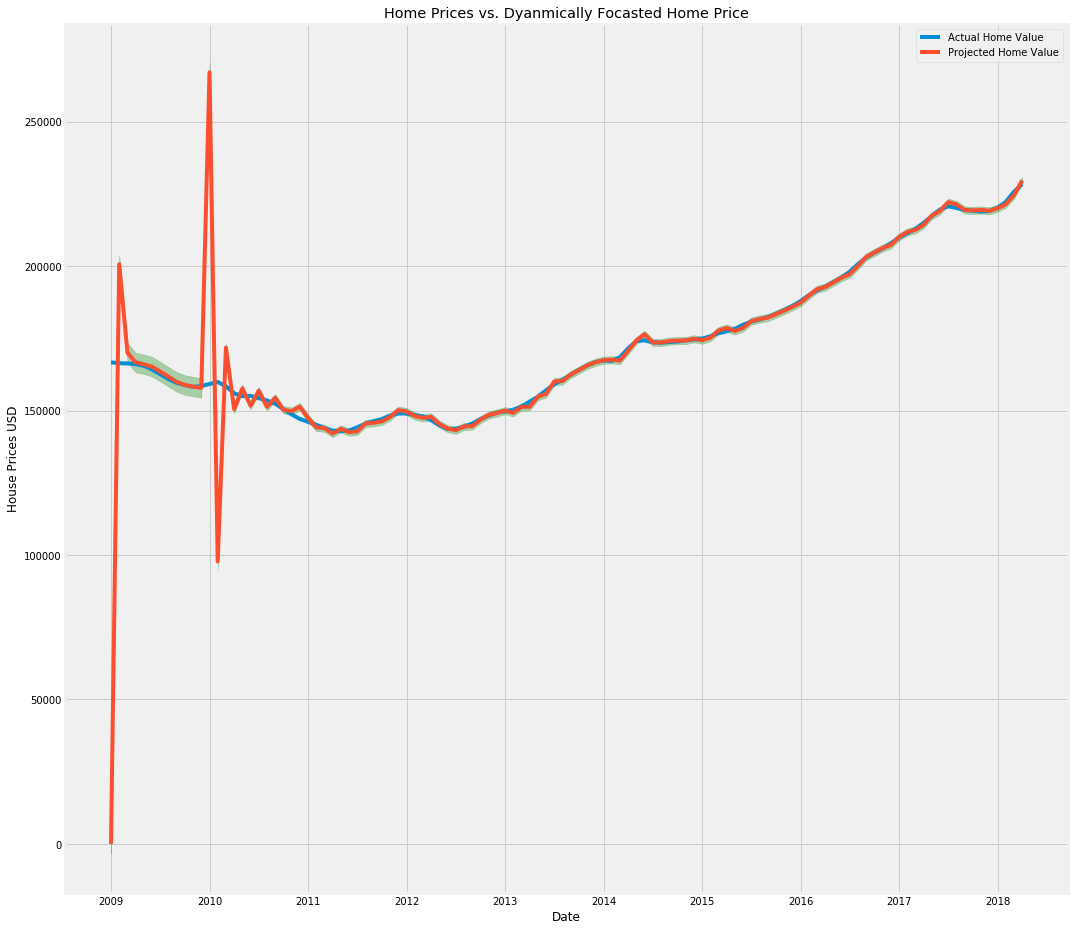

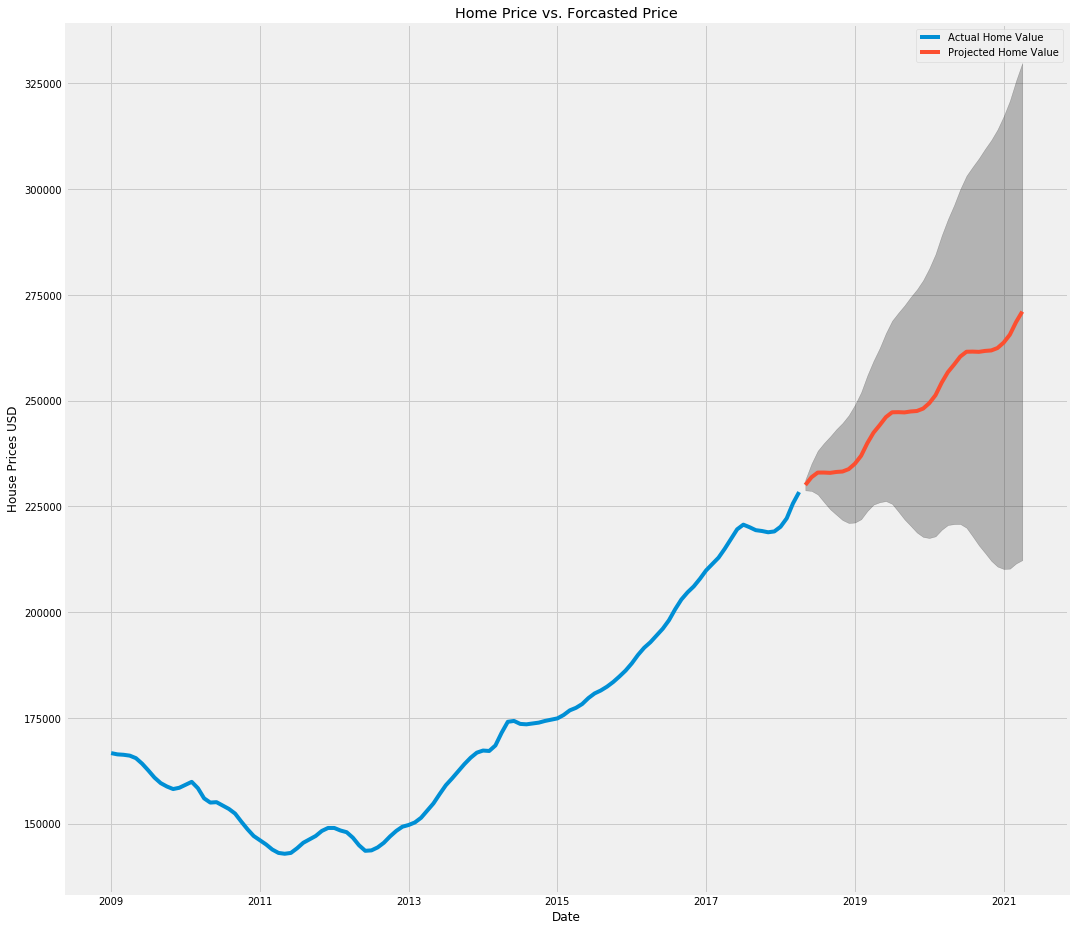

72712 ROI: 17.815416801092148
=================================== 72701 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1344.37
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

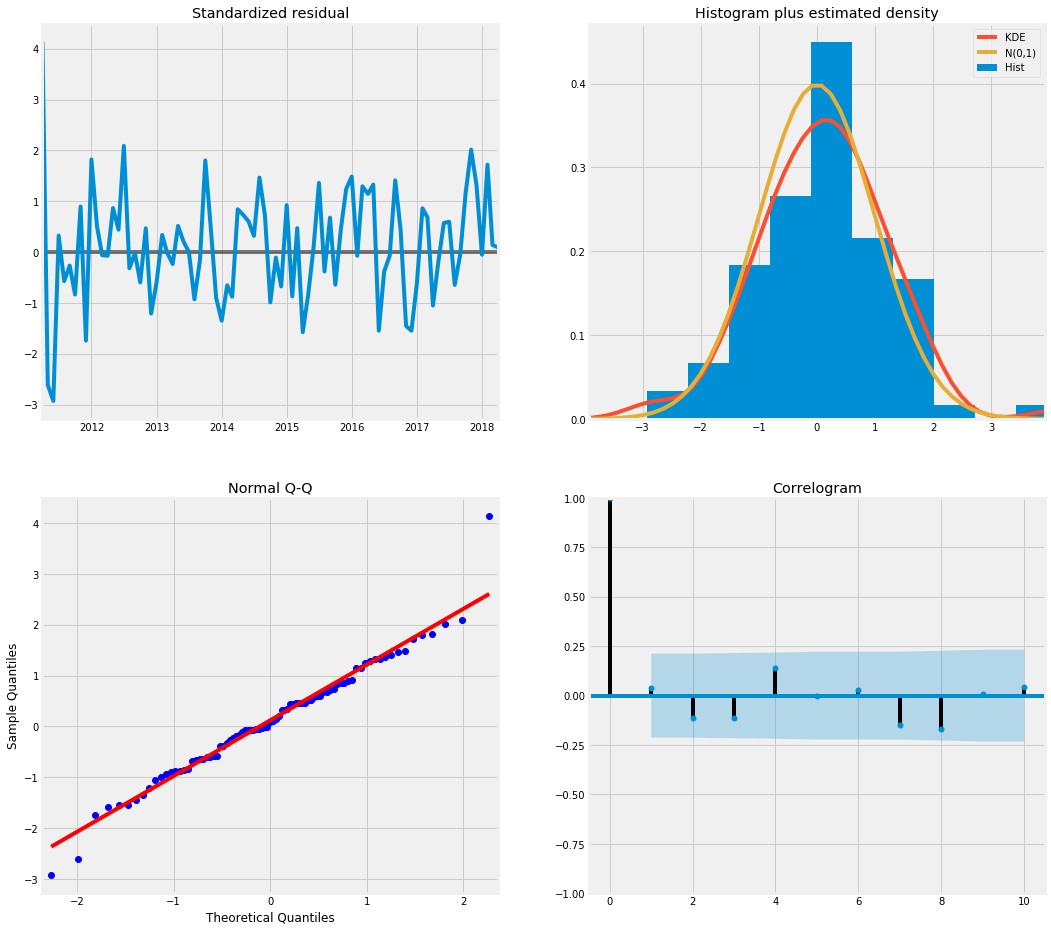

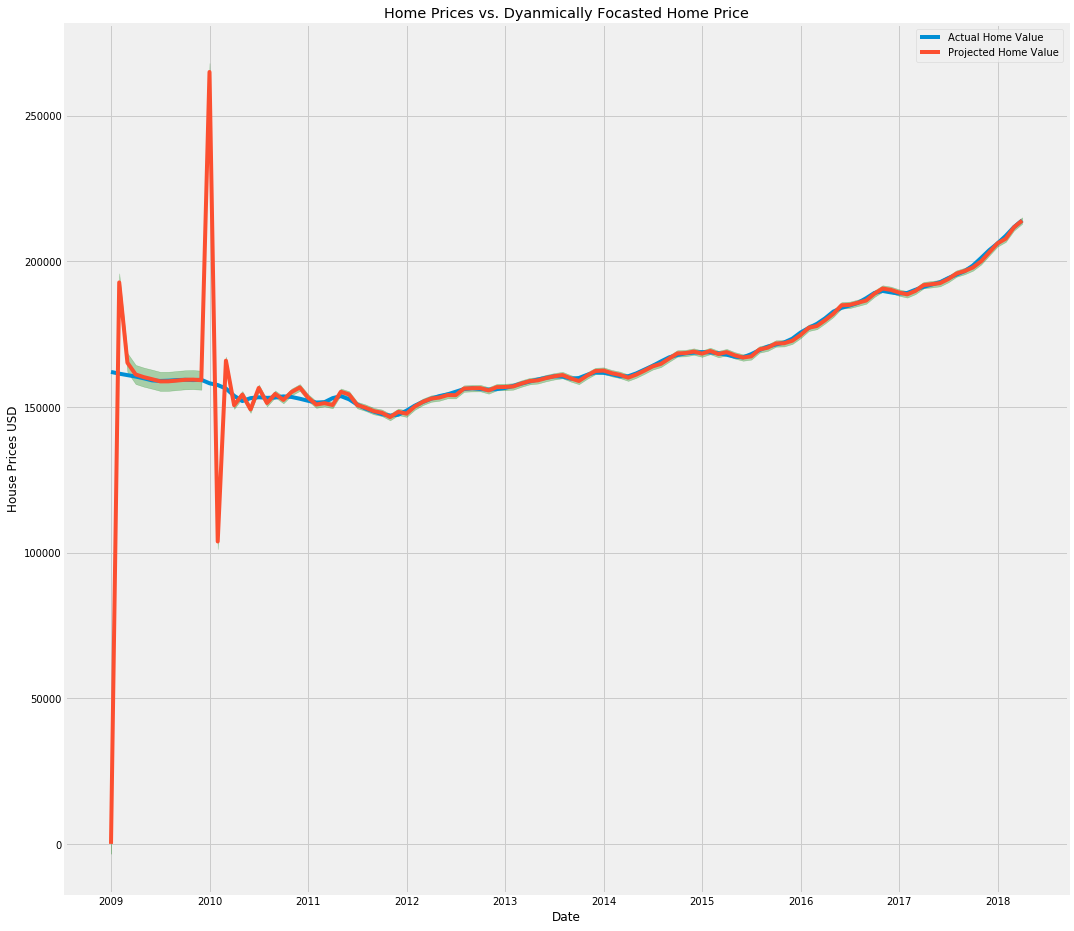

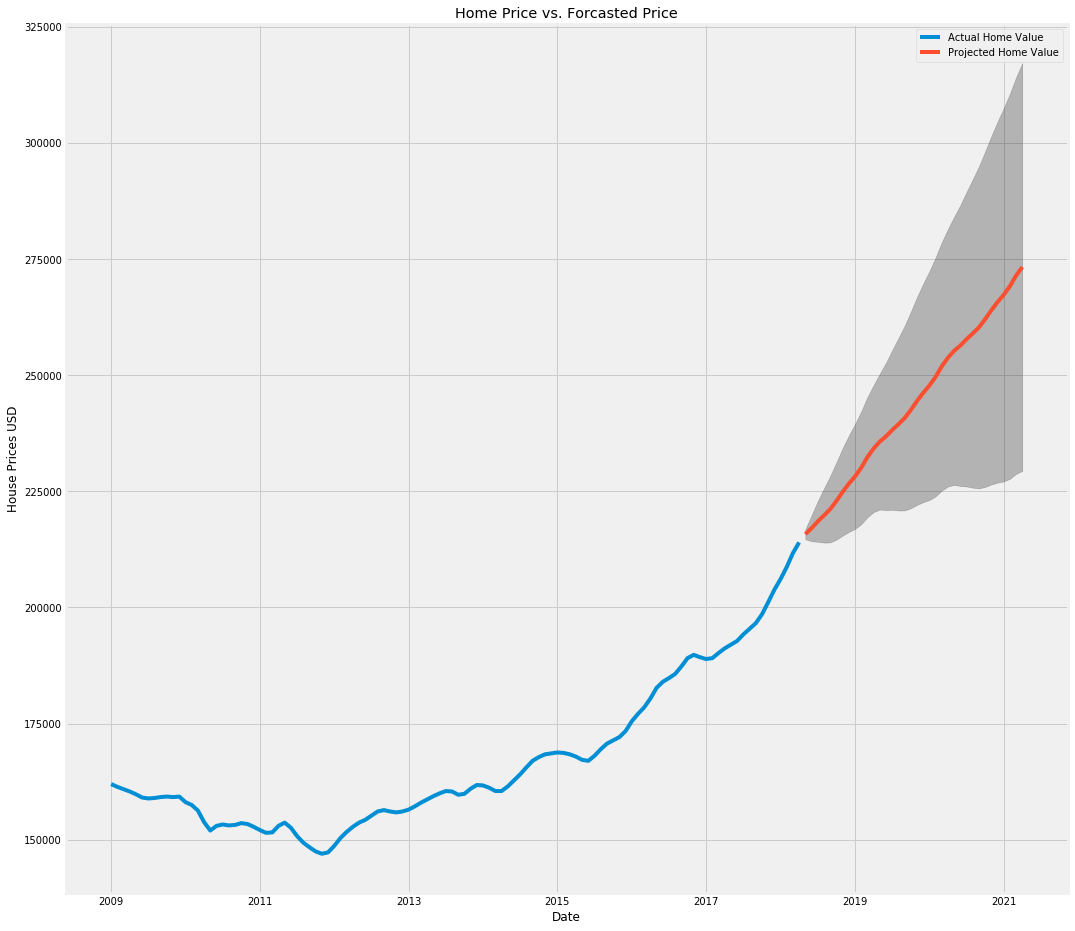

72701 ROI: 26.642995876164054
=================================== 72764 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1288.93
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

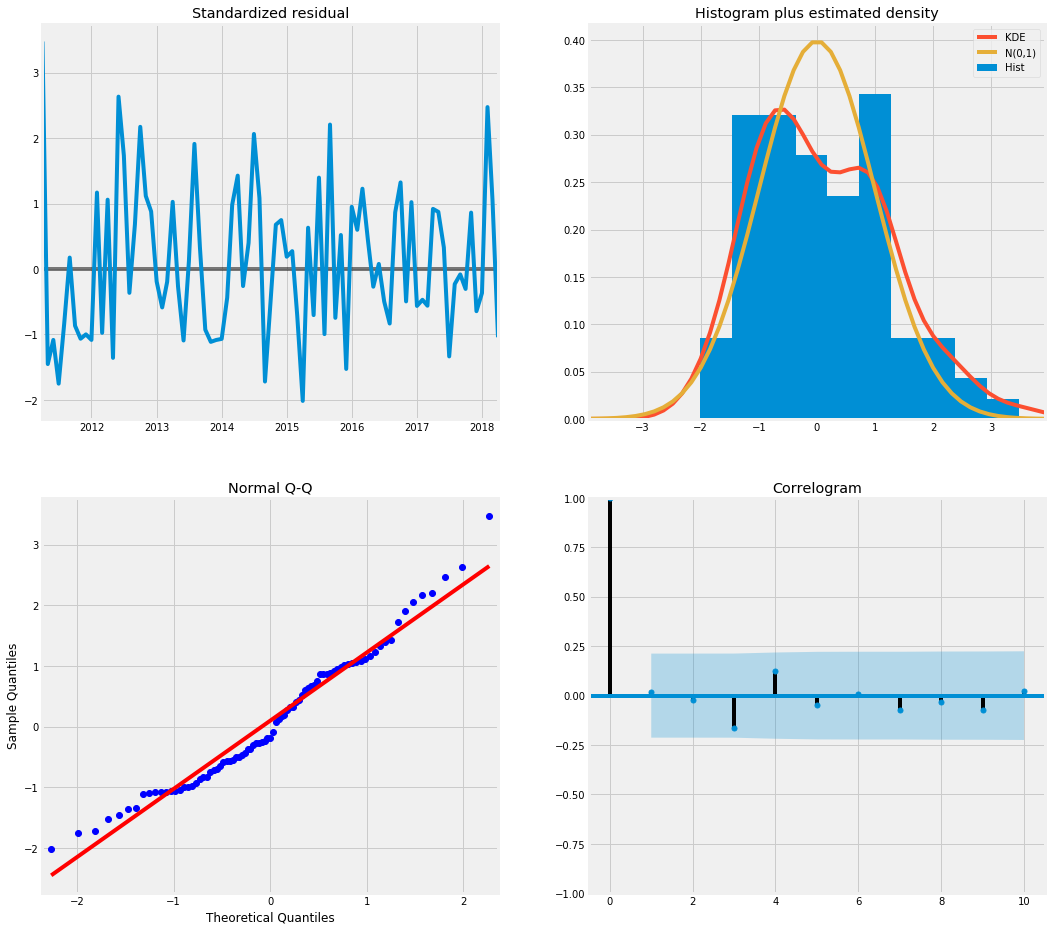

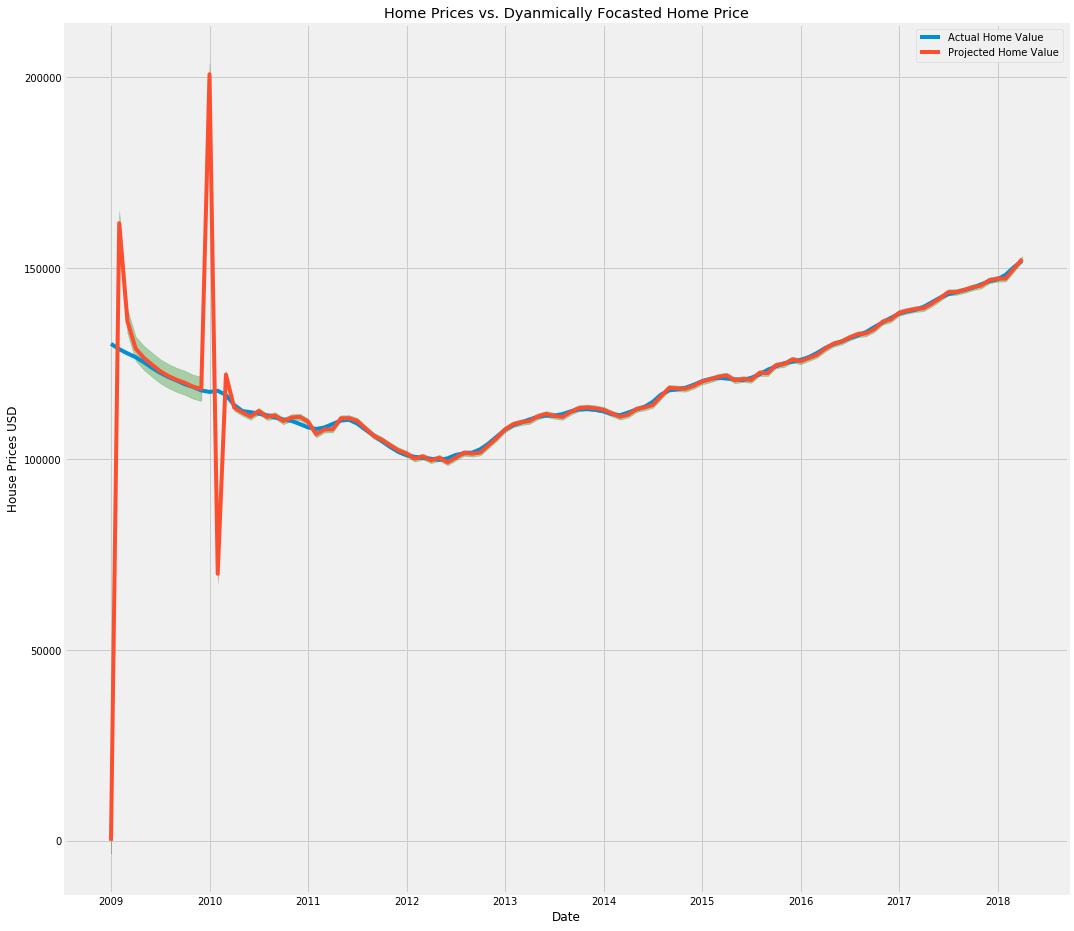

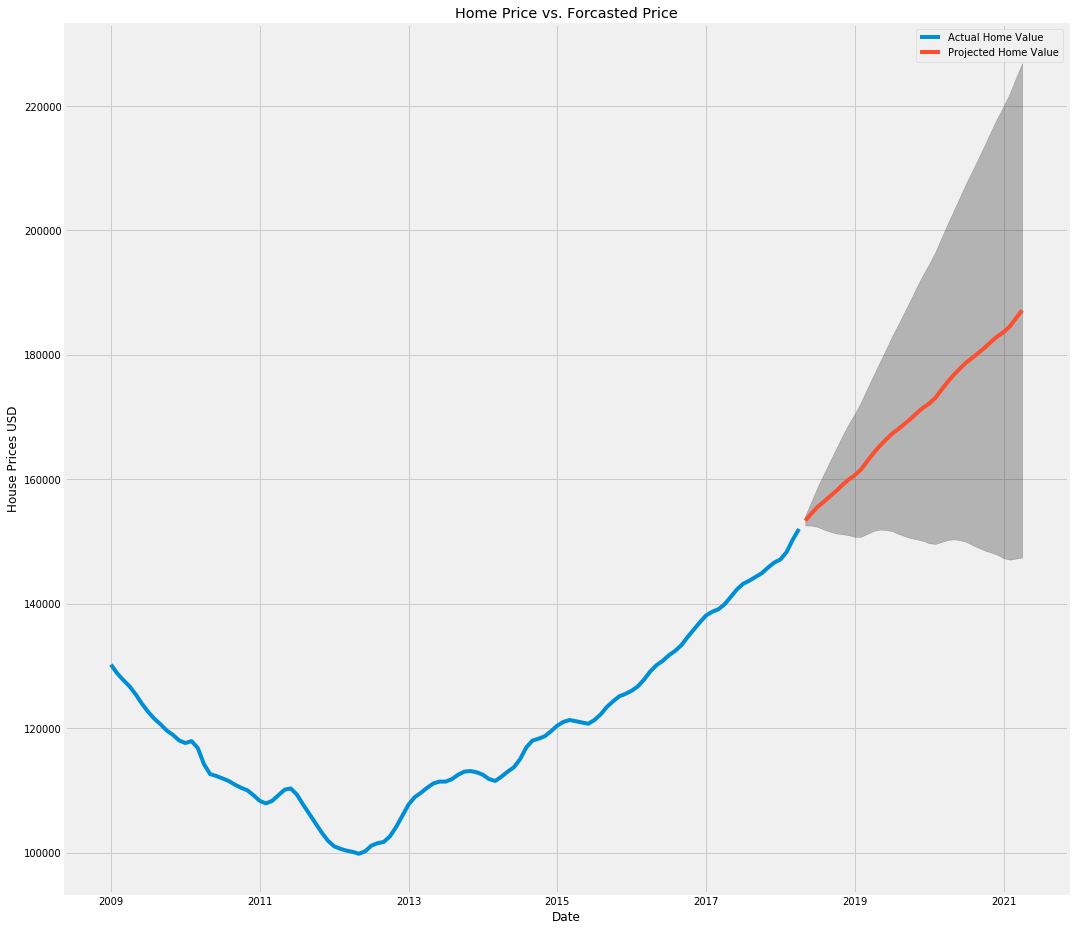

72764 ROI: 22.042154093486076
=================================== 72756 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1283.82
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

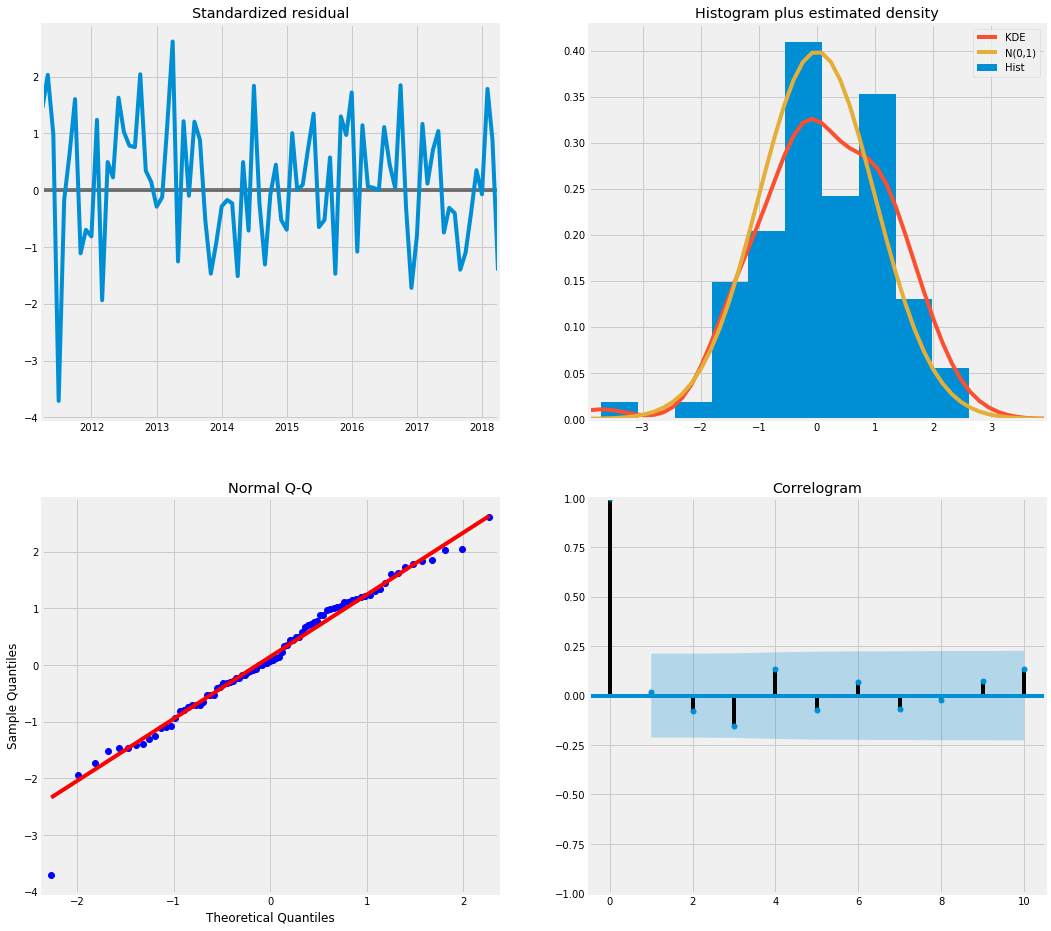

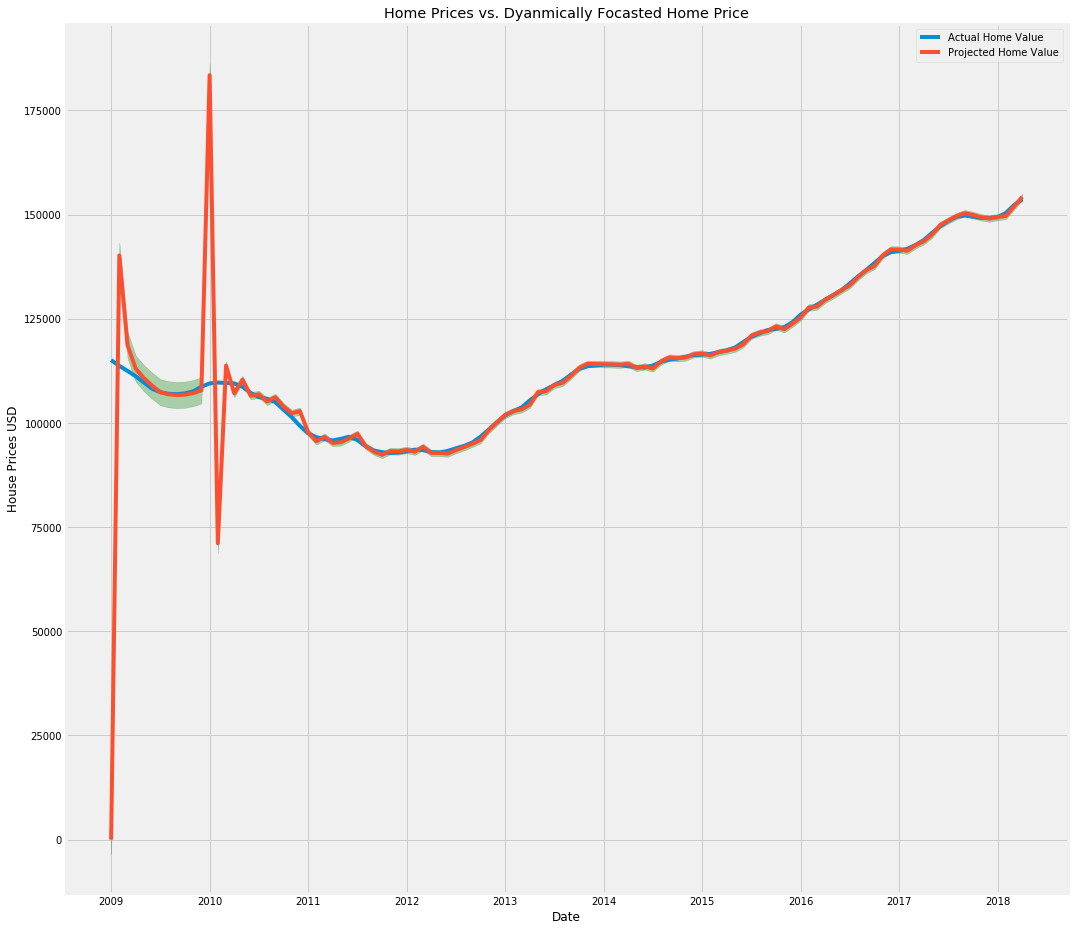

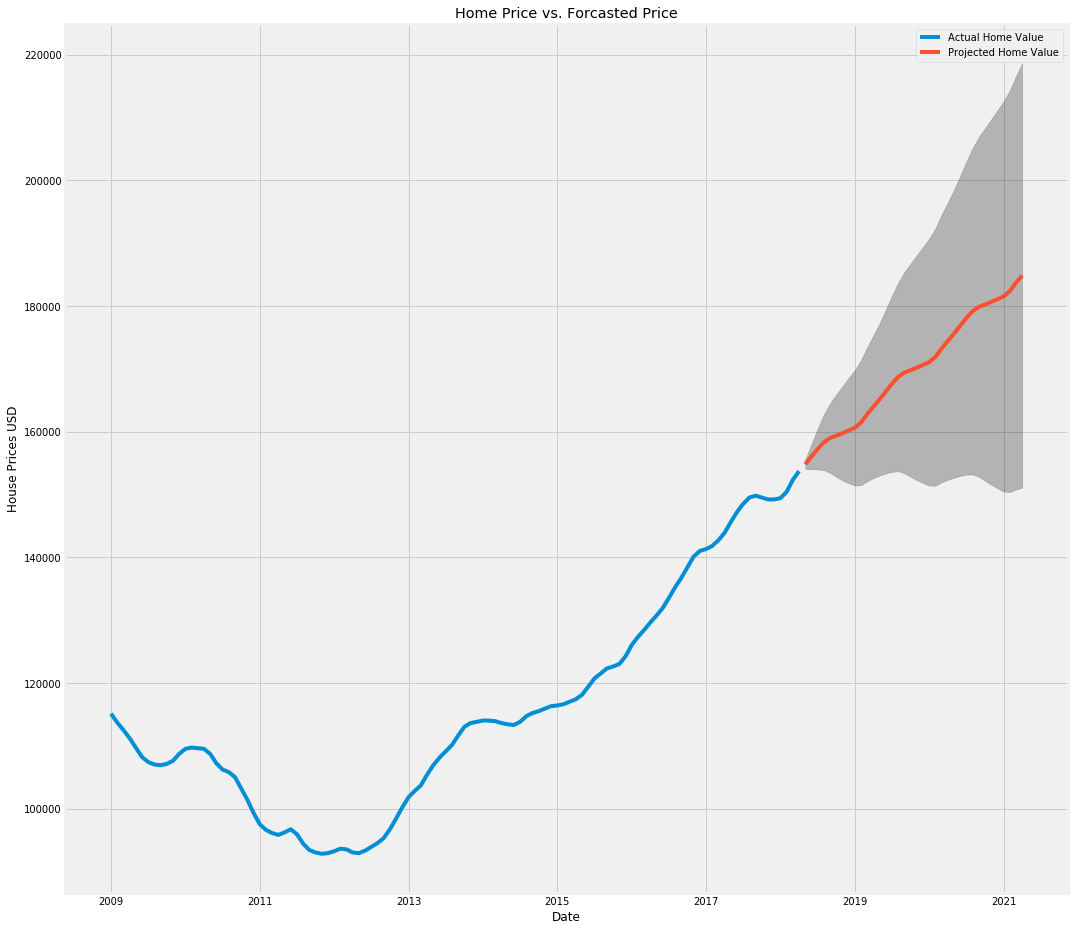

72756 ROI: 19.414592913194635
=================================== 72703 ===================================


pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic            1346.7
Name: 63, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

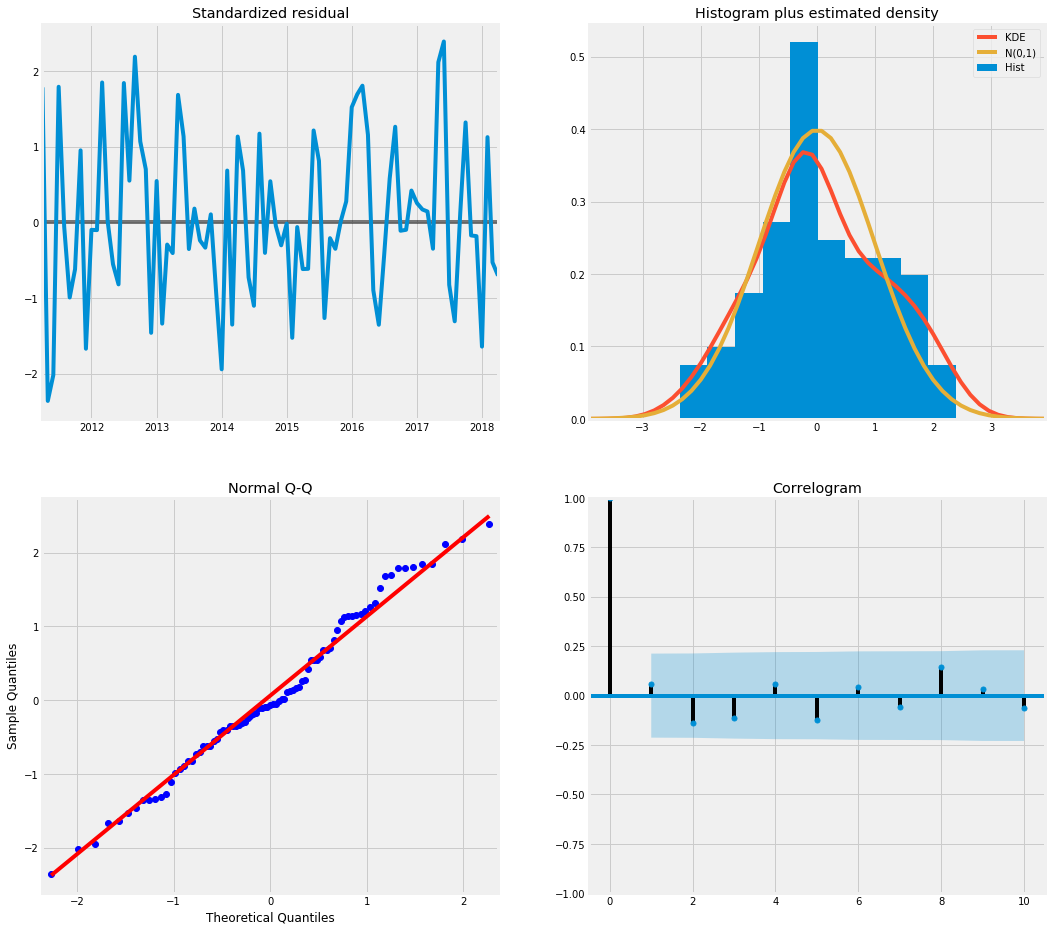

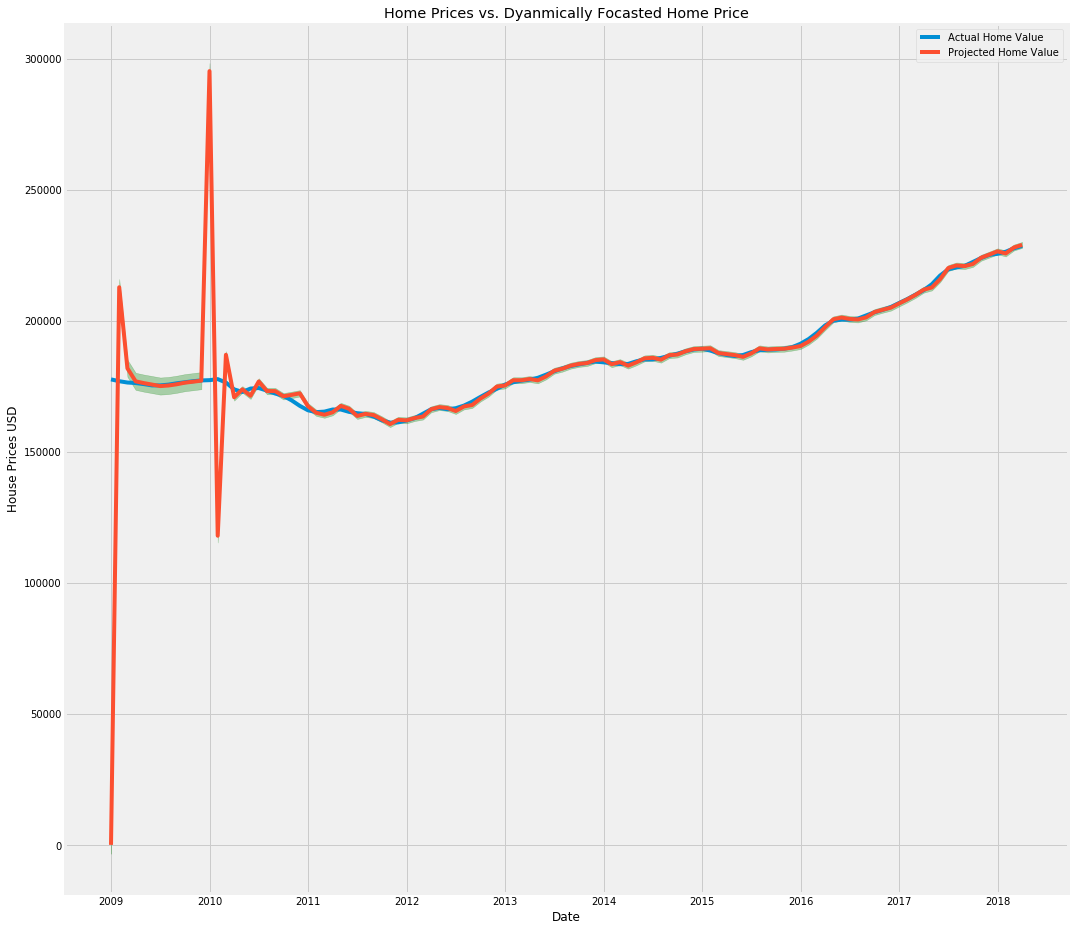

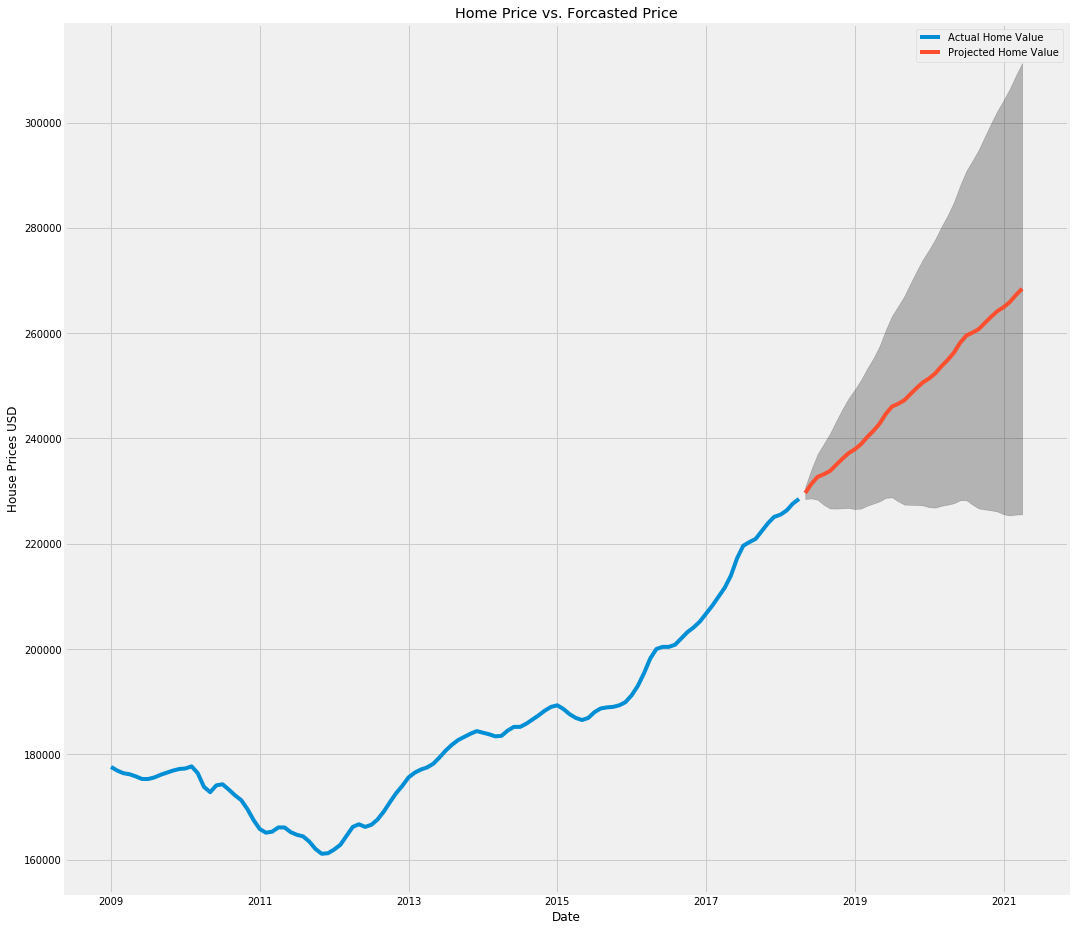

72703 ROI: 16.899979626946926
=================================== 72758 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1405.65
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

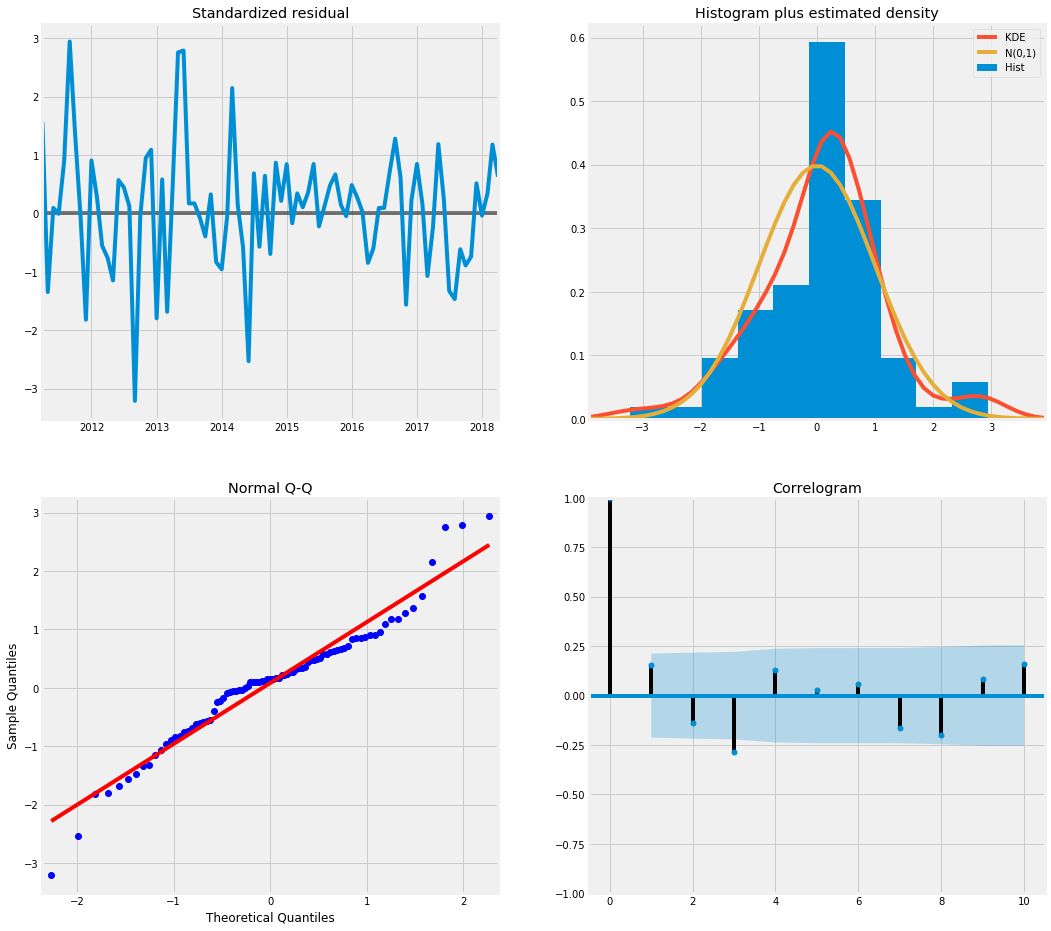

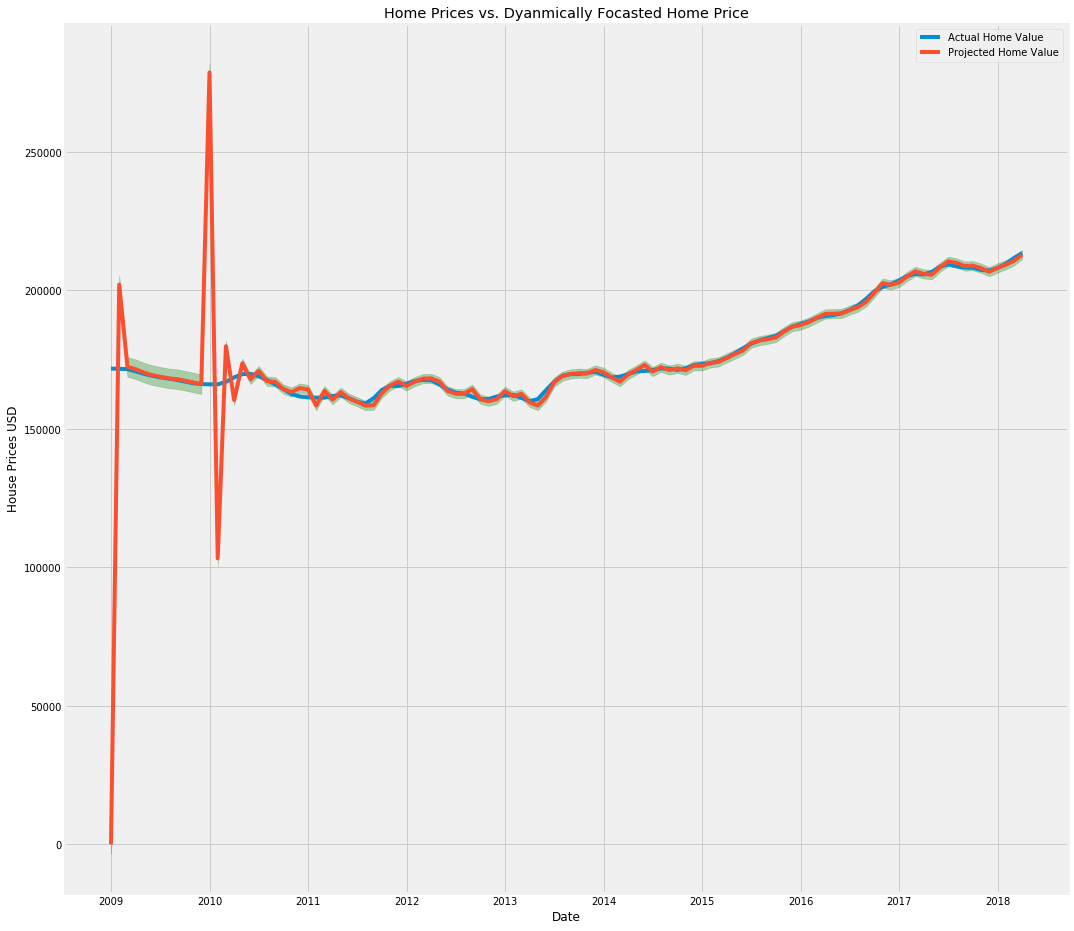

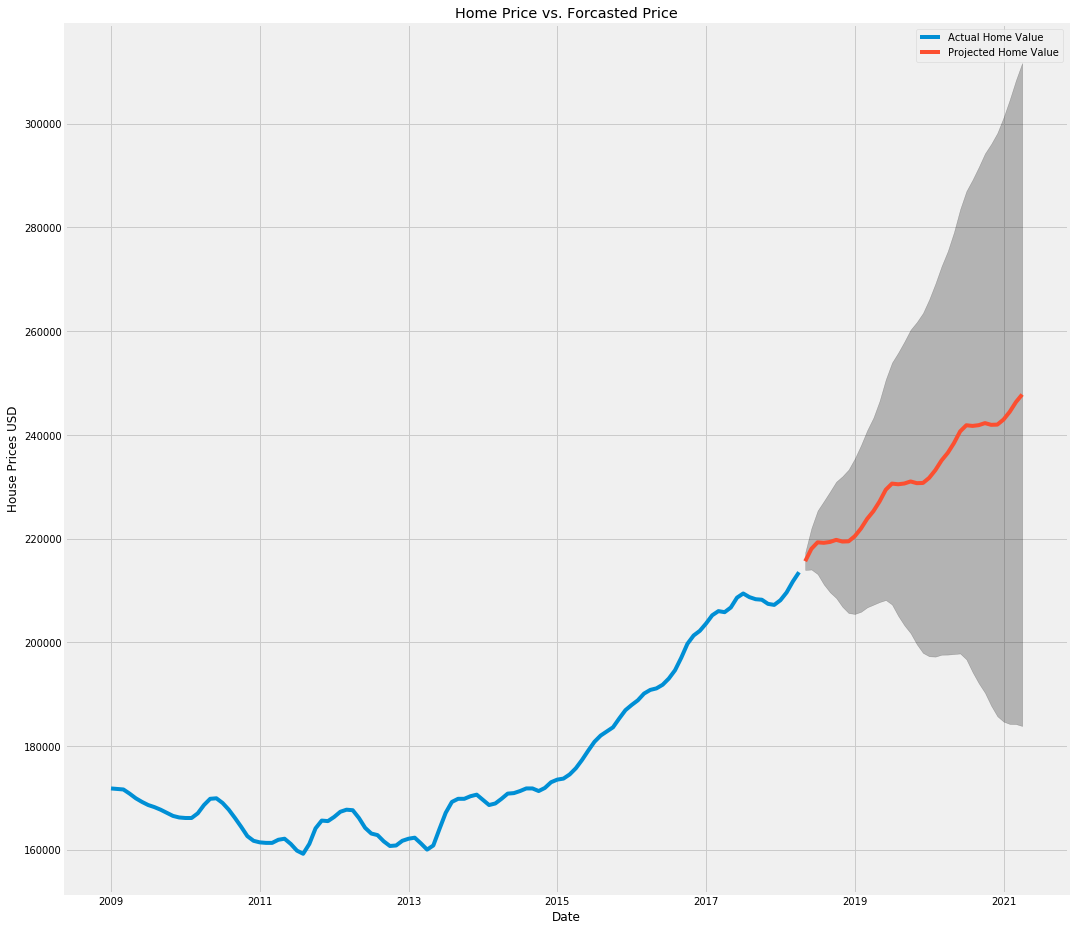

72758 ROI: 14.911307182341687
=================================== 72762 ===================================


pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1302.01
Name: 63, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

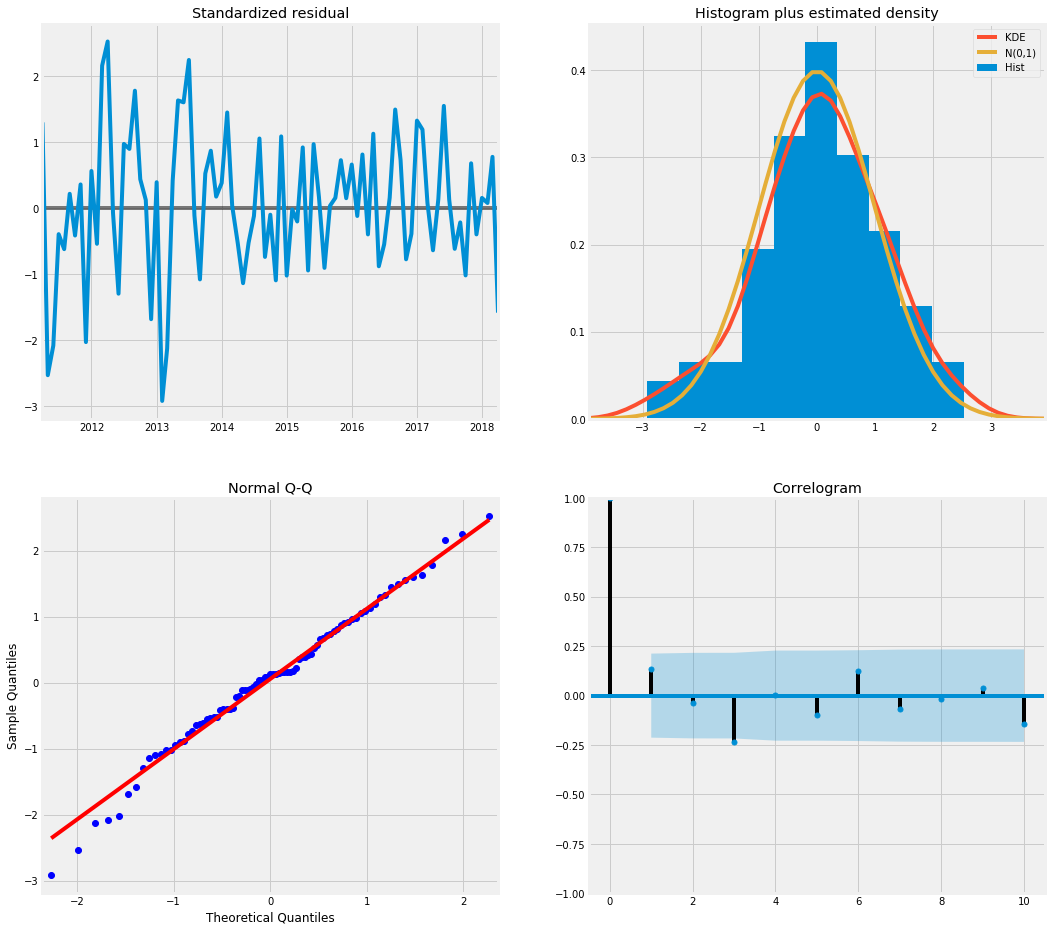

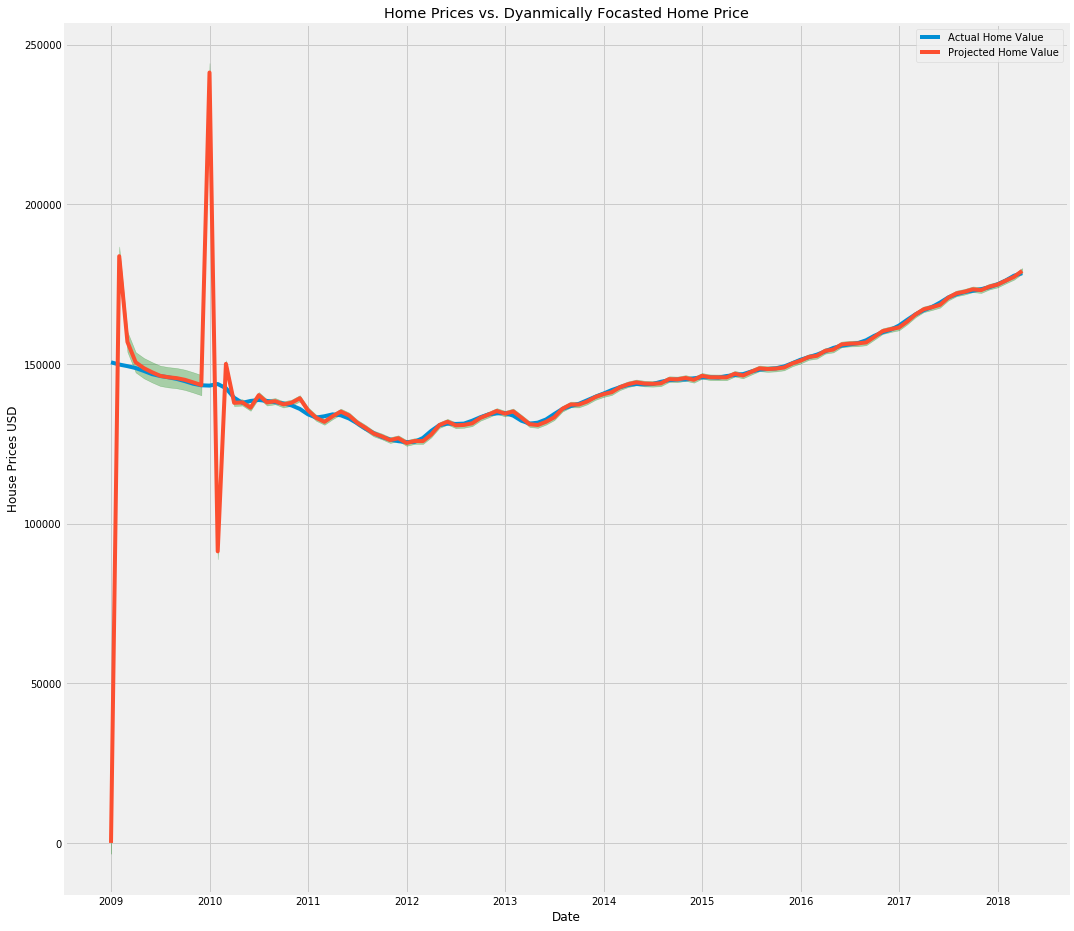

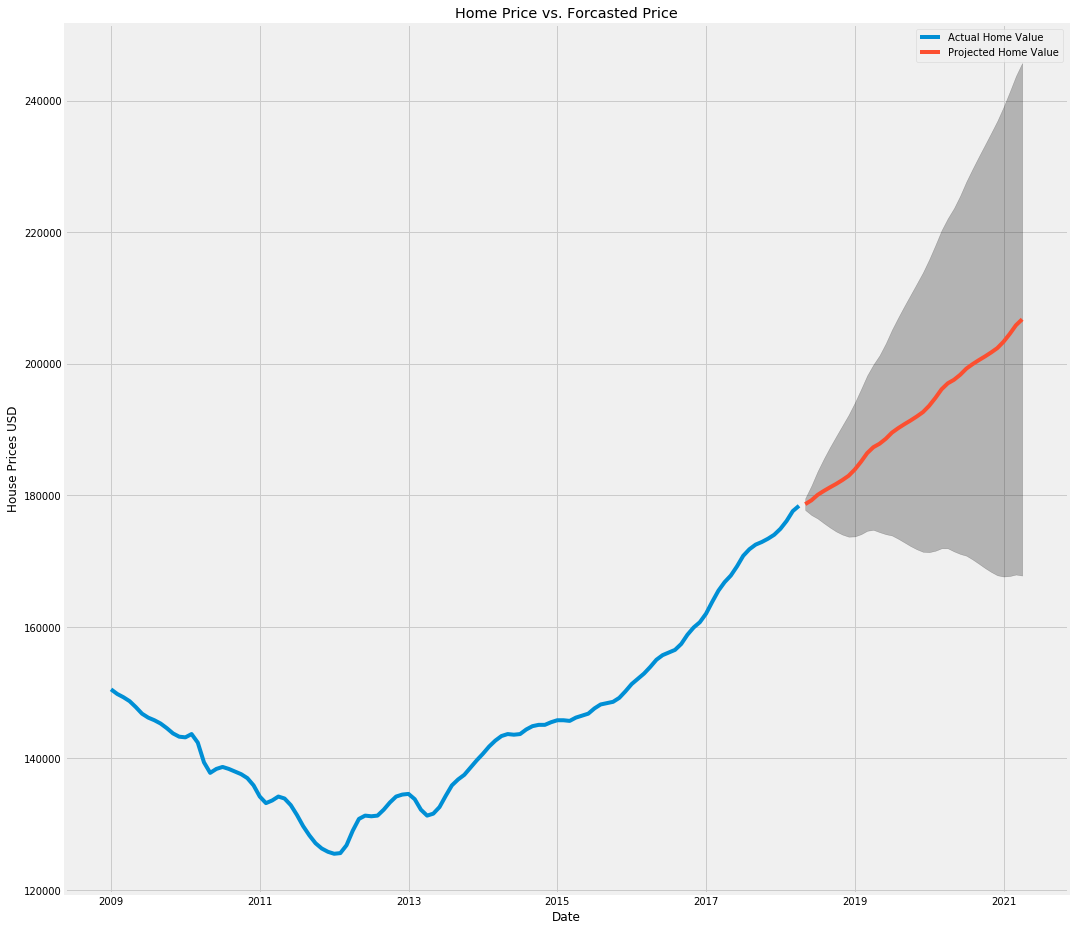

72762 ROI: 15.730280246650649
=================================== 72704 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1272.64
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

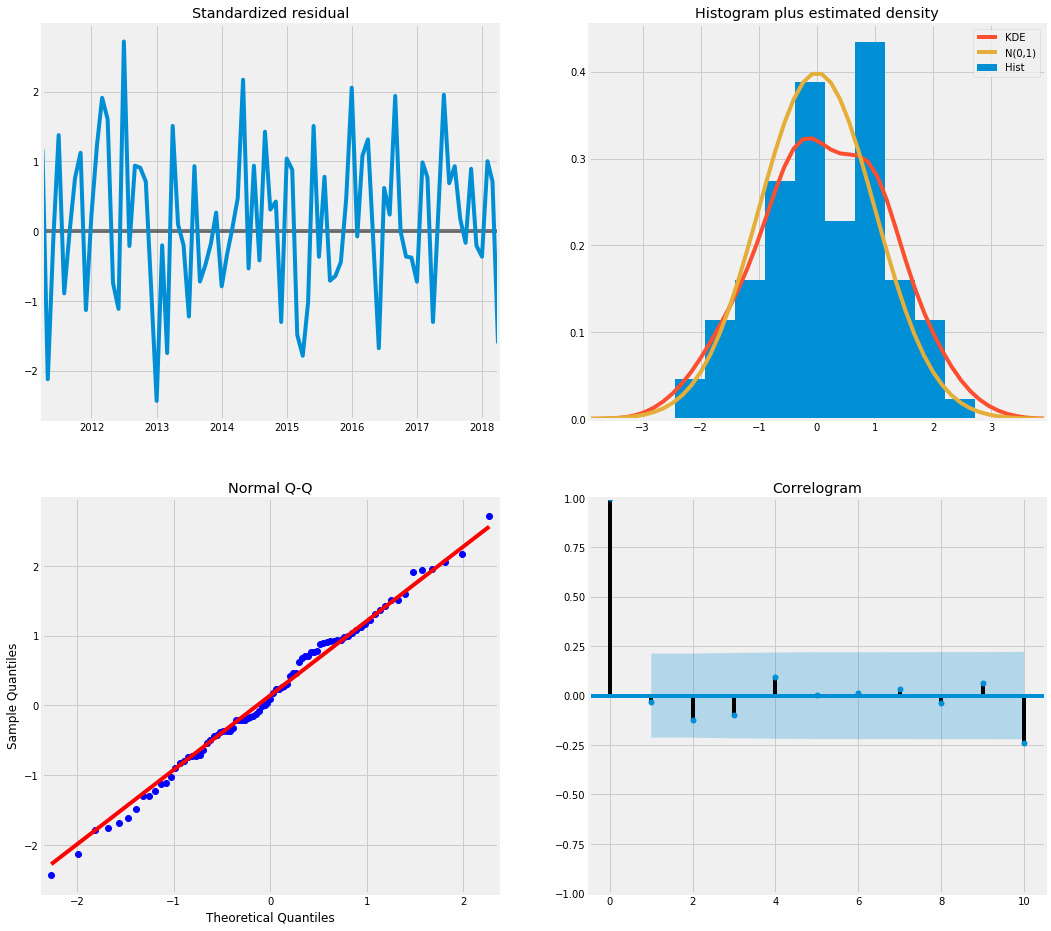

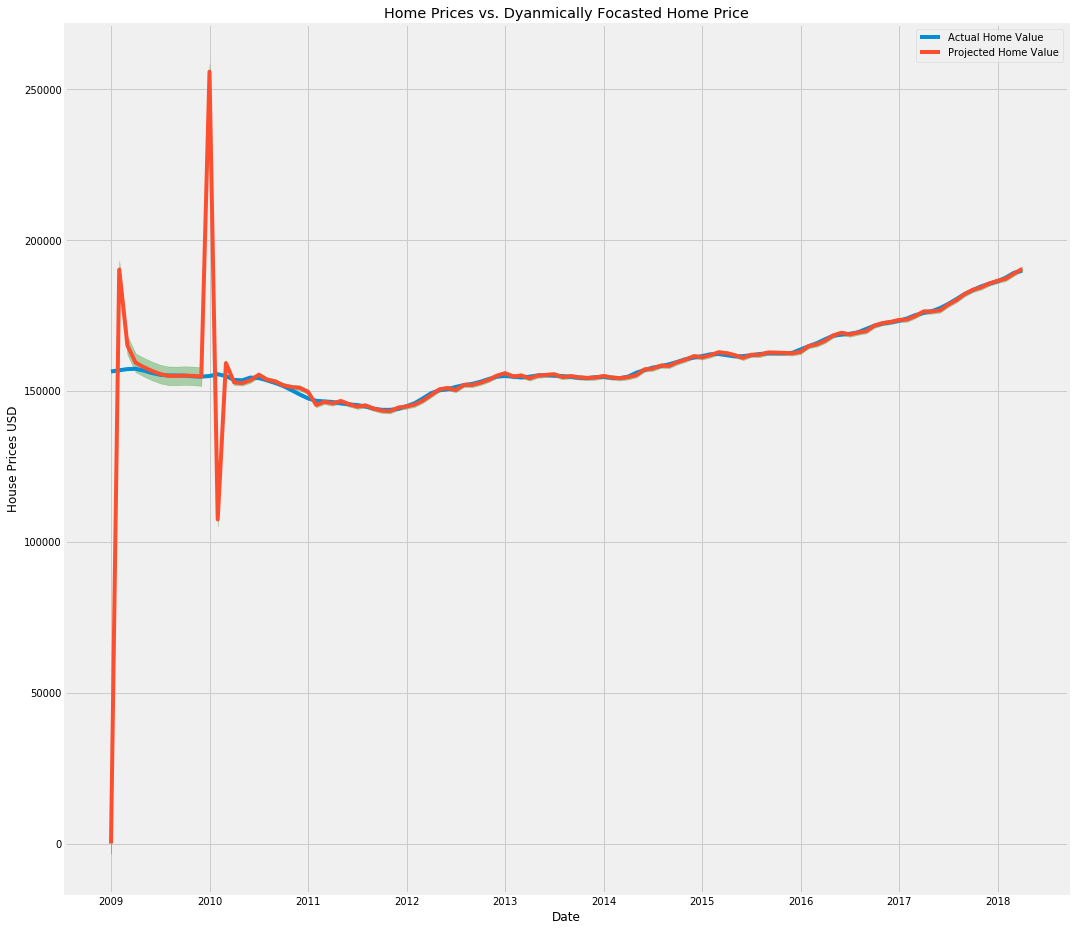

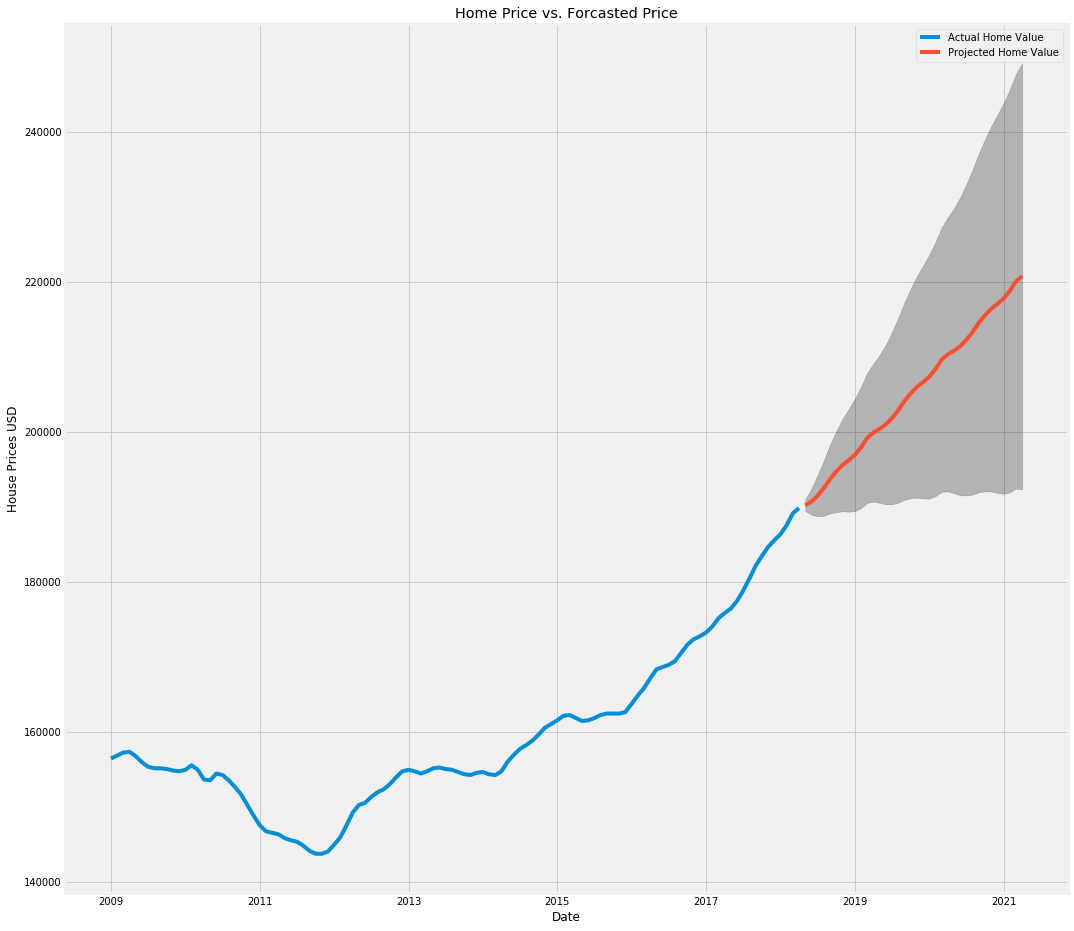

72704 ROI: 16.074227729863217
=================================== 72761 ===================================


pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1329.92
Name: 63, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

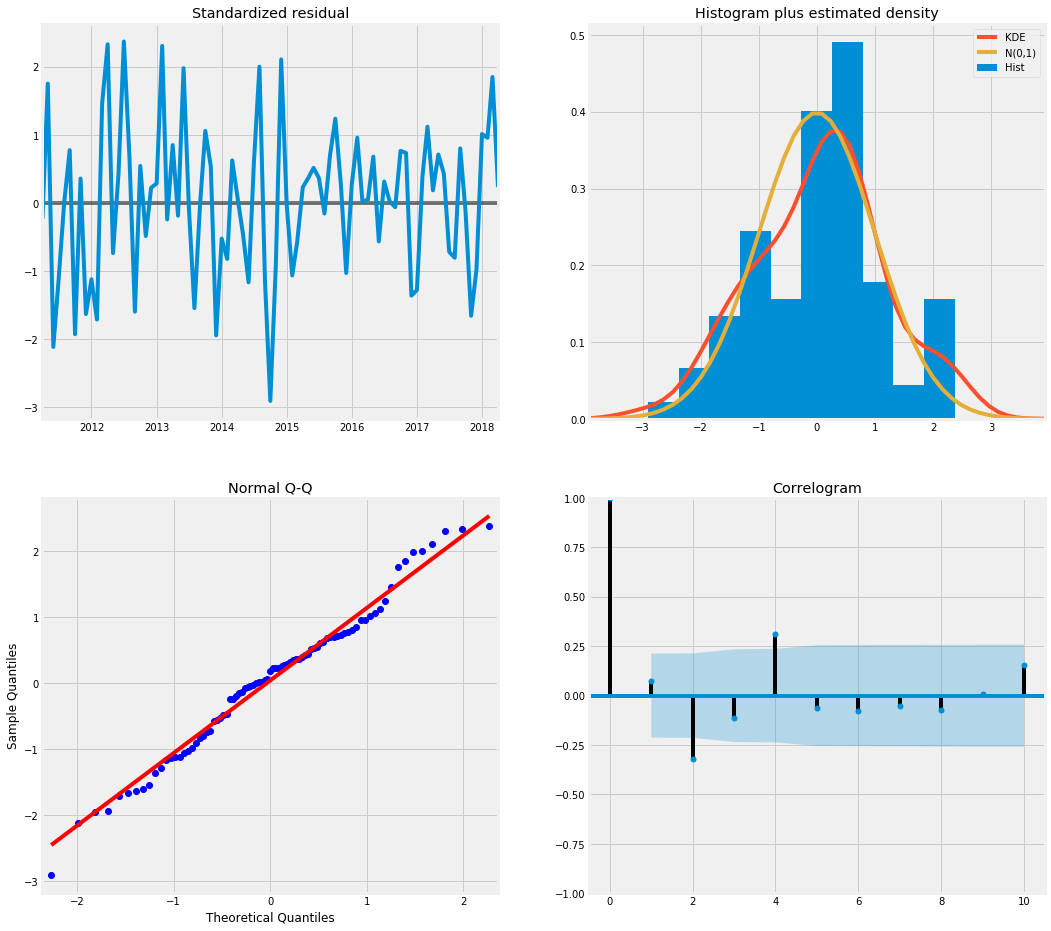

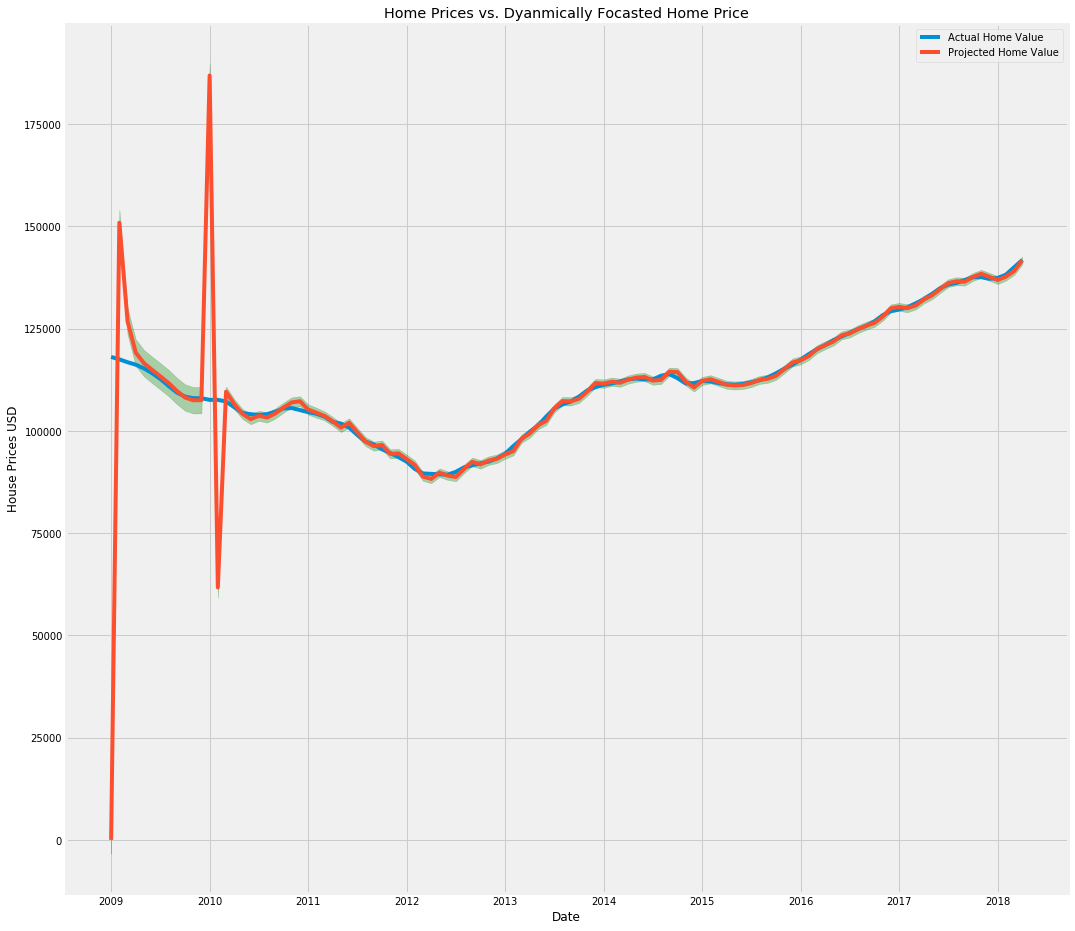

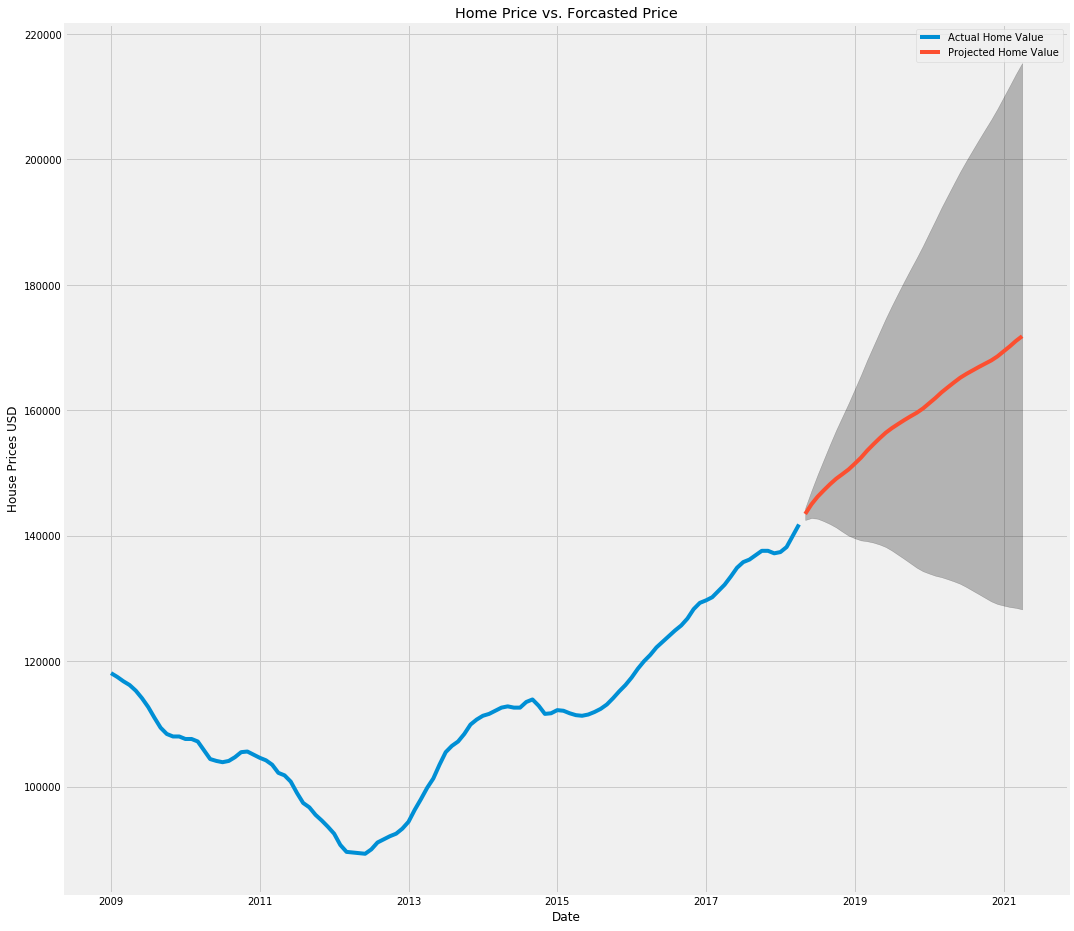

72761 ROI: 19.75199984057899
=================================== 72715 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1256.66
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

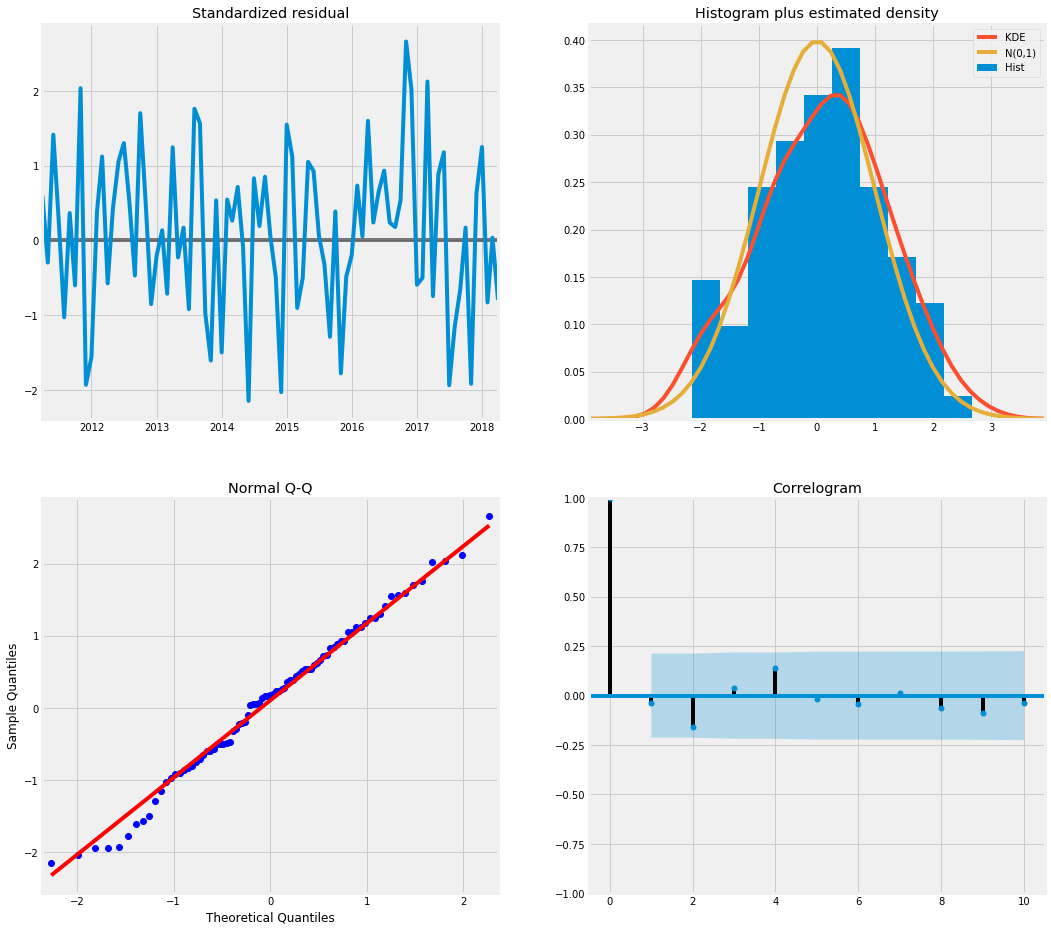

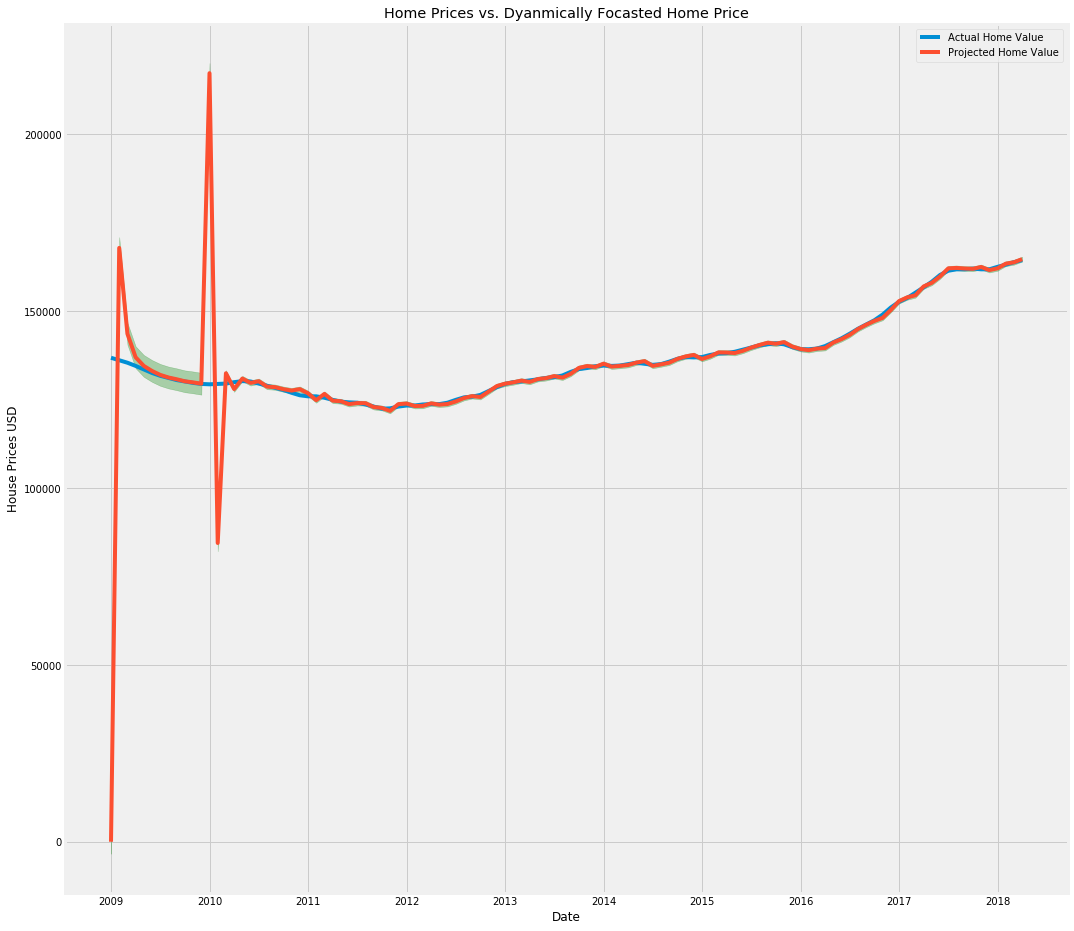

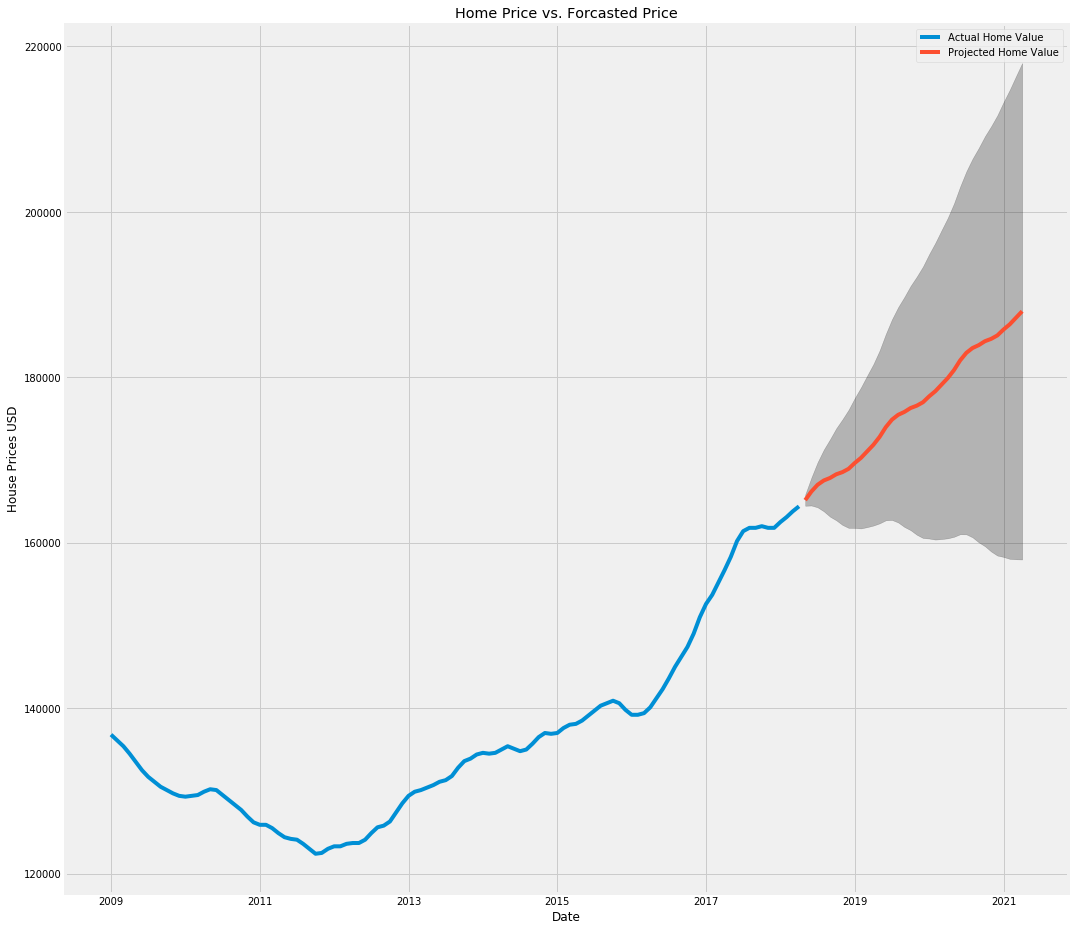

72715 ROI: 13.824536232341186
=================================== 72714 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1234.96
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

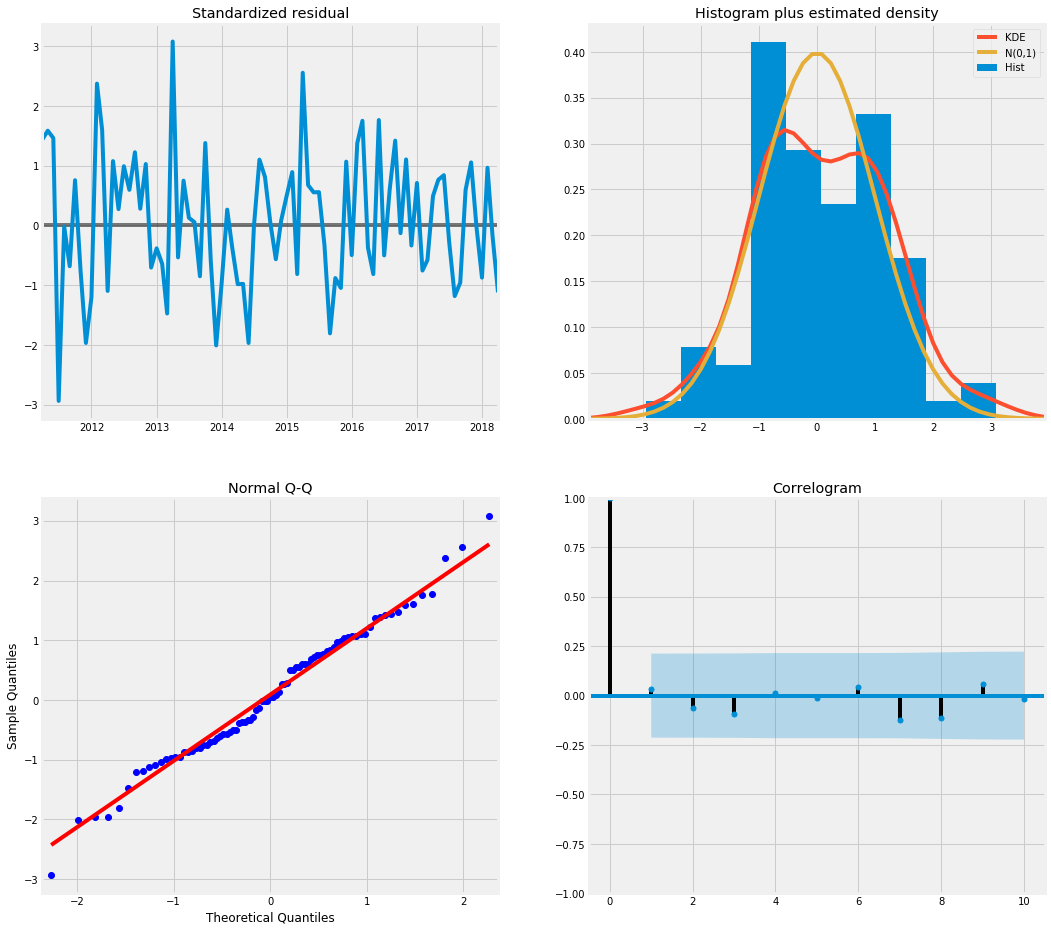

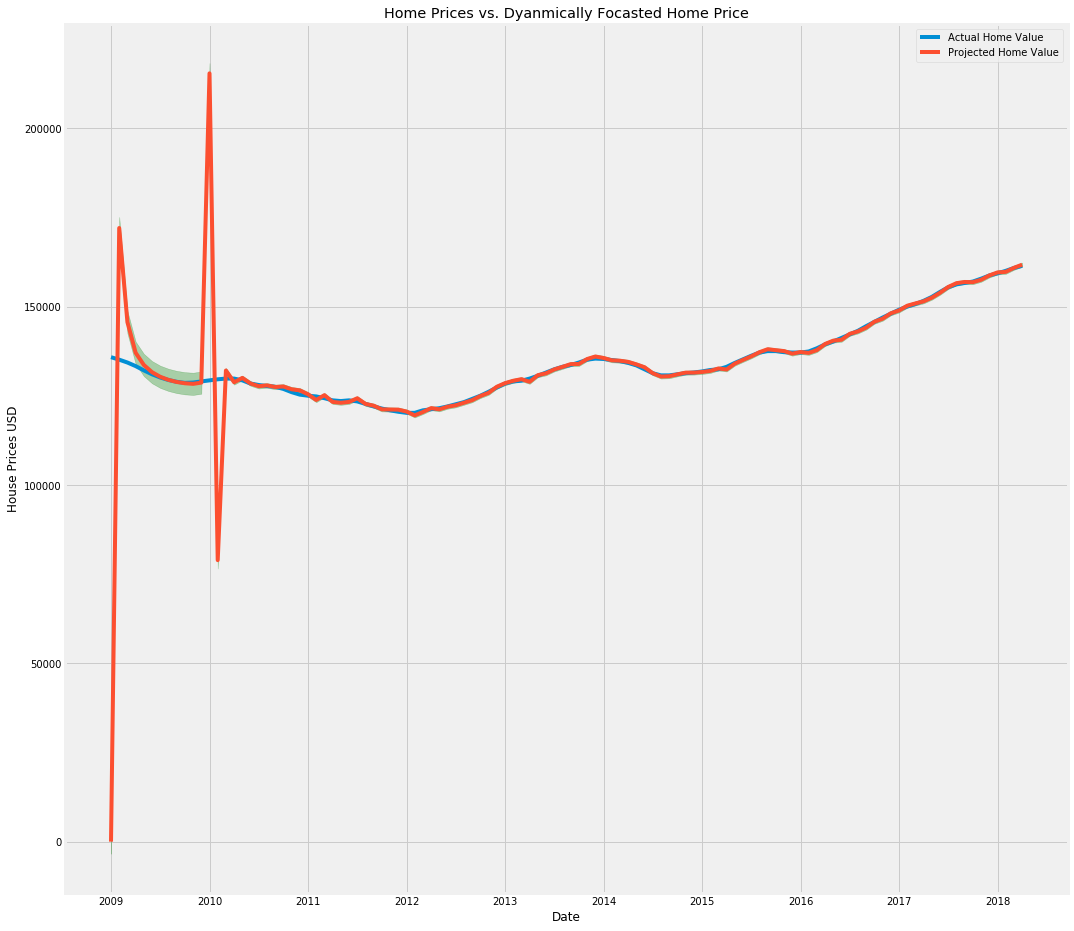

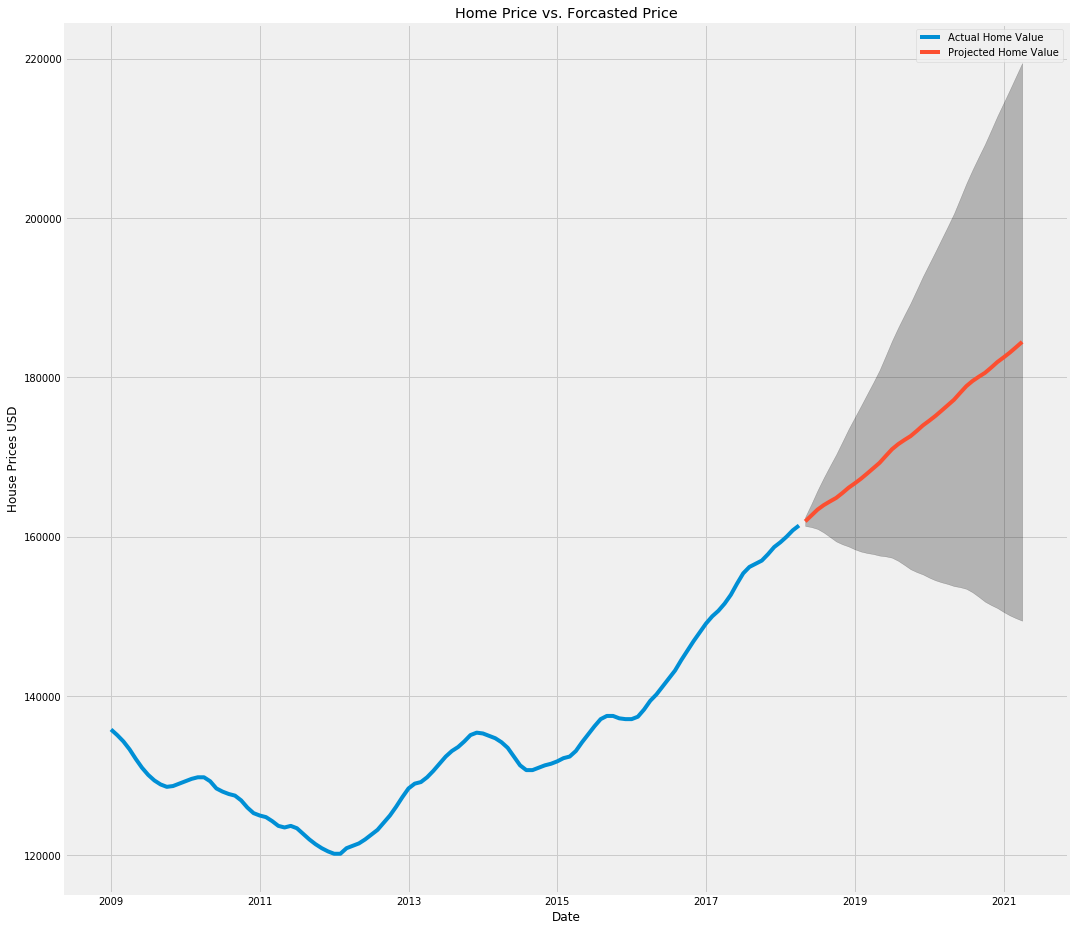

72714 ROI: 13.914027330380478
=================================== 72719 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1300.77
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

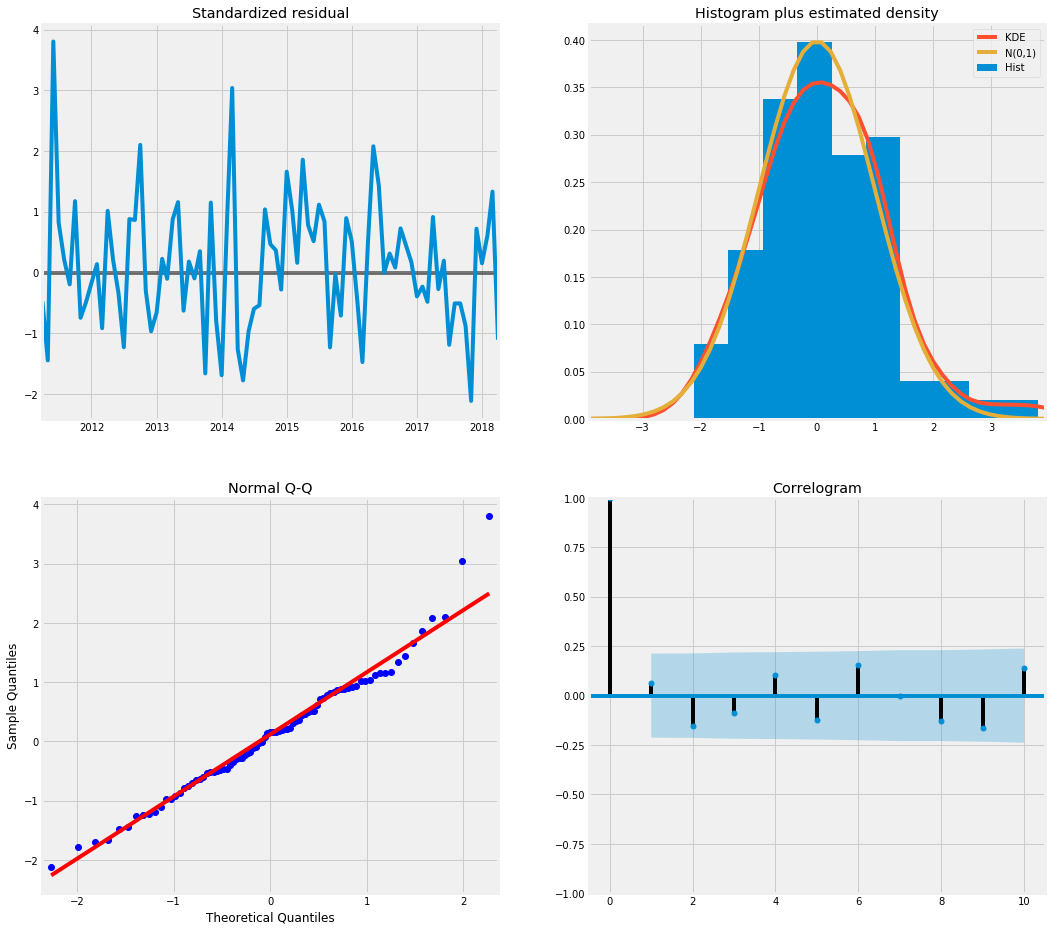

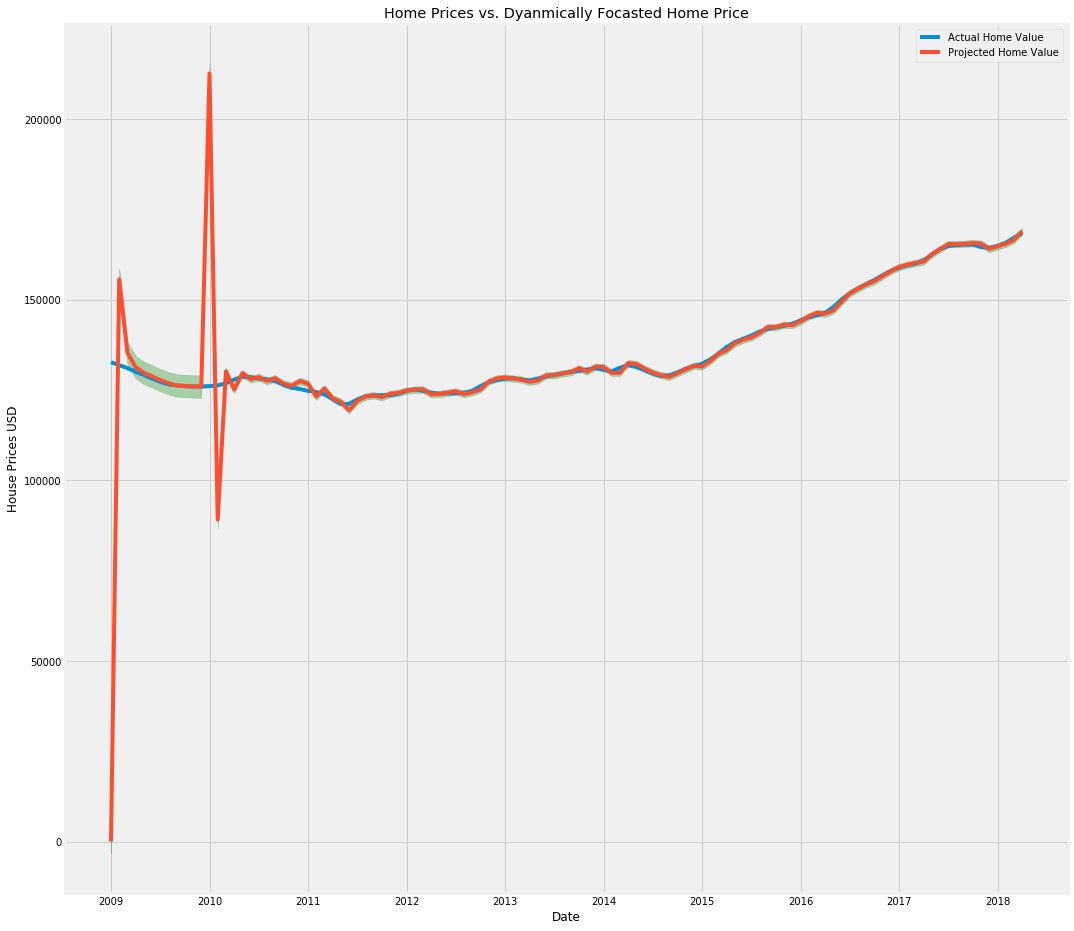

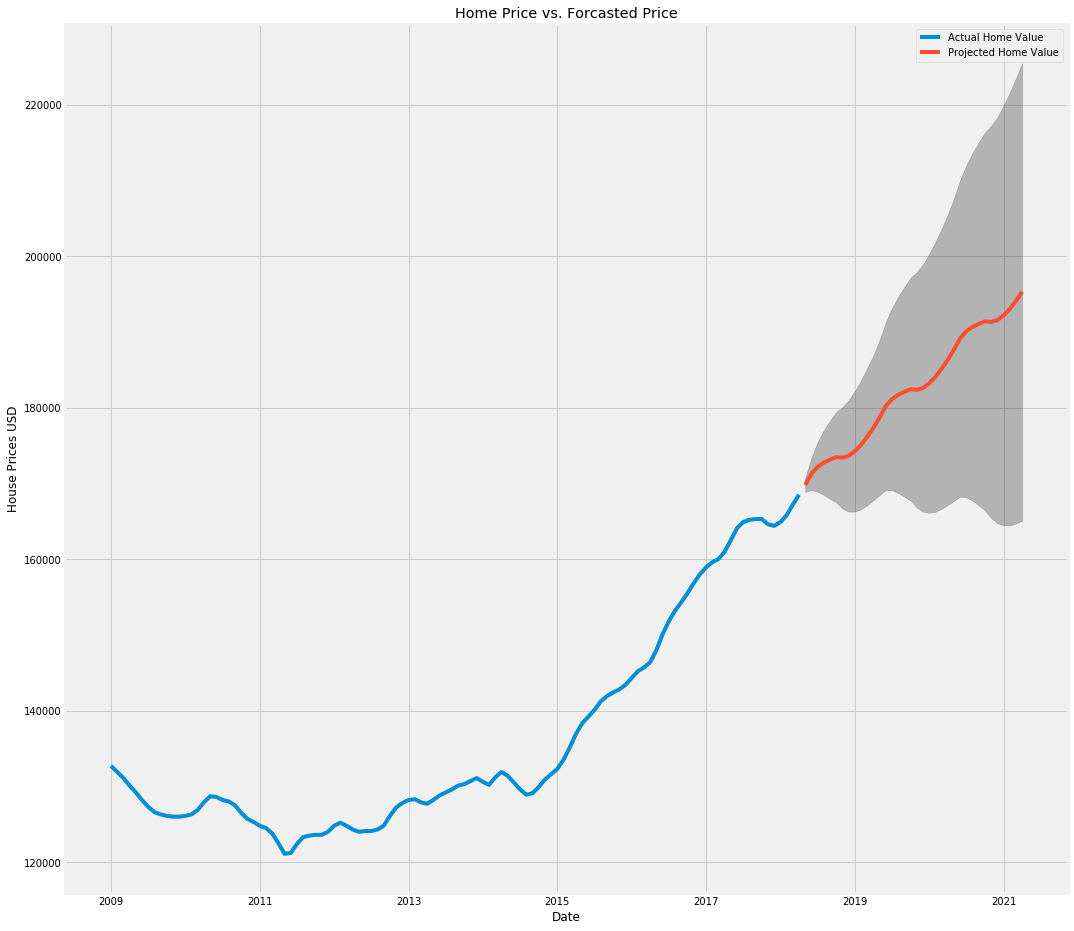

72719 ROI: 15.022128575425823
=================================== 72745 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1368.67
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

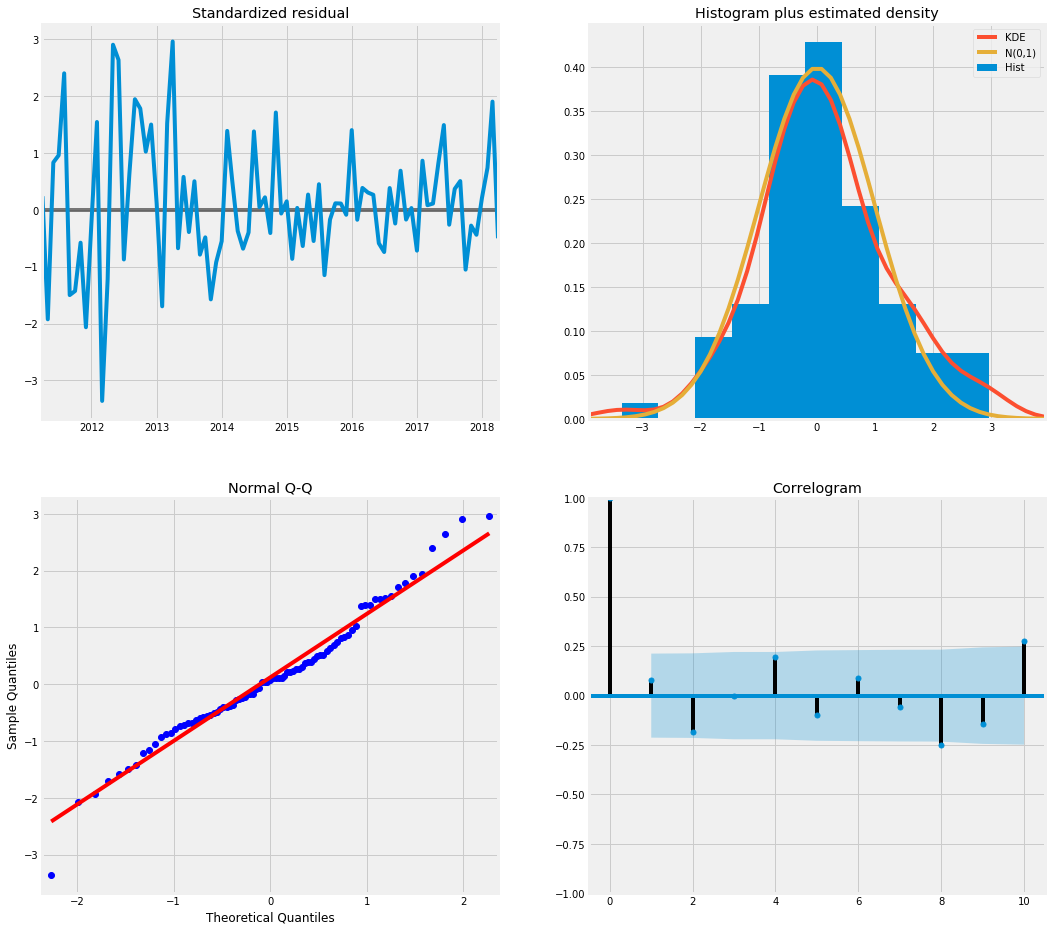

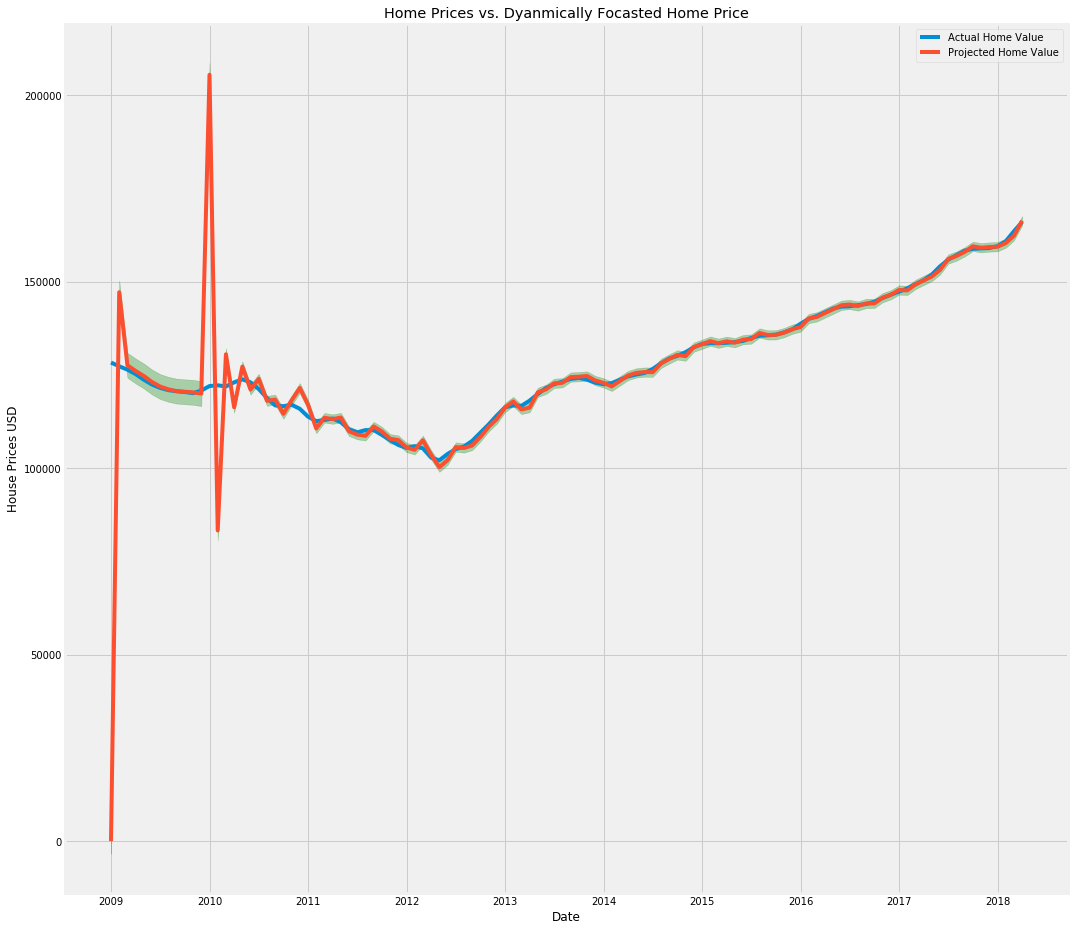

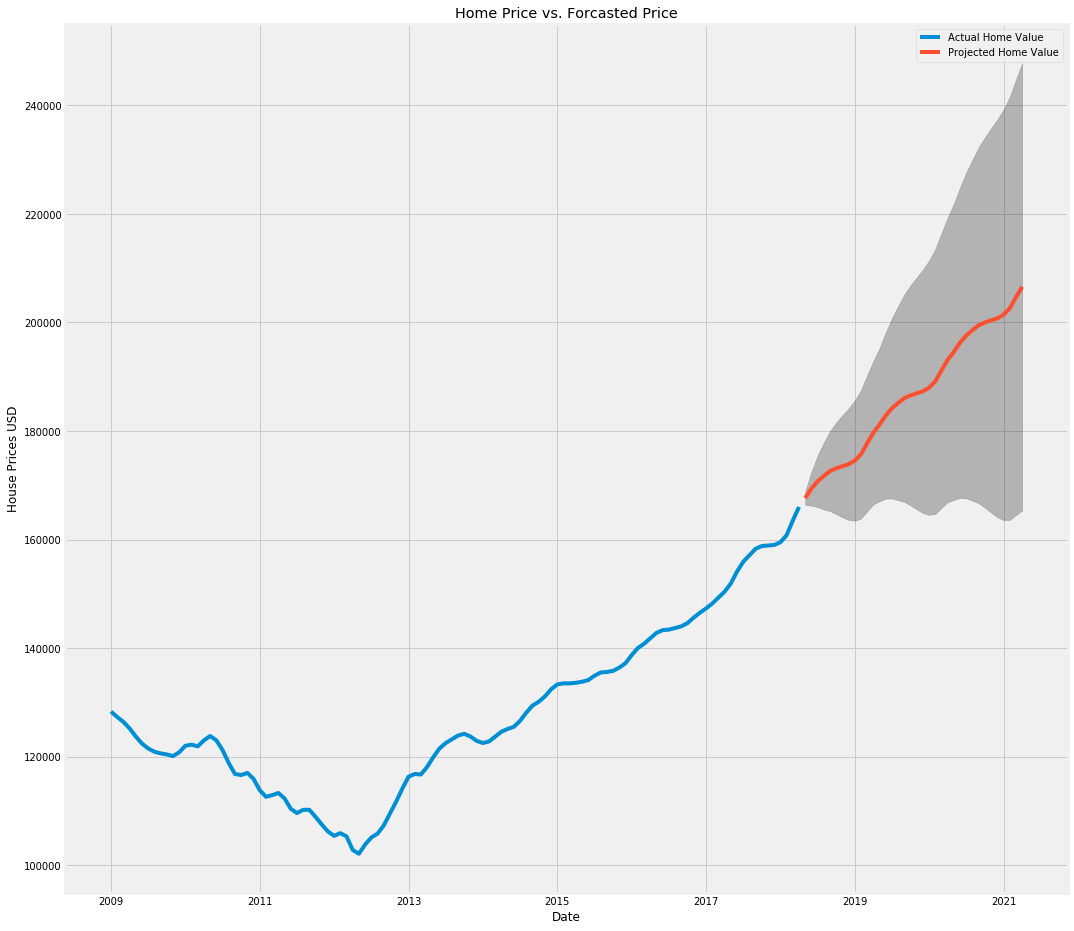

72745 ROI: 23.232305490069418
=================================== 72730 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1361.21
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

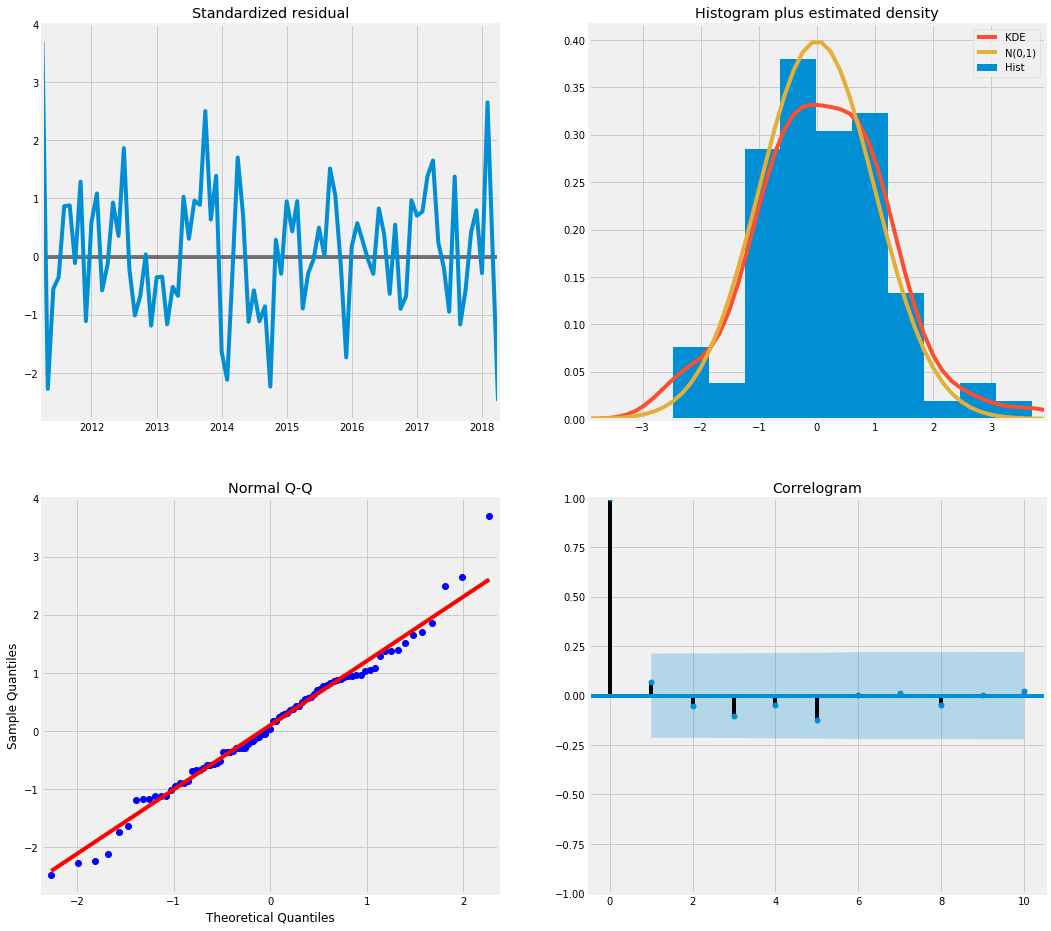

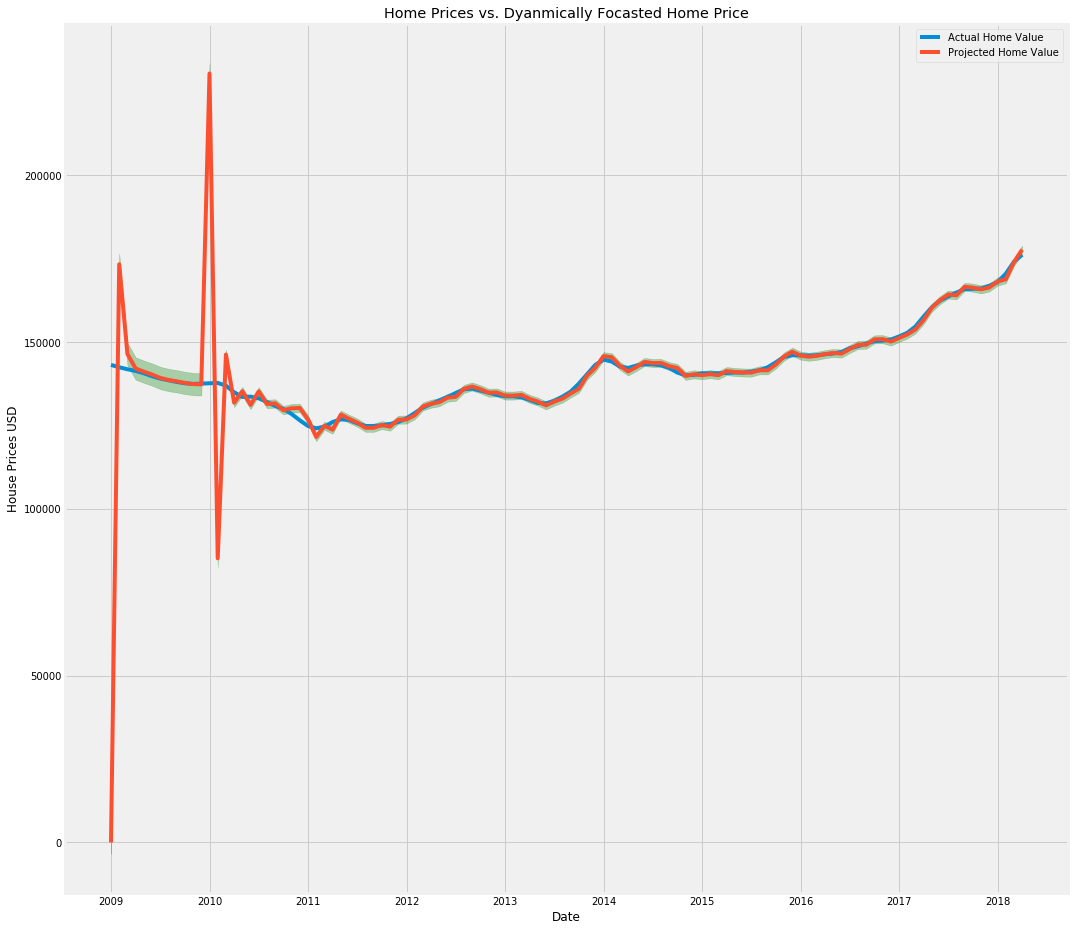

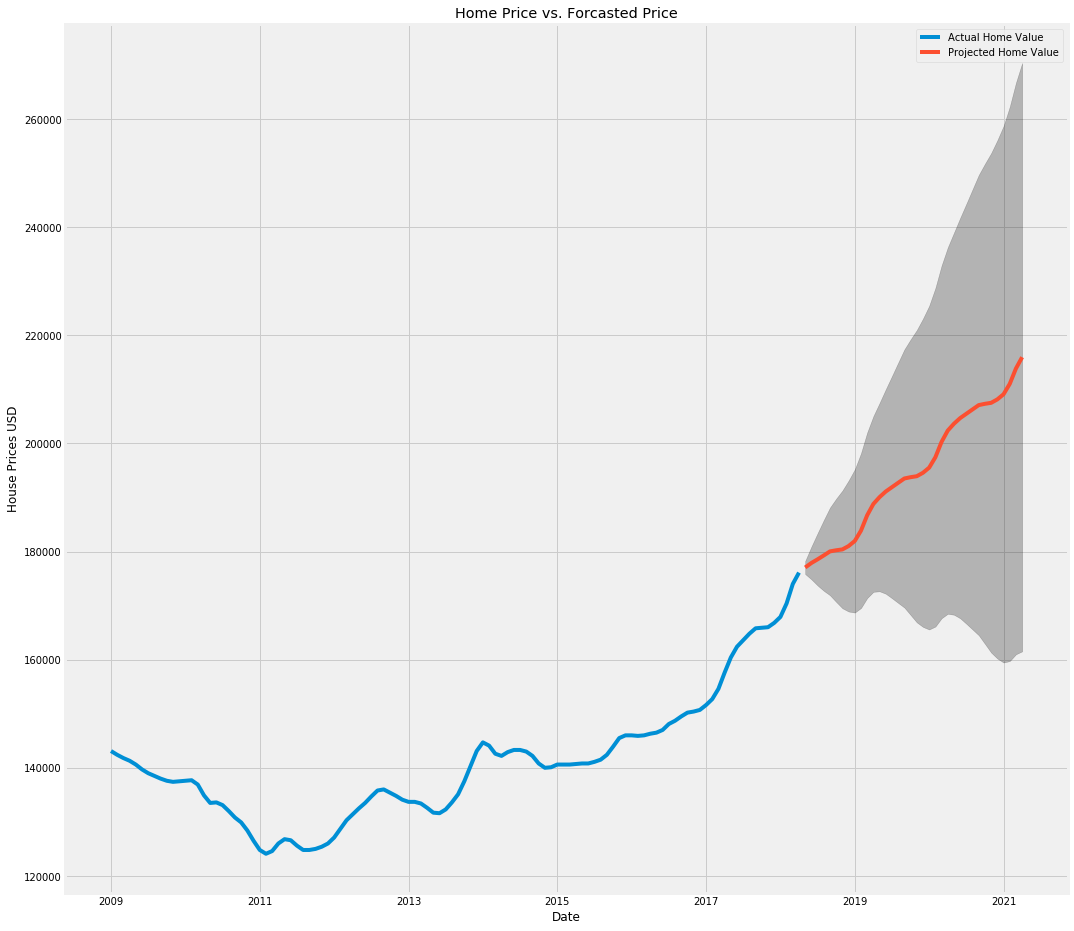

72730 ROI: 21.96729778445112
=================================== 72734 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1424.44
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

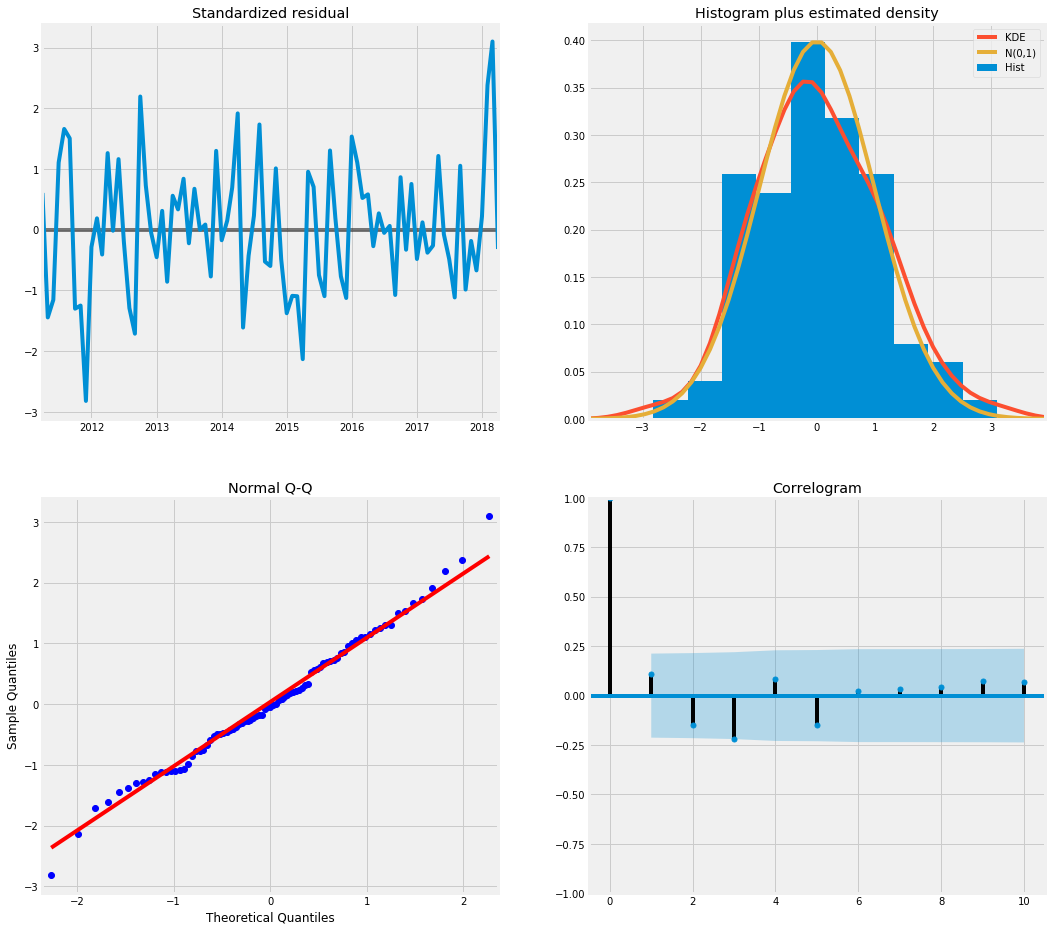

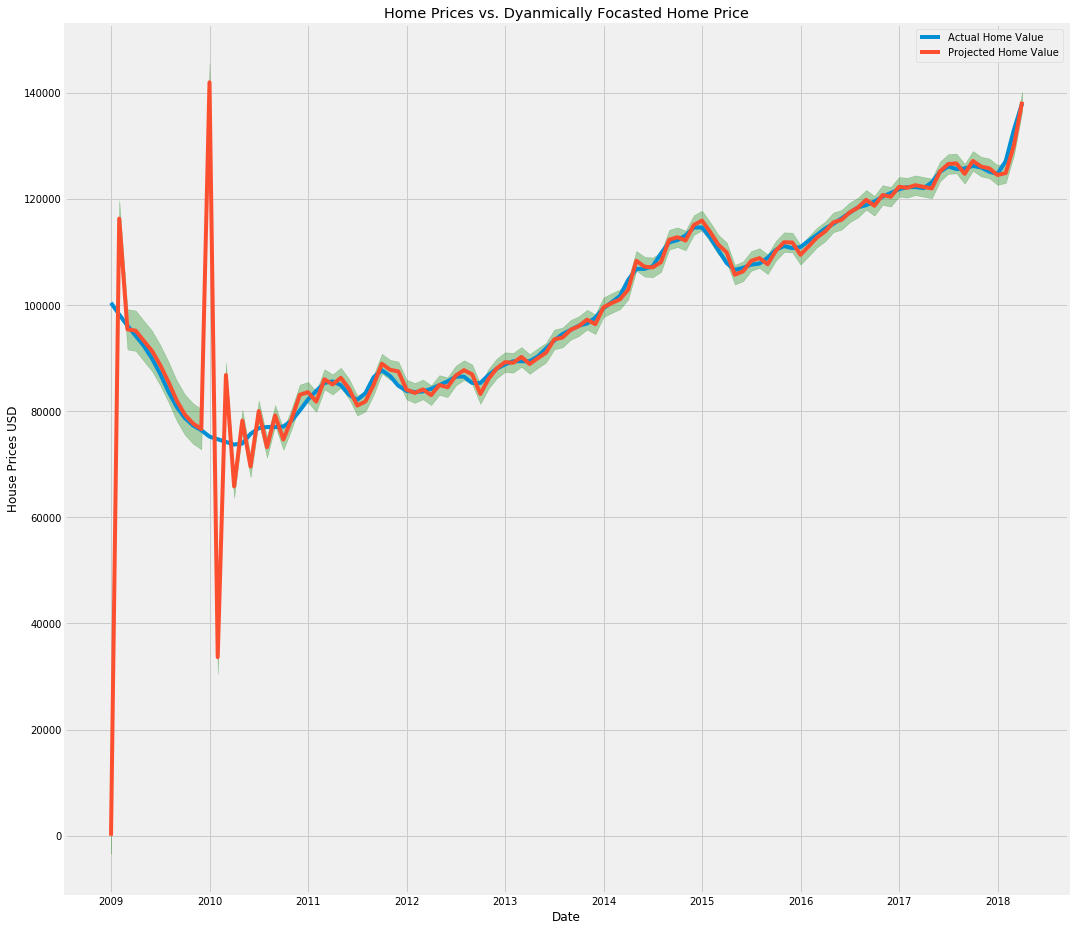

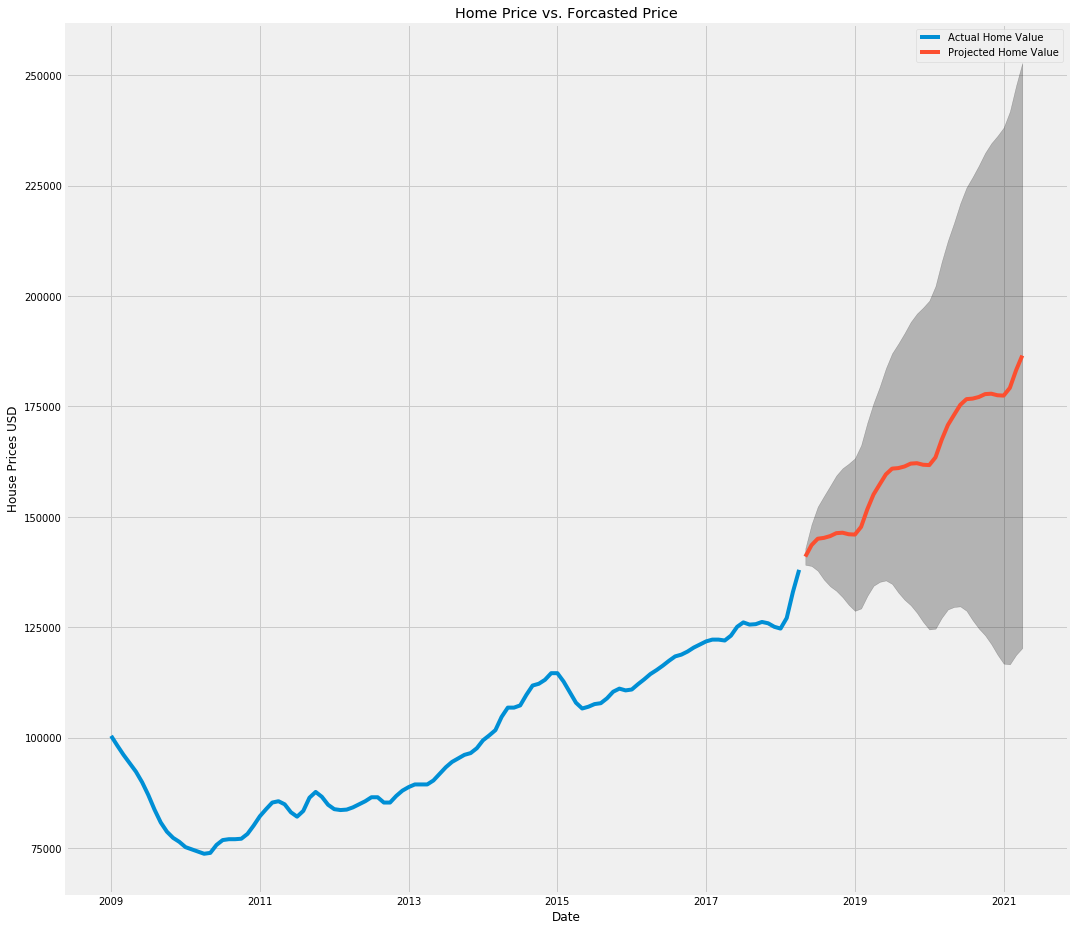

72734 ROI: 32.29840320604585
=================================== 72751 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1349.93
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

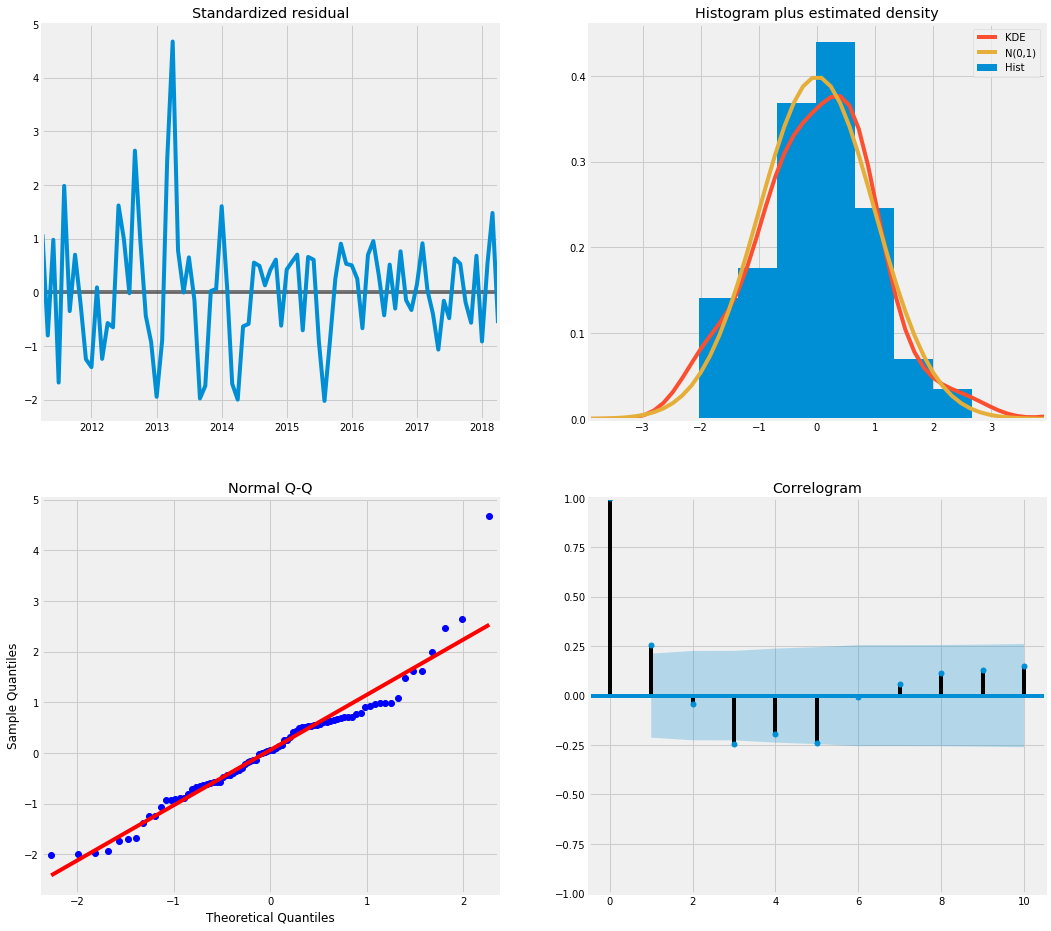

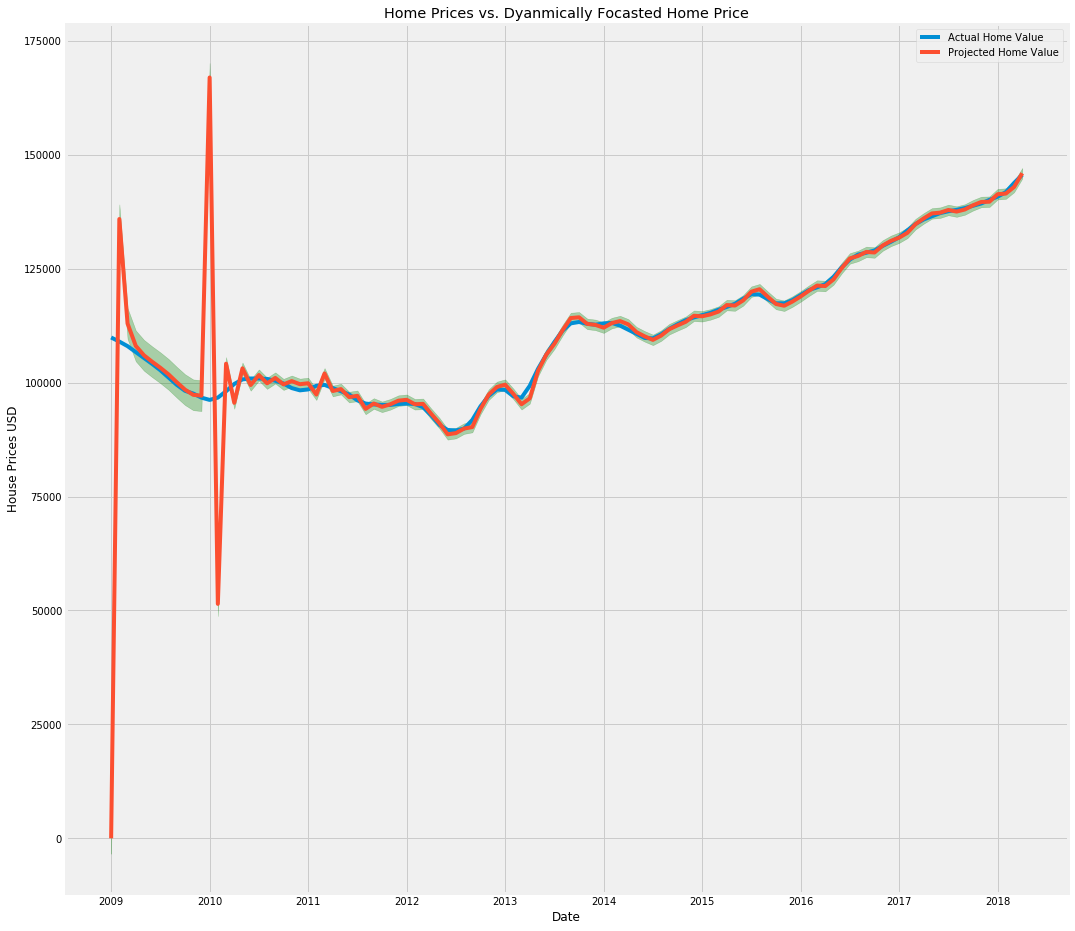

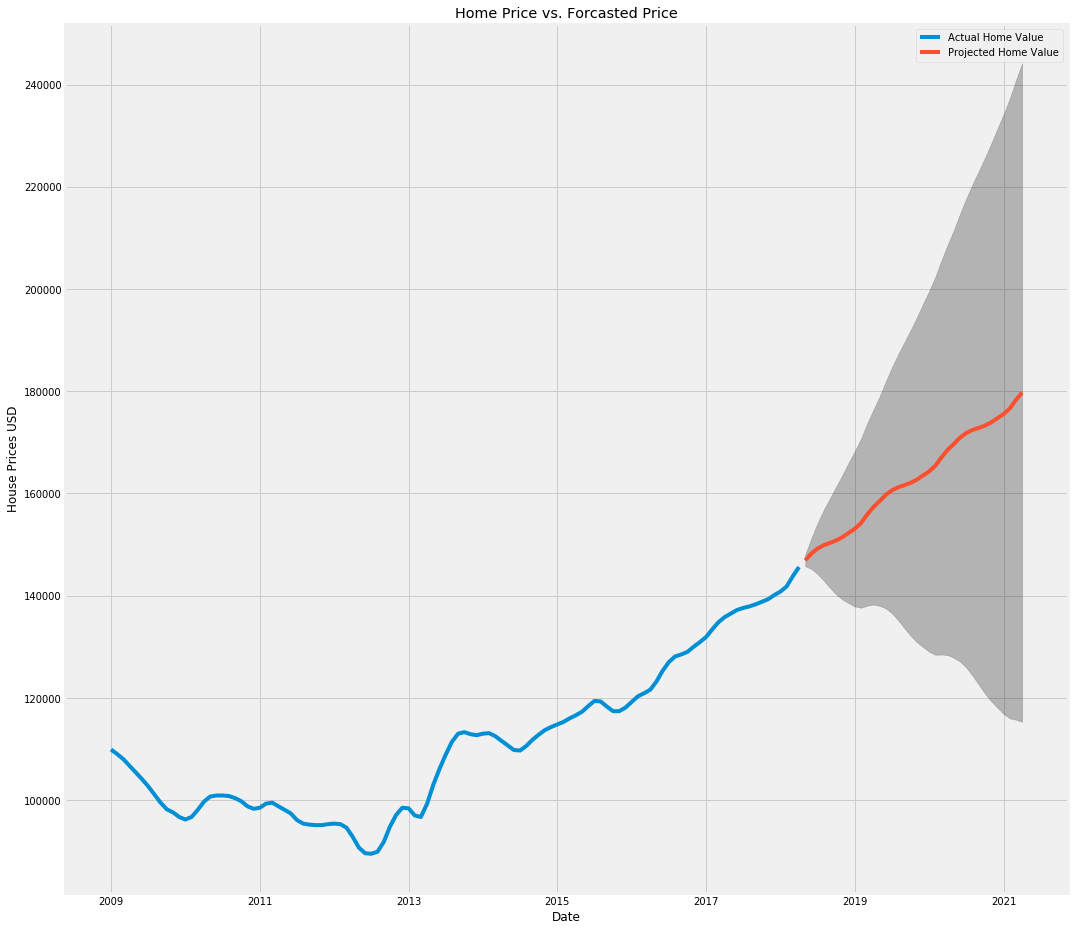

72751 ROI: 22.351908627067633
=================================== 72774 ===================================


pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1391.98
Name: 63, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

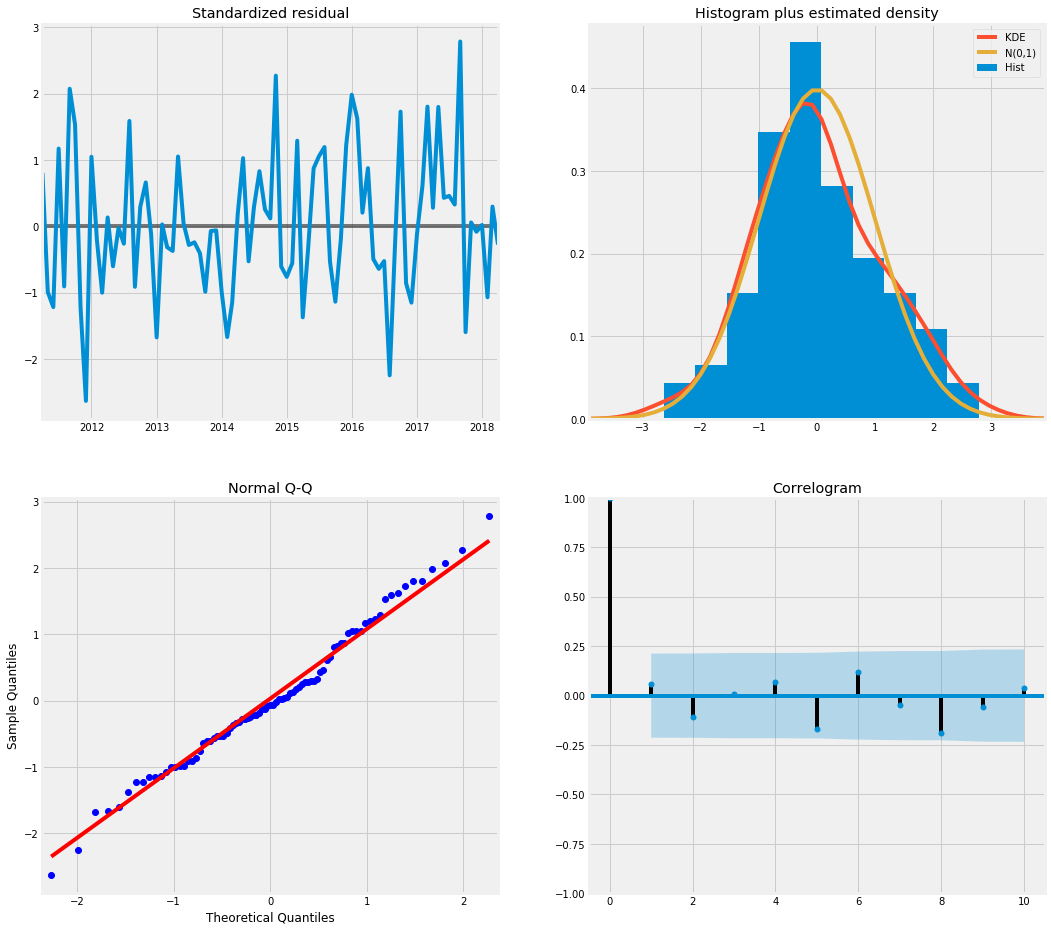

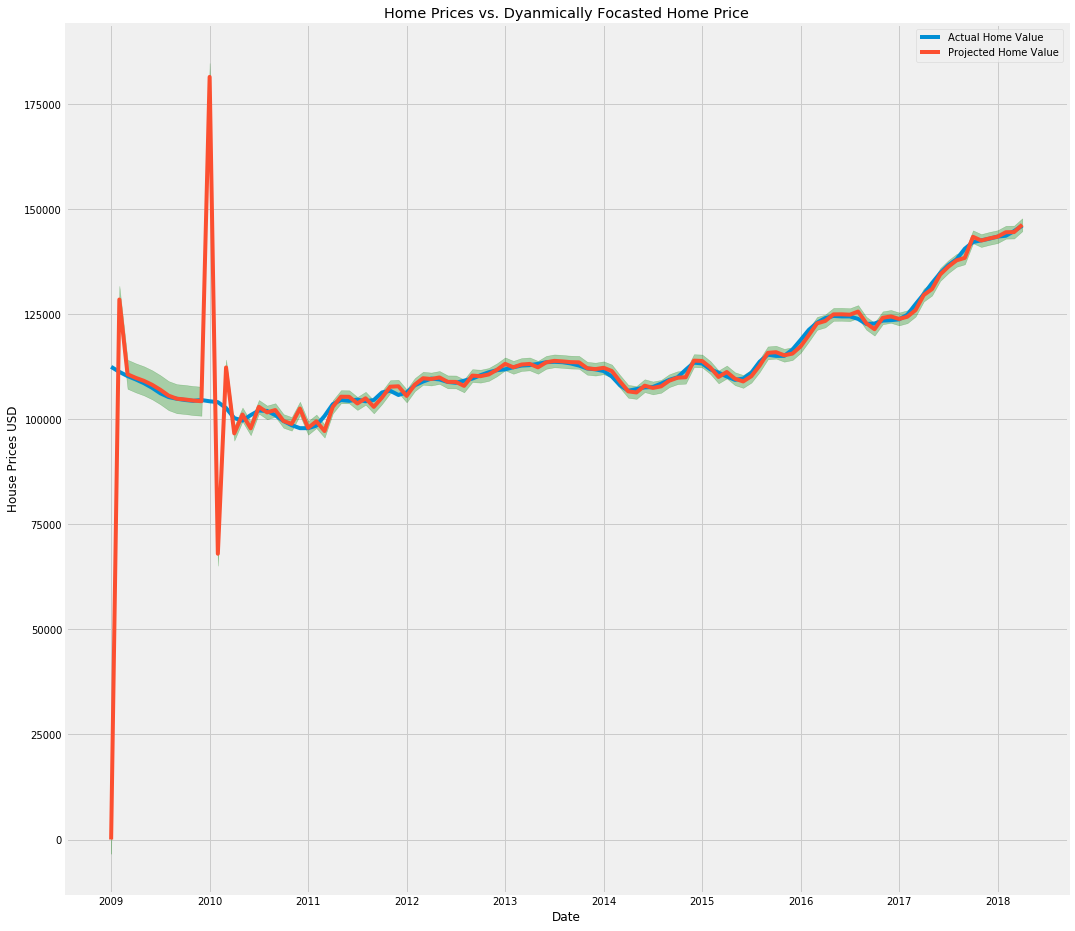

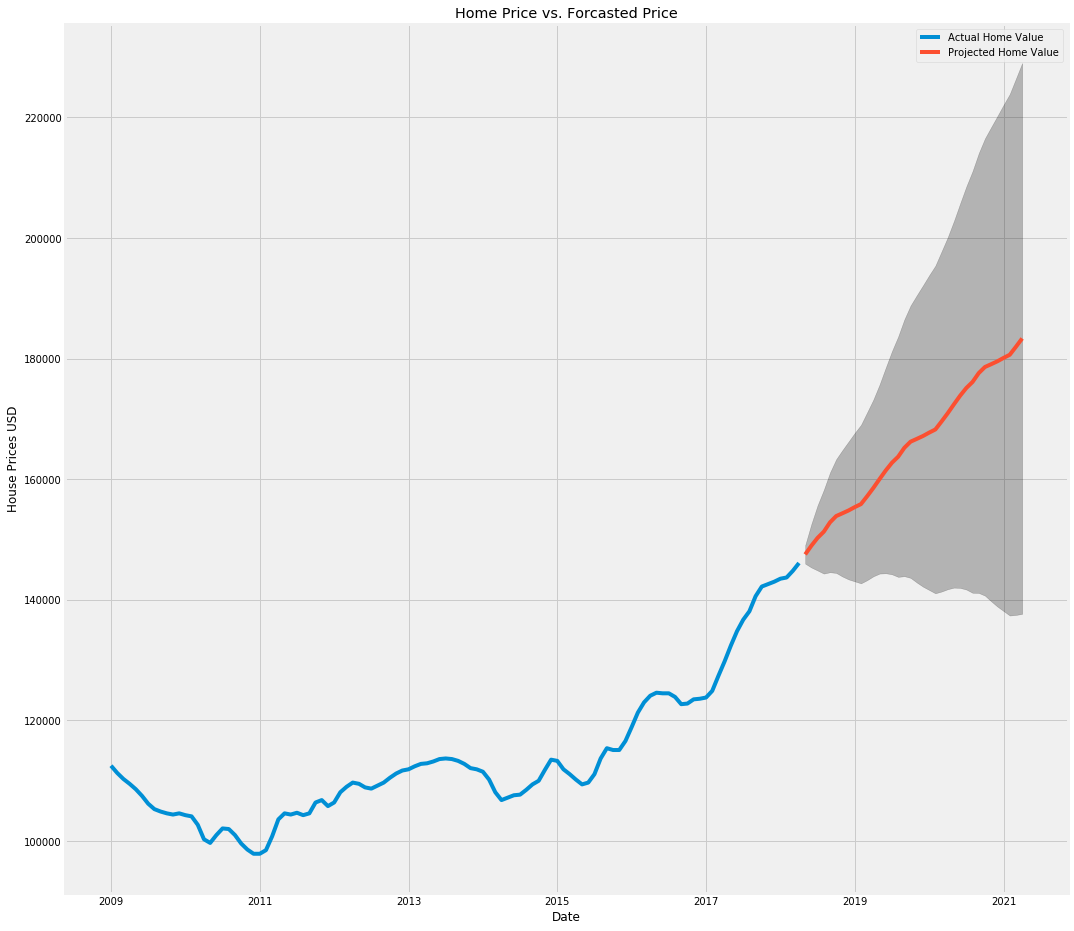

72774 ROI: 24.267030977119834
=================================== 72727 ===================================


pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1334.52
Name: 63, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

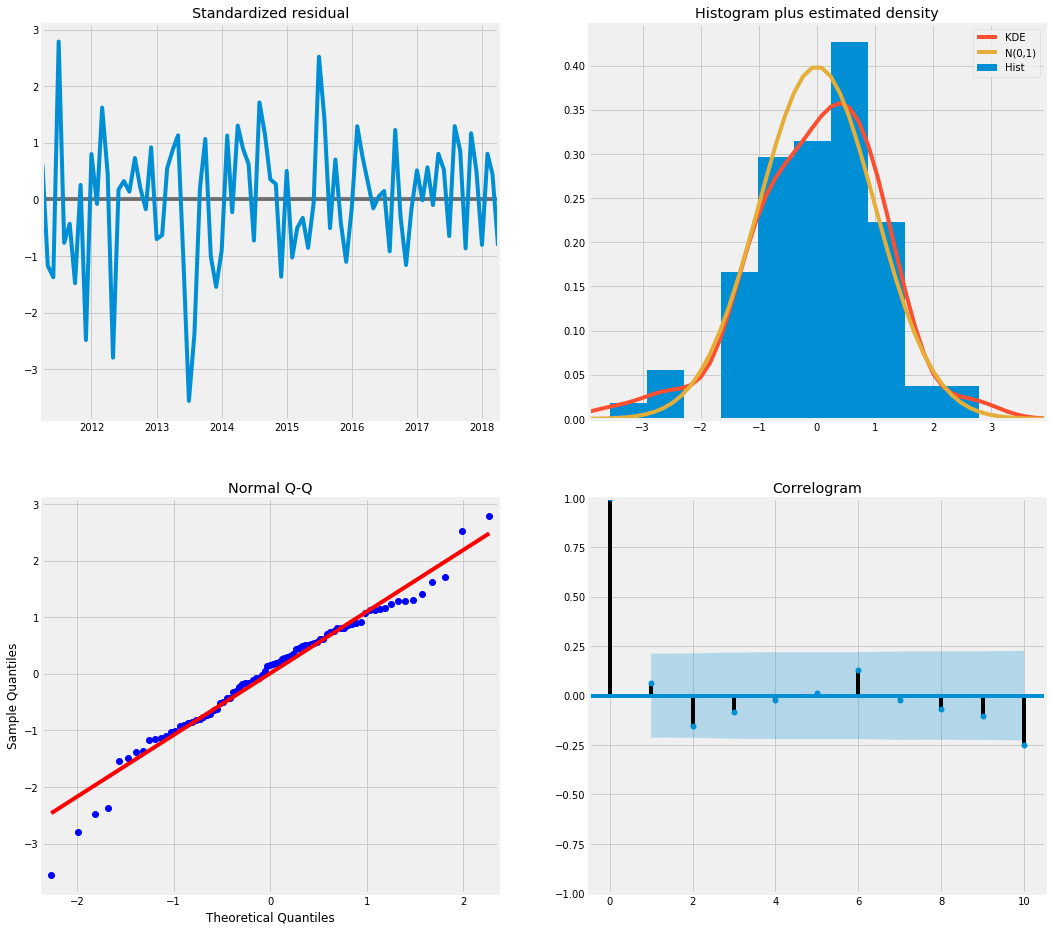

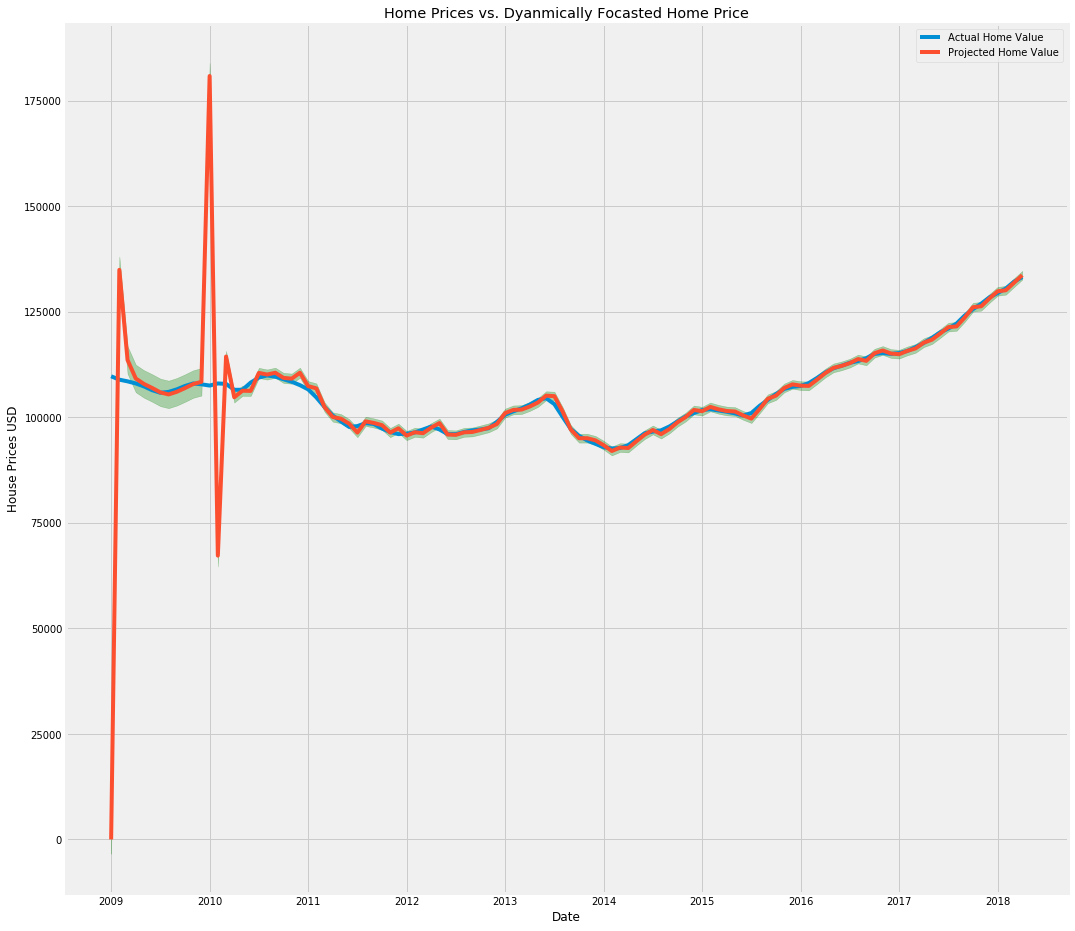

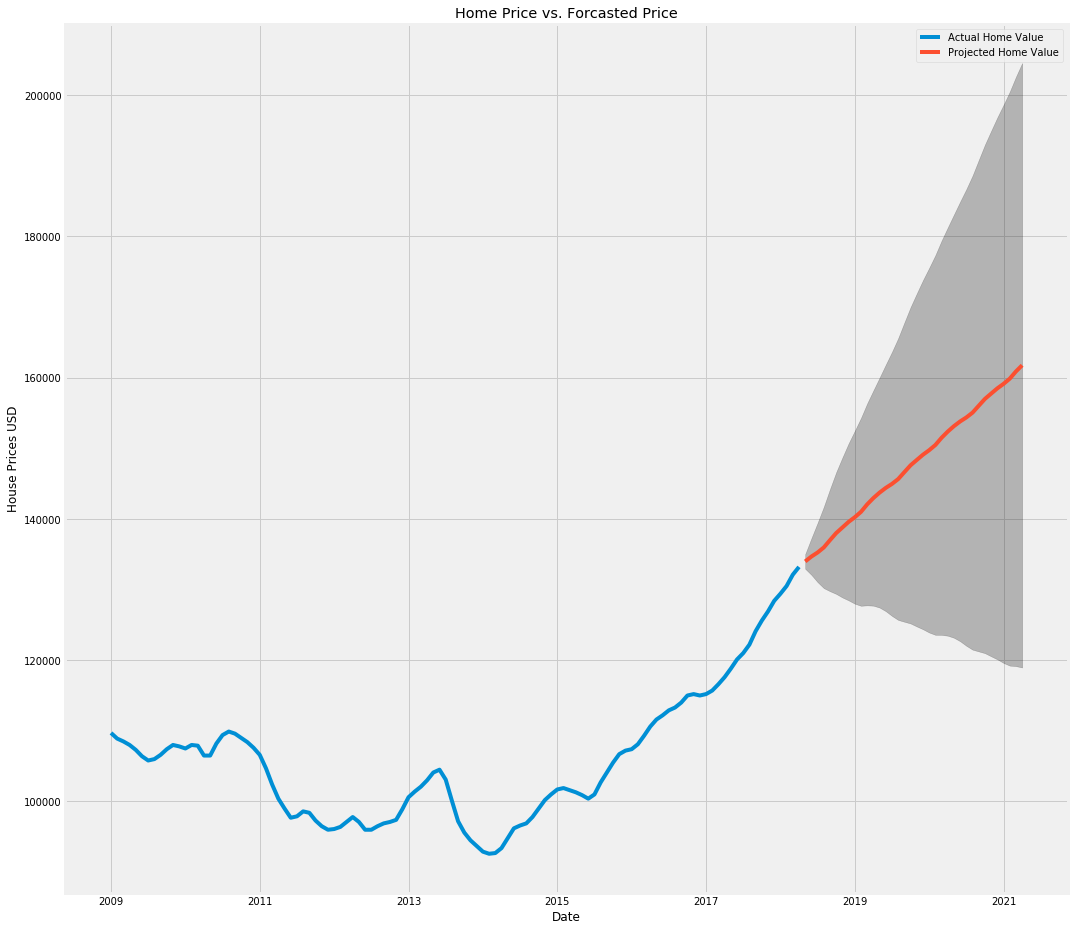

72727 ROI: 20.725329408924775
=================================== 72732 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1507.84
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

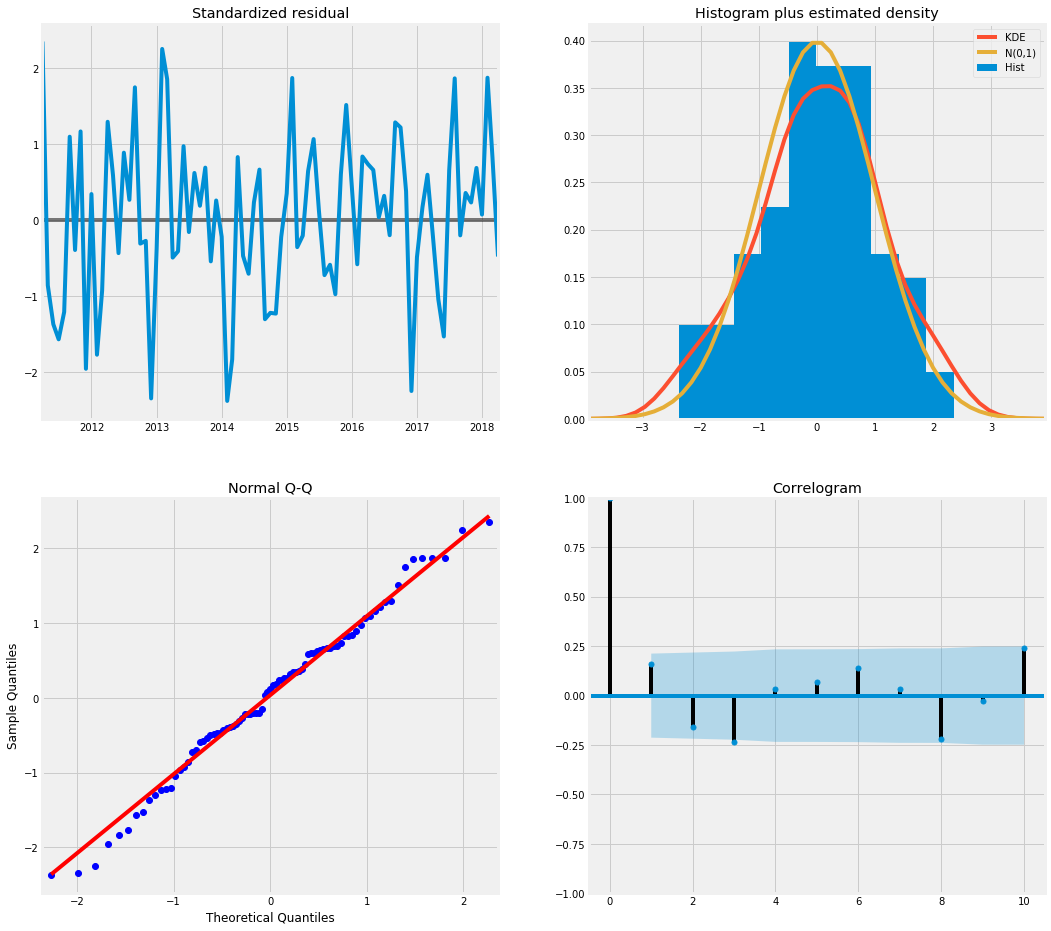

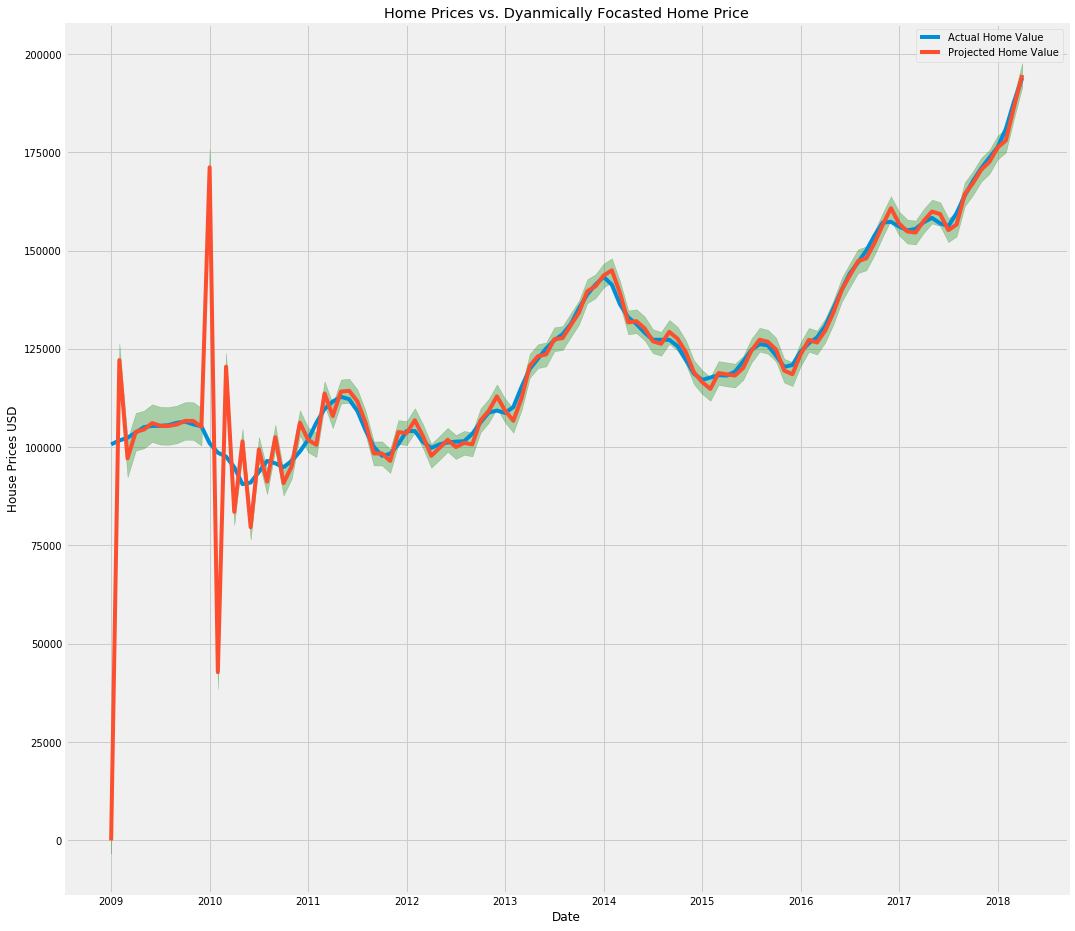

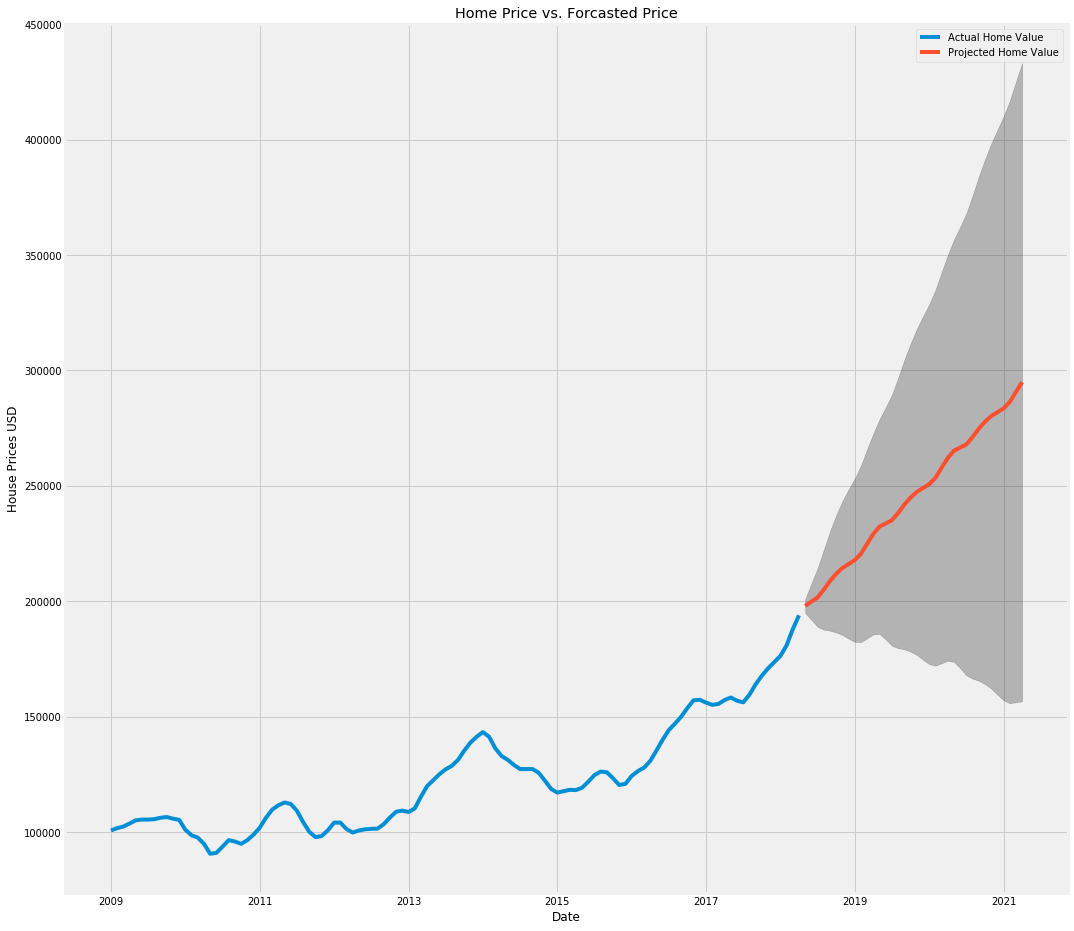

72732 ROI: 48.990462065943696
=================================== 72718 ===================================


pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1806.65
Name: 31, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

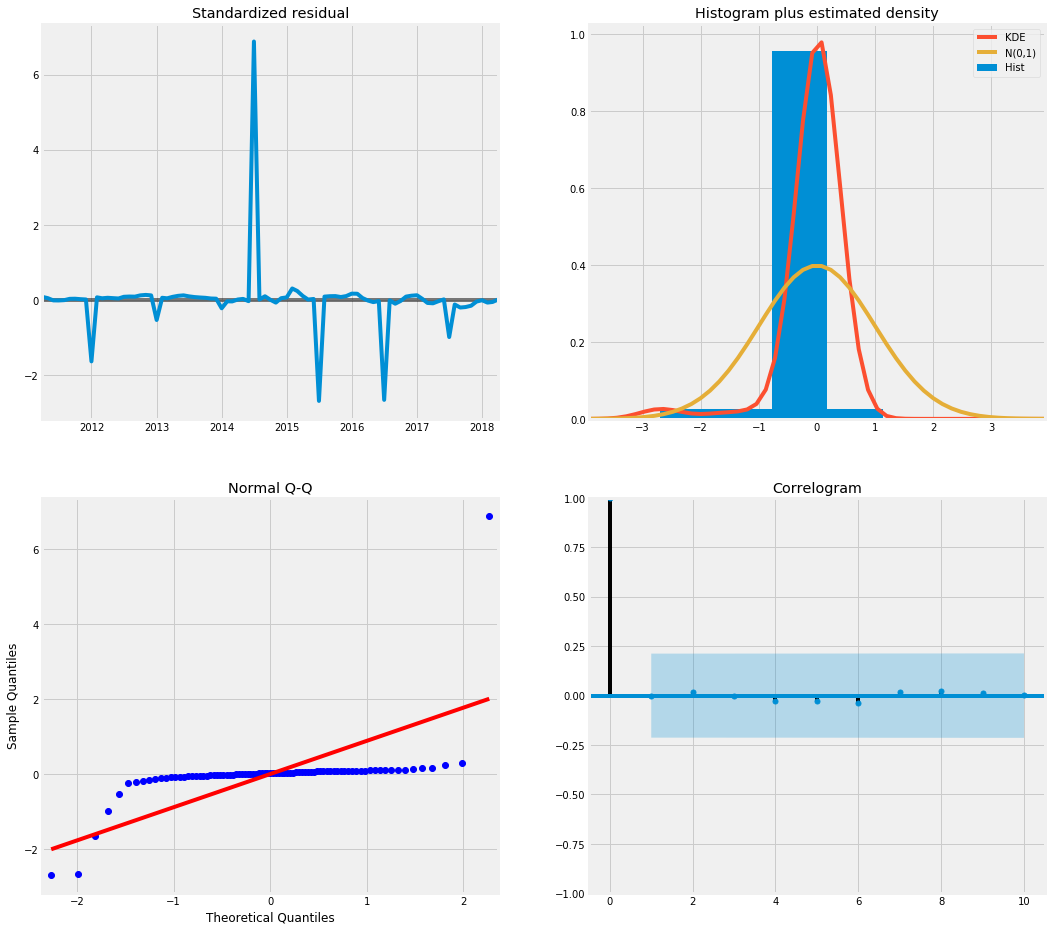

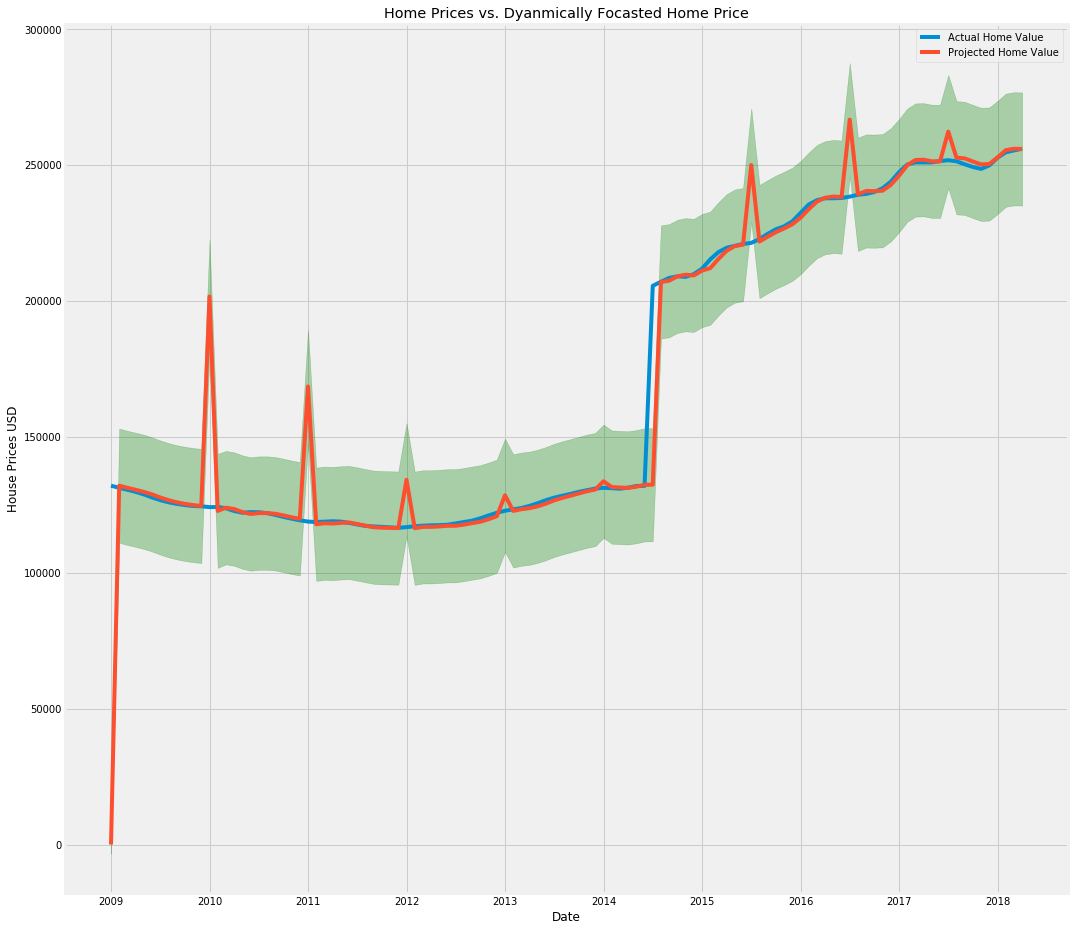

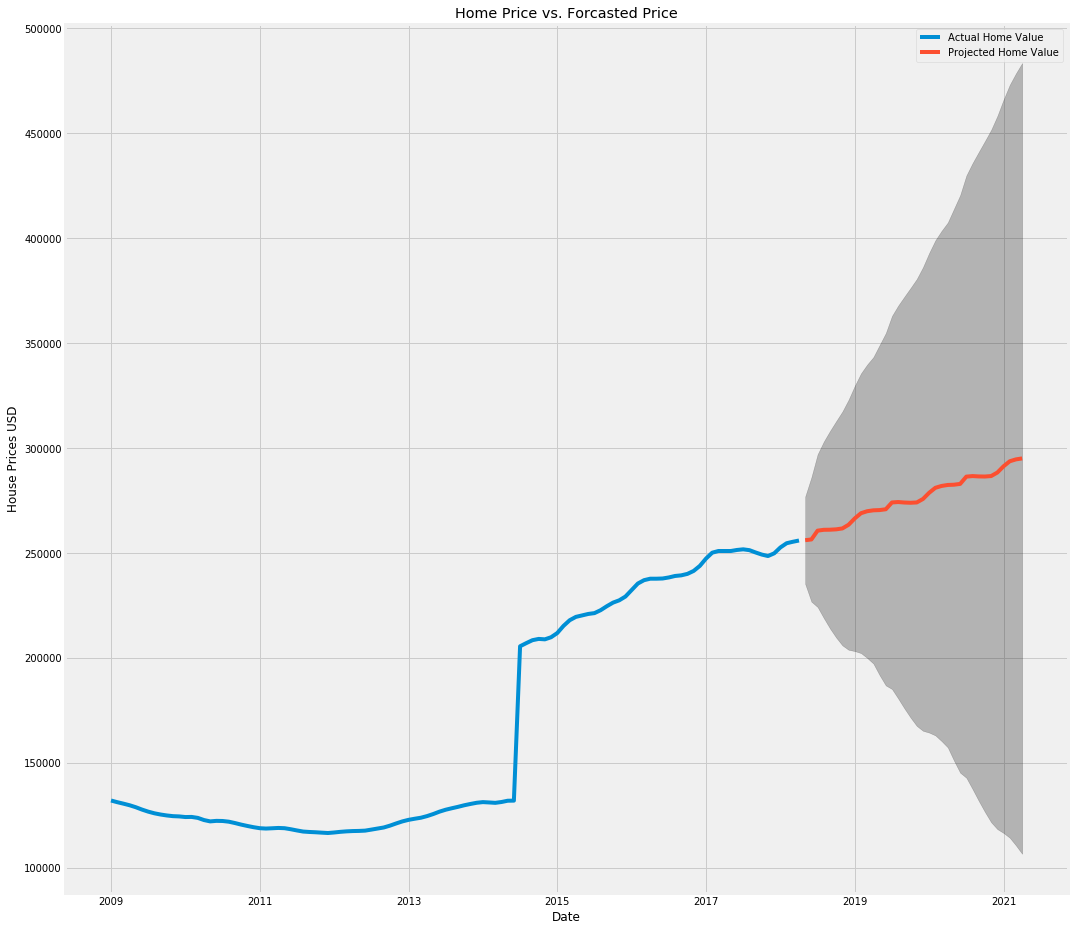

72718 ROI: 15.222874076673442
=================================== 72722 ===================================


pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1475.02
Name: 59, dtype: object

<class 'statsmodels.iolib.table.SimpleTable'>

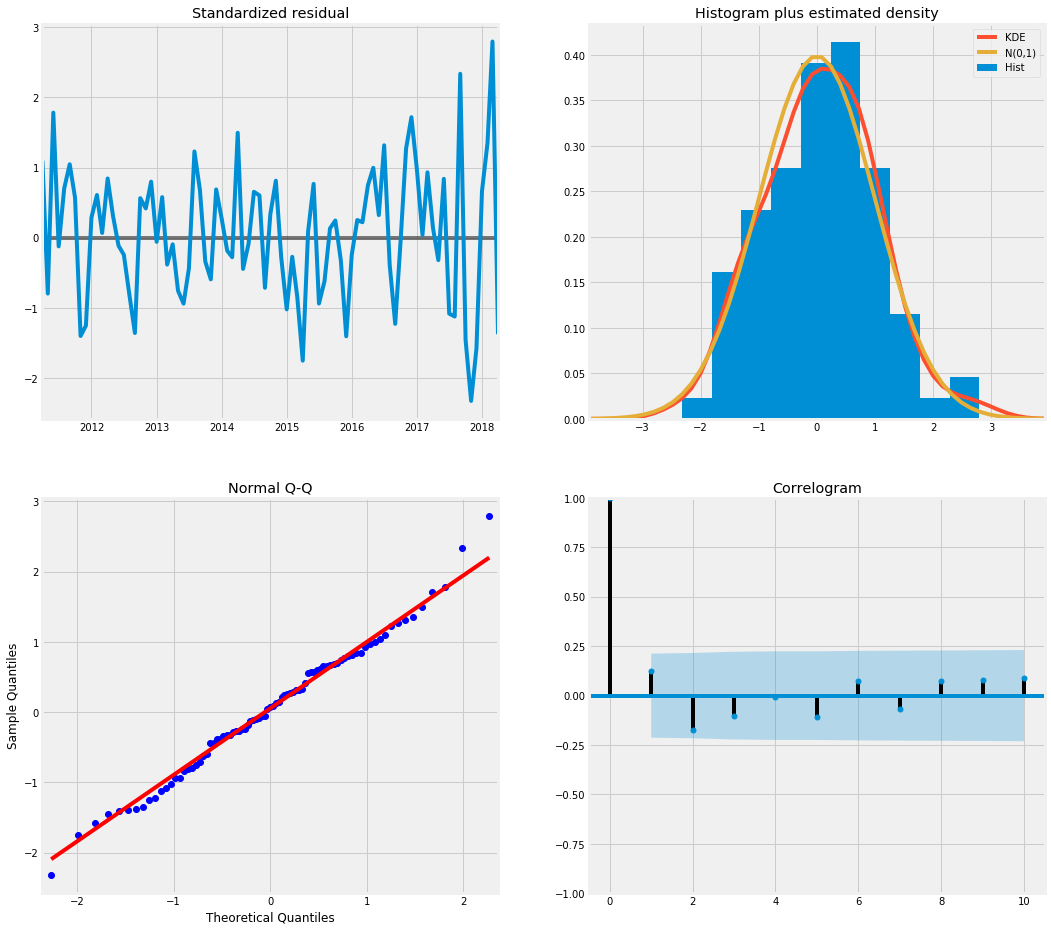

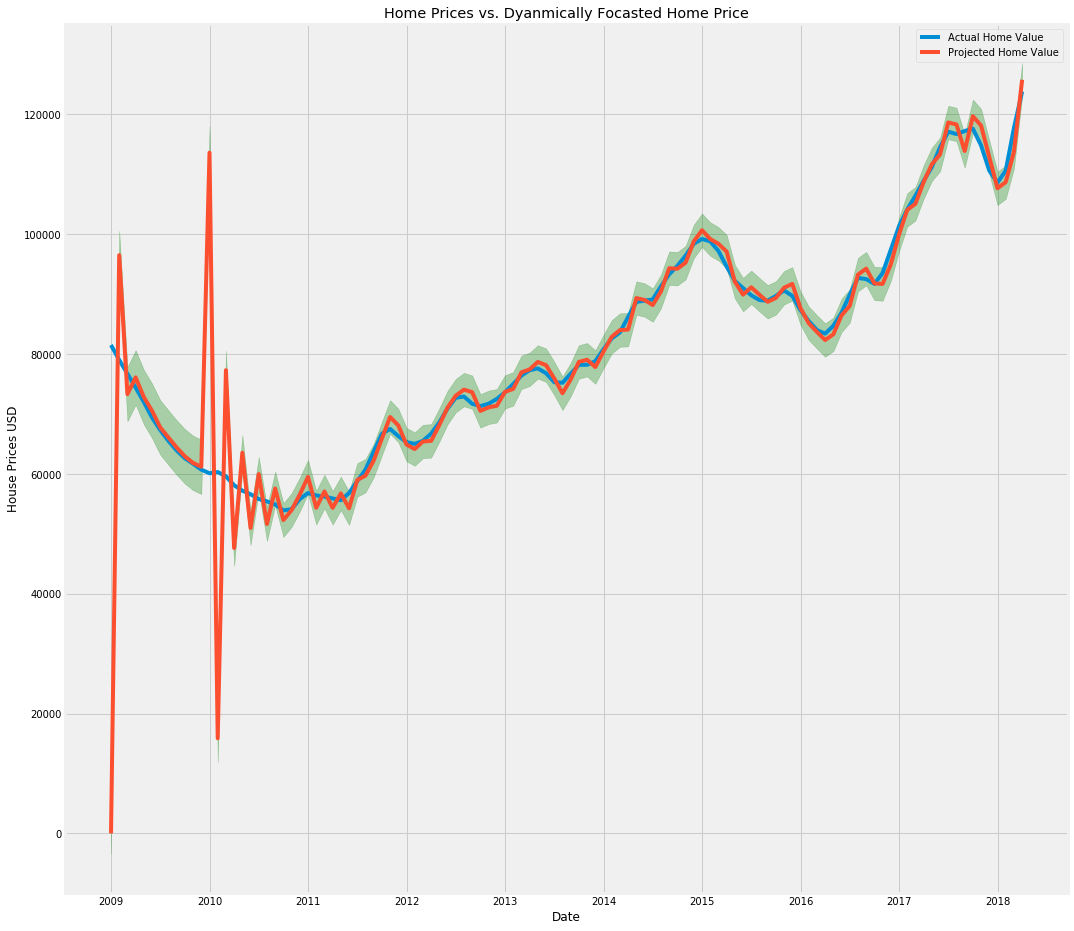

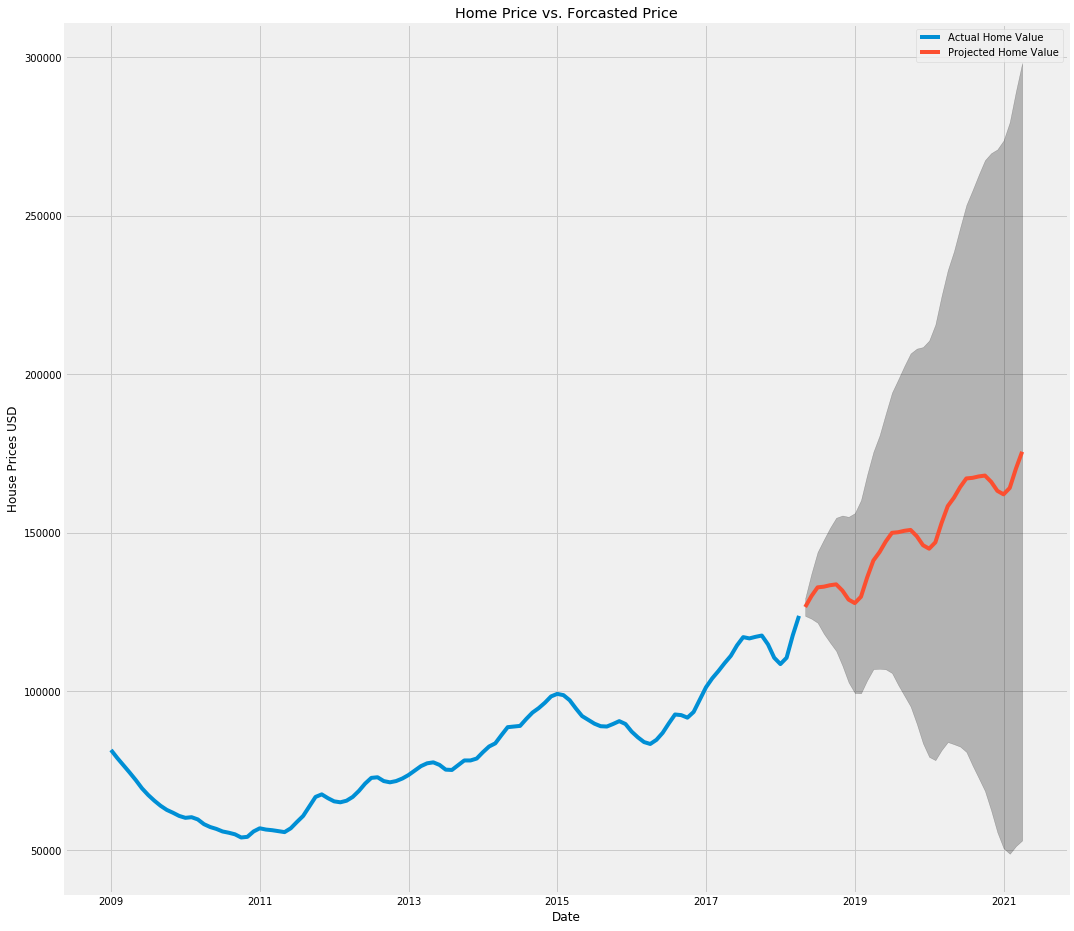

72722 ROI: 38.6854906557711


In [36]:
#needed a list to store ROIs to identify best investment options
ROIs = []

for i in zips_focused_indicies:    
    ans = []
    print('===================================', zips_focused['RegionName'].loc[i],'===================================')
    for comb in pdq:
        for combs in pdqs:
            try:
                zips_melted = melt_data(zips_focused.loc[[i]])
                mod = sm.tsa.statespace.SARIMAX(zips_melted,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])            
    display(ans_df.loc[ans_df['aic'].idxmin()])
    best_fit = ans_df.loc[ans_df['aic'].idxmin()]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zips_melted,
                                    order=best_fit['pdq'],
                                    seasonal_order=best_fit['pdqs'],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    output = ARIMA_MODEL.fit()

    display(output.summary().tables[1])
    output.plot_diagnostics(figsize=(16, 16))

    #Dynamic Forcasting

    pred_dynamic = output.get_prediction(start=pd.to_datetime('2009-01-01'), full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()

    zips_forecasted = pd.DataFrame(pred_dynamic.predicted_mean)
    zips_truth = pd.DataFrame(zips_focused.loc[i, zips_focused.columns[5:]])
    zips_truth.index = pd.to_datetime(zips_truth.index)

    ax = zips_truth.plot(label='observed', figsize=(16, 16))
    pd.DataFrame(zips_forecasted).plot(label='Dynamic Forecast', ax = ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)
    ax.set_xlabel('Date')
    ax.set_ylabel('House Prices USD')
    ax.legend(['Actual Home Value', 'Projected Home Value'])
    
    plt.title('Home Prices vs. Dyanmically Focasted Home Price')    
    plt.show()
    
    #Forecasting
    
    prediction = output.get_forecast(steps=36)
    pred_conf = prediction.conf_int()
    sx = zips_melted.plot(label='Observed Value', figsize=(16, 16))
    prediction.predicted_mean.plot(ax=sx, label='Forecast')
    sx.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)

    sx.set_xlabel('Date')
    sx.set_ylabel('House Prices USD')
    sx.legend(['Actual Home Value', 'Projected Home Value'])
    plt.title('Home Price vs. Forcasted Price')
    plt.show()
    
    #Calculating ROI
    
    first_pred = prediction.predicted_mean[0]
    last_pred = prediction.predicted_mean[-1]
    ROI = ((last_pred-first_pred)/first_pred)*100
    print(zips_focused['RegionName'].loc[i], 'ROI:', ROI)
    zip_ = zips_focused['RegionName'].loc[i]
    addition = (zip_, ROI)
    ROIs.append(addition)

# Step 6: Interpreting Results

In [37]:
#Top 5 zipcodes based on ROI
ROIs
ROIs_sorted = sorted(ROIs, key=lambda tup: tup[1], reverse=True)
ROIs_sorted[:5]
Top_5 = ROIs_sorted[:5]

### TOP 5 zipcodes to invest in:

In [38]:
Top_5 = pd.DataFrame(Top_5)

In [39]:
Top_5.columns = ['Zipcode', 'ROI']
Top_5.set_index('Zipcode', inplace=True)
Top_5

ROI
Zipcode           
72732    48.990462
72722    38.685491
72734    32.298403
72701    26.642996
72774    24.267031

### Conclusions

* All 5 zipcodes had averages significantly higher than metro average before forecasting. 
* Though 72732, 72722, and 72734 have the highest ROIs, their confidence intervals are fairly wide
* 72701 and 72774 are the best options for investment with risk taken into account